**Imports**

In [1]:
import pandas as pd
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from scipy.cluster.hierarchy import linkage
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib.cm import get_cmap
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import re
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
from sklearn.utils import check_random_state

**PCA with miRNA expression data normalized as z-scores**

In [2]:
# Prepare the data
clinical_data = pd.read_table("C:/Users/marga/Downloads/Projeto/Data_TGCA/BRCA_clinicalData.txt", sep='\t')

#check if the samples are all from tumor or not (tumor - 01; not tumor - 011)
tumor_data = clinical_data[clinical_data["sampleId"].str.endswith("01")]
tumor_data

sampleId     patientId        studyId    CANCER_TYPE  \
0    TCGA-A2-A0T2-01  TCGA-A2-A0T2  brca_tcga_pub  Breast Cancer   
1    TCGA-A2-A04P-01  TCGA-A2-A04P  brca_tcga_pub  Breast Cancer   
2    TCGA-A1-A0SK-01  TCGA-A1-A0SK  brca_tcga_pub  Breast Cancer   
3    TCGA-A2-A0CM-01  TCGA-A2-A0CM  brca_tcga_pub  Breast Cancer   
4    TCGA-AR-A1AR-01  TCGA-AR-A1AR  brca_tcga_pub  Breast Cancer   
..               ...           ...            ...            ...   
458  TCGA-E2-A108-01  TCGA-E2-A108  brca_tcga_pub  Breast Cancer   
459  TCGA-AO-A0JB-01  TCGA-AO-A0JB  brca_tcga_pub  Breast Cancer   
460  TCGA-AO-A03R-01  TCGA-AO-A03R  brca_tcga_pub  Breast Cancer   
461  TCGA-AO-A03T-01  TCGA-AO-A03T  brca_tcga_pub  Breast Cancer   
462  TCGA-AR-A1AO-01  TCGA-AR-A1AO  brca_tcga_pub  Breast Cancer   

          CANCER_TYPE_DETAILED  CN_CLUSTER CONVERTED_STAGE ER_STATUS  \
0    Invasive Breast Carcinoma           3   No_Conversion  Negative   
1    Invasive Breast Carcinoma           1   No_Conversion  Negative   
2    Invasive Breast Carcinoma           1       Stage IIA  Negative   
3    Invasive Breast Carcinoma           4       Stage IIA  Negative   
4    Invasive Breast Carcinoma           1      Stage IIIA  Negative   
..                         ...         ...             ...       ...   
458  Invasive Breast Carcinoma           4   No_Conversion  Positive   
459  Invasive Breast Carcinoma           1   No_Conversion  Positive   
460  Invasive Breast Carcinoma           4   No_Conversion  Positive   
461  Invasive Breast Carcinoma           5   No_Conversion  Positive   
462  Invasive Breast Carcinoma           1       Stage IIA  Positive   

     FRACTION_GENOME_ALTERED HER2_STATUS  ...  SURVIVAL_DATA_FORM  \
0                     0.9463    Negative  ...            followup   
1                     0.6407    Negative  ...            followup   
2                     0.4163    Negative  ...            followup   
3                     0.3928    Negative  ...            followup   
4                     0.4696    Negative  ...          enrollment   
..                       ...         ...  ...                 ...   
458                   0.0338    Negative  ...            followup   
459                   0.4249    Negative  ...            followup   
460                   0.2442    Negative  ...            followup   
461                   0.2679    Negative  ...          enrollment   
462                   0.0002    Negative  ...          enrollment   

     TMB_NONSYNONYMOUS  TUMOR_STAGE TUMOR_T1_CODED  AGE  METASTASIS  \
0             0.766667           T3        T_Other   66          M1   
1             3.400000           T2        T_Other   36          M0   
2             1.600000           T2        T_Other   54          M0   
3             1.233333           T2        T_Other   40          M0   
4             1.400000           T1             T1   50          M0   
..                 ...          ...            ...  ...         ...   
458           1.466667           T2        T_Other   64          M0   
459           1.900000           T3        T_Other   50          M0   
460           0.900000           T2        T_Other   57          M0   
461           2.233333           T2        T_Other   42          M0   
462           0.233333           T1             T1   47          M0   

     OS_MONTHS   OS_STATUS SAMPLE_COUNT     SEX  
0         7.89  1:DECEASED            1  Female  
1        17.97  1:DECEASED            1  Female  
2        31.77  1:DECEASED            1  Female  
3        24.77  1:DECEASED            1  Female  
4        17.18  1:DECEASED            1  Female  
..         ...         ...          ...     ...  
458      27.50    0:LIVING            1  Female  
459      37.78    0:LIVING            1  Female  
460      56.08    0:LIVING            1  Female  
461      39.00    0:LIVING            1  Female  
462      43.50    0:LIVING            1  Female  

[463 rows x 37 columns]

In [3]:
#remove rows with subtype normal-like as they do in the article, since 8 samples is very little
normal_like = tumor_data[tumor_data["PAM50_SUBTYPE"] == "Normal-like"] # exactly 8 like they mention in the article
normal_like_ids = normal_like["sampleId"].to_list()

normal_like_ids ## ---------------------> this is a list of the ID's NOT to include

['TCGA-AO-A03U-01',
 'TCGA-B6-A0IE-01',
 'TCGA-A2-A0YK-01',
 'TCGA-E2-A108-01',
 'TCGA-AO-A0JB-01',
 'TCGA-AO-A03R-01',
 'TCGA-AO-A03T-01',
 'TCGA-AR-A1AO-01']

In [4]:
#import miRNAZscores - expression
miRNAZscores = pd.read_table("C:/Users/marga/Downloads/Projeto/Data_TGCA/BRCA_microRNA_Zscores.txt", sep= '\t')
miRNAZscores

entrezGeneId  hugoGeneSymbol   type  TCGA-A1-A0SE-01  TCGA-A1-A0SH-01  \
0            -164    MIR-744/744*  miRNA           0.2973          -0.3408   
1            -163     MIR-744/744  miRNA           0.2973          -0.3408   
2            -162      MIR-744/3P  miRNA           0.2973          -0.3408   
3            -161      MIR-744/5P  miRNA           0.2973          -0.3408   
4            -160     MIR-758/758  miRNA           0.2044           1.4946   
..            ...             ...    ...              ...              ...   
883         -3817      MIR-100/5P  miRNA           0.9122           1.2860   
884         -3815  MIR-100-11/100  miRNA           0.9122           1.2860   
885         -3807     MIR-101/101  miRNA           1.8203          -0.5674   
886         -3805      MIR-101/3P  miRNA           1.8203          -0.5674   
887         -3804      MIR-101/5P  miRNA           1.8203          -0.5674   

     TCGA-A1-A0SJ-01  TCGA-A1-A0SK-01  TCGA-A1-A0SM-01  TCGA-A1-A0SO-01  \
0            -1.6876           0.1988          -0.0434           1.7106   
1            -1.6876           0.1988          -0.0434           1.7106   
2            -1.6876           0.1988          -0.0434           1.7106   
3            -1.6876           0.1988          -0.0434           1.7106   
4            -0.0618          -1.9075           0.2237           0.2881   
..               ...              ...              ...              ...   
883           0.4609          -2.8709          -0.1348          -1.1782   
884           0.4609          -2.8709          -0.1348          -1.1782   
885           0.4688          -0.1298          -0.9285           0.6624   
886           0.4688          -0.1298          -0.9285           0.6624   
887           0.4688          -0.1298          -0.9285           0.6624   

     TCGA-A2-A04P-01  ...  TCGA-BH-A0HO-01  TCGA-BH-A0HP-01  TCGA-BH-A0HU-01  \
0            -0.3780  ...           0.9156          -1.5327           0.4095   
1            -0.3780  ...           0.9156          -1.5327           0.4095   
2            -0.3780  ...           0.9156          -1.5327           0.4095   
3            -0.3780  ...           0.9156          -1.5327           0.4095   
4            -2.3948  ...          -1.7507          -0.7018          -0.1852   
..               ...  ...              ...              ...              ...   
883           0.4260  ...          -0.2346           1.2119          -0.2114   
884           0.4260  ...          -0.2346           1.2119          -0.2114   
885          -0.8854  ...           0.3234           1.2329           0.2594   
886          -0.8854  ...           0.3234           1.2329           0.2594   
887          -0.8854  ...           0.3234           1.2329           0.2594   

     TCGA-BH-A0HW-01  TCGA-BH-A0HX-01  TCGA-BH-A0RX-01  TCGA-BH-A0W3-01  \
0             0.3909          -0.7938           0.7017           1.8394   
1             0.3909          -0.7938           0.7017           1.8394   
2             0.3909          -0.7938           0.7017           1.8394   
3             0.3909          -0.7938           0.7017           1.8394   
4            -0.5525           0.2430          -0.4983           0.5237   
..               ...              ...              ...              ...   
883          -1.9937           0.9783           1.8132           0.3105   
884          -1.9937           0.9783           1.8132           0.3105   
885           1.0376           0.6323           1.0432           0.2707   
886           1.0376           0.6323           1.0432           0.2707   
887           1.0376           0.6323           1.0432           0.2707   

     TCGA-BH-A0W4-01  TCGA-BH-A0W5-01  TCGA-BH-A0WA-01  
0             0.1572          -0.3460          -0.4576  
1             0.1572          -0.3460          -0.4576  
2             0.1572          -0.3460          -0.4576  
3             0.1572          -0.3460          -0.4576  
4             1.2186

In [5]:
clinical_data["PAM50_SUBTYPE"].value_counts()

PAM50_SUBTYPE
Luminal A        209
Luminal B        112
Basal-like        81
HER2-enriched     53
Normal-like        8
Name: count, dtype: int64

In [6]:
#inverting the miRNAZscores - expression data frame
#column hugoGeneSymb must be the index
miRNA_expression = miRNAZscores.set_index("hugoGeneSymbol")
miRNA_expression = miRNA_expression.transpose()
miRNA_expression

hugoGeneSymbol  MIR-744/744* MIR-744/744 MIR-744/3P MIR-744/5P MIR-758/758  \
entrezGeneId            -164        -163       -162       -161        -160   
type                   miRNA       miRNA      miRNA      miRNA       miRNA   
TCGA-A1-A0SE-01       0.2973      0.2973     0.2973     0.2973      0.2044   
TCGA-A1-A0SH-01      -0.3408     -0.3408    -0.3408    -0.3408      1.4946   
TCGA-A1-A0SJ-01      -1.6876     -1.6876    -1.6876    -1.6876     -0.0618   
...                      ...         ...        ...        ...         ...   
TCGA-BH-A0RX-01       0.7017      0.7017     0.7017     0.7017     -0.4983   
TCGA-BH-A0W3-01       1.8394      1.8394     1.8394     1.8394      0.5237   
TCGA-BH-A0W4-01       0.1572      0.1572     0.1572     0.1572      1.2186   
TCGA-BH-A0W5-01       -0.346      -0.346     -0.346     -0.346      1.6539   
TCGA-BH-A0WA-01      -0.4576     -0.4576    -0.4576    -0.4576     -0.6798   

hugoGeneSymbol  MIR-758/3P MIR-758/5P MIR-766/766 MIR-766/3P MIR-766/5P  ...  \
entrezGeneId          -159       -158        -157       -156       -155  ...   
type                 miRNA      miRNA       miRNA      miRNA      miRNA  ...   
TCGA-A1-A0SE-01     0.2044     0.2044       -0.34      -0.34      -0.34  ...   
TCGA-A1-A0SH-01     1.4946     1.4946      0.3319     0.3319     0.3319  ...   
TCGA-A1-A0SJ-01    -0.0618    -0.0618     -0.3762    -0.3762    -0.3762  ...   
...                    ...        ...         ...        ...        ...  ...   
TCGA-BH-A0RX-01    -0.4983    -0.4983      1.4496     1.4496     1.4496  ...   
TCGA-BH-A0W3-01     0.5237     0.5237      0.8351     0.8351     0.8351  ...   
TCGA-BH-A0W4-01     1.2186     1.2186     -0.5868    -0.5868    -0.5868  ...   
TCGA-BH-A0W5-01     1.6539     1.6539      0.4046     0.4046     0.4046  ...   
TCGA-BH-A0WA-01    -0.6798    -0.6798     -0.4676    -0.4676    -0.4676  ...   

hugoGeneSymbol  MIR-1-1/1 MIR-1-2/1 MIR-100/100* MIR-100/100 MIR-100/3P  \
entrezGeneId        -3830     -3824        -3820       -3819      -3818   
type                miRNA     miRNA        miRNA       miRNA      miRNA   
TCGA-A1-A0SE-01    0.8994    0.8994       0.9122      0.9122     0.9122   
TCGA-A1-A0SH-01    0.6157    0.6157        1.286       1.286      1.286   
TCGA-A1-A0SJ-01    2.2474    2.2474       0.4609      0.4609     0.4609   
...                   ...       ...          ...         ...        ...   
TCGA-BH-A0RX-01    1.1383    1.1383       1.8132      1.8132     1.8132   
TCGA-BH-A0W3-01    0.0489    0.0489       0.3105      0.3105     0.3105   
TCGA-BH-A0W4-01   -2.0282   -2.0282       1.2752      1.2752     1.2752   
TCGA-BH-A0W5-01    0.0942    0.0942       1.1475      1.1475     1.1475   
TCGA-BH-A0WA-01   -0.7033   -0.7033       1.6519      1.6519     1.6519   

hugoGeneSymbol  MIR-100/5P MIR-100-11/100 MIR-101/101 MIR-101/3P MIR-101/5P  
entrezGeneId         -3817          -3815       -3807      -3805      -3804  
type                 miRNA          miRNA       miRNA      miRNA      miRNA  
TCGA-A1-A0SE-01     0.9122         0.9122      1.8203     1.8203     1.8203  
TCGA-A1-A0SH-01      1.286          1.286     -0.5674    -0.5674    -0.5674  
TCGA-A1-A0SJ-01     0.4609         0.4609      0.4688     0.4688     0.4688  
...                    ...            ...         ...        ...        ...  
TCGA-BH-A0RX-01     1.8132         1.8132      1.0432     1.0432     1.0432  
TCGA-BH-A0W3-01     0.3105         0.3105      0.2707     0.2707     0.2707  
TCGA-BH-A0W4-01     1.2752         1.2752       0.374      0.374      0.374  
TCGA-BH-A0W5-01     1.1475         1.1475      1.0245     1.0245     1.0245  
TCGA-BH-A0WA-01     1.6519         1.6519     -1.1131    -1.1131    -1.1131  

[258 rows x 888 columns]

In [7]:
# Remove the 8 normal-like tumor samples (normal_like_ids - list of str) 
# from my two dataframes(miRNA_expression and tumor_data)

#miRNA_expression data frame
miRNA_expression = miRNA_expression[~miRNA_expression.index.isin(normal_like_ids)]
miRNA_expression

### 5 rows were removed

hugoGeneSymbol  MIR-744/744* MIR-744/744 MIR-744/3P MIR-744/5P MIR-758/758  \
entrezGeneId            -164        -163       -162       -161        -160   
type                   miRNA       miRNA      miRNA      miRNA       miRNA   
TCGA-A1-A0SE-01       0.2973      0.2973     0.2973     0.2973      0.2044   
TCGA-A1-A0SH-01      -0.3408     -0.3408    -0.3408    -0.3408      1.4946   
TCGA-A1-A0SJ-01      -1.6876     -1.6876    -1.6876    -1.6876     -0.0618   
...                      ...         ...        ...        ...         ...   
TCGA-BH-A0RX-01       0.7017      0.7017     0.7017     0.7017     -0.4983   
TCGA-BH-A0W3-01       1.8394      1.8394     1.8394     1.8394      0.5237   
TCGA-BH-A0W4-01       0.1572      0.1572     0.1572     0.1572      1.2186   
TCGA-BH-A0W5-01       -0.346      -0.346     -0.346     -0.346      1.6539   
TCGA-BH-A0WA-01      -0.4576     -0.4576    -0.4576    -0.4576     -0.6798   

hugoGeneSymbol  MIR-758/3P MIR-758/5P MIR-766/766 MIR-766/3P MIR-766/5P  ...  \
entrezGeneId          -159       -158        -157       -156       -155  ...   
type                 miRNA      miRNA       miRNA      miRNA      miRNA  ...   
TCGA-A1-A0SE-01     0.2044     0.2044       -0.34      -0.34      -0.34  ...   
TCGA-A1-A0SH-01     1.4946     1.4946      0.3319     0.3319     0.3319  ...   
TCGA-A1-A0SJ-01    -0.0618    -0.0618     -0.3762    -0.3762    -0.3762  ...   
...                    ...        ...         ...        ...        ...  ...   
TCGA-BH-A0RX-01    -0.4983    -0.4983      1.4496     1.4496     1.4496  ...   
TCGA-BH-A0W3-01     0.5237     0.5237      0.8351     0.8351     0.8351  ...   
TCGA-BH-A0W4-01     1.2186     1.2186     -0.5868    -0.5868    -0.5868  ...   
TCGA-BH-A0W5-01     1.6539     1.6539      0.4046     0.4046     0.4046  ...   
TCGA-BH-A0WA-01    -0.6798    -0.6798     -0.4676    -0.4676    -0.4676  ...   

hugoGeneSymbol  MIR-1-1/1 MIR-1-2/1 MIR-100/100* MIR-100/100 MIR-100/3P  \
entrezGeneId        -3830     -3824        -3820       -3819      -3818   
type                miRNA     miRNA        miRNA       miRNA      miRNA   
TCGA-A1-A0SE-01    0.8994    0.8994       0.9122      0.9122     0.9122   
TCGA-A1-A0SH-01    0.6157    0.6157        1.286       1.286      1.286   
TCGA-A1-A0SJ-01    2.2474    2.2474       0.4609      0.4609     0.4609   
...                   ...       ...          ...         ...        ...   
TCGA-BH-A0RX-01    1.1383    1.1383       1.8132      1.8132     1.8132   
TCGA-BH-A0W3-01    0.0489    0.0489       0.3105      0.3105     0.3105   
TCGA-BH-A0W4-01   -2.0282   -2.0282       1.2752      1.2752     1.2752   
TCGA-BH-A0W5-01    0.0942    0.0942       1.1475      1.1475     1.1475   
TCGA-BH-A0WA-01   -0.7033   -0.7033       1.6519      1.6519     1.6519   

hugoGeneSymbol  MIR-100/5P MIR-100-11/100 MIR-101/101 MIR-101/3P MIR-101/5P  
entrezGeneId         -3817          -3815       -3807      -3805      -3804  
type                 miRNA          miRNA       miRNA      miRNA      miRNA  
TCGA-A1-A0SE-01     0.9122         0.9122      1.8203     1.8203     1.8203  
TCGA-A1-A0SH-01      1.286          1.286     -0.5674    -0.5674    -0.5674  
TCGA-A1-A0SJ-01     0.4609         0.4609      0.4688     0.4688     0.4688  
...                    ...            ...         ...        ...        ...  
TCGA-BH-A0RX-01     1.8132         1.8132      1.0432     1.0432     1.0432  
TCGA-BH-A0W3-01     0.3105         0.3105      0.2707     0.2707     0.2707  
TCGA-BH-A0W4-01     1.2752         1.2752       0.374      0.374      0.374  
TCGA-BH-A0W5-01     1.1475         1.1475      1.0245     1.0245     1.0245  
TCGA-BH-A0WA-01     1.6519         1.6519     -1.1131    -1.1131    -1.1131  

[253 rows x 888 columns]

In [8]:
#tumor_data data frame
clinical_subtype_df = tumor_data[~tumor_data.isin(normal_like_ids).any(axis=1)]
clinical_subtype_df

### 8 rows were removed

sampleId     patientId        studyId    CANCER_TYPE  \
0    TCGA-A2-A0T2-01  TCGA-A2-A0T2  brca_tcga_pub  Breast Cancer   
1    TCGA-A2-A04P-01  TCGA-A2-A04P  brca_tcga_pub  Breast Cancer   
2    TCGA-A1-A0SK-01  TCGA-A1-A0SK  brca_tcga_pub  Breast Cancer   
3    TCGA-A2-A0CM-01  TCGA-A2-A0CM  brca_tcga_pub  Breast Cancer   
4    TCGA-AR-A1AR-01  TCGA-AR-A1AR  brca_tcga_pub  Breast Cancer   
..               ...           ...            ...            ...   
450  TCGA-E2-A14W-01  TCGA-E2-A14W  brca_tcga_pub  Breast Cancer   
451  TCGA-E2-A155-01  TCGA-E2-A155  brca_tcga_pub  Breast Cancer   
452  TCGA-E2-A15A-01  TCGA-E2-A15A  brca_tcga_pub  Breast Cancer   
453  TCGA-E2-A15K-01  TCGA-E2-A15K  brca_tcga_pub  Breast Cancer   
454  TCGA-E2-A15M-01  TCGA-E2-A15M  brca_tcga_pub  Breast Cancer   

          CANCER_TYPE_DETAILED  CN_CLUSTER CONVERTED_STAGE ER_STATUS  \
0    Invasive Breast Carcinoma           3   No_Conversion  Negative   
1    Invasive Breast Carcinoma           1   No_Conversion  Negative   
2    Invasive Breast Carcinoma           1       Stage IIA  Negative   
3    Invasive Breast Carcinoma           4       Stage IIA  Negative   
4    Invasive Breast Carcinoma           1      Stage IIIA  Negative   
..                         ...         ...             ...       ...   
450  Invasive Breast Carcinoma           5       Stage IIA  Positive   
451  Invasive Breast Carcinoma           1       Stage IIB  Positive   
452  Invasive Breast Carcinoma           4      Stage IIIC  Positive   
453  Invasive Breast Carcinoma           2       Stage IIB  Positive   
454  Invasive Breast Carcinoma           3       Stage IIA  Positive   

     FRACTION_GENOME_ALTERED HER2_STATUS  ...  SURVIVAL_DATA_FORM  \
0                     0.9463    Negative  ...            followup   
1                     0.6407    Negative  ...            followup   
2                     0.4163    Negative  ...            followup   
3                     0.3928    Negative  ...            followup   
4                     0.4696    Negative  ...          enrollment   
..                       ...         ...  ...                 ...   
450                   0.3133    Positive  ...          enrollment   
451                   0.2209    Negative  ...          enrollment   
452                   0.4767    Negative  ...          enrollment   
453                   0.1946    Negative  ...          enrollment   
454                   0.2774    Negative  ...          enrollment   

     TMB_NONSYNONYMOUS  TUMOR_STAGE TUMOR_T1_CODED  AGE  METASTASIS  \
0             0.766667           T3        T_Other   66          M1   
1             3.400000           T2        T_Other   36          M0   
2             1.600000           T2        T_Other   54          M0   
3             1.233333           T2        T_Other   40          M0   
4             1.400000           T1             T1   50          M0   
..                 ...          ...            ...  ...         ...   
450           2.666667           T2        T_Other   78          M0   
451           1.433333           T2        T_Other   58          M0   
452           2.333333           T2        T_Other   45          M0   
453           2.866667           T2        T_Other   58          M0   
454           2.100000           T2        T_Other   66          M0   

     OS_MONTHS   OS_STATUS SAMPLE_COUNT     SEX  
0         7.89  1:DECEASED            1  Female  
1        17.97  1:DECEASED            1  Female  
2        31.77  1:DECEASED            1  Female  
3        24.77  1:DECEASED            1  Female  
4        17.18  1:DECEASED            1  Female  
..         ...         ...          ...     ...  
450      27.37    0:LIVING            1  Female  
451      18.17    0:LIVING            1  Female  
452      16.49    0:LIVING            1  Female  
453       1.12    0:LIVING            1  Female  
454       7.69    0:LIVING            1  Female  

[455 rows x 37 columns]

In [9]:
# merging the 2 df

miRNA_expression_without_two_rows = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)

sample_list = miRNA_expression_without_two_rows.index.tolist() #all 251 samples 

sample_list = [str(sample) for sample in sample_list]

clinical_subtype_extracted_df = clinical_subtype_df.loc[clinical_subtype_df['sampleId'].isin(sample_list)] #only 251 rows

#extract column named PAM50_SUBTYPE as a list of str
subtype_list = clinical_subtype_extracted_df['PAM50_SUBTYPE'].astype(str).tolist()  

clinical_subtype_extracted_df

sampleId     patientId        studyId    CANCER_TYPE  \
0    TCGA-A2-A0T2-01  TCGA-A2-A0T2  brca_tcga_pub  Breast Cancer   
1    TCGA-A2-A04P-01  TCGA-A2-A04P  brca_tcga_pub  Breast Cancer   
2    TCGA-A1-A0SK-01  TCGA-A1-A0SK  brca_tcga_pub  Breast Cancer   
3    TCGA-A2-A0CM-01  TCGA-A2-A0CM  brca_tcga_pub  Breast Cancer   
5    TCGA-B6-A0WX-01  TCGA-B6-A0WX  brca_tcga_pub  Breast Cancer   
..               ...           ...            ...            ...   
427  TCGA-AR-A0TT-01  TCGA-AR-A0TT  brca_tcga_pub  Breast Cancer   
428  TCGA-AR-A0TV-01  TCGA-AR-A0TV  brca_tcga_pub  Breast Cancer   
429  TCGA-AR-A0TZ-01  TCGA-AR-A0TZ  brca_tcga_pub  Breast Cancer   
430  TCGA-AR-A0U3-01  TCGA-AR-A0U3  brca_tcga_pub  Breast Cancer   
439  TCGA-BH-A0W3-01  TCGA-BH-A0W3  brca_tcga_pub  Breast Cancer   

          CANCER_TYPE_DETAILED  CN_CLUSTER CONVERTED_STAGE ER_STATUS  \
0    Invasive Breast Carcinoma           3   No_Conversion  Negative   
1    Invasive Breast Carcinoma           1   No_Conversion  Negative   
2    Invasive Breast Carcinoma           1       Stage IIA  Negative   
3    Invasive Breast Carcinoma           4       Stage IIA  Negative   
5    Invasive Breast Carcinoma           1   No_Conversion  Negative   
..                         ...         ...             ...       ...   
427  Invasive Breast Carcinoma           3   No_Conversion  Positive   
428  Invasive Breast Carcinoma           1   No_Conversion  Positive   
429  Invasive Breast Carcinoma           5   No_Conversion  Positive   
430  Invasive Breast Carcinoma           4   No_Conversion  Positive   
439  Invasive Breast Carcinoma           2   No_Conversion  Positive   

     FRACTION_GENOME_ALTERED HER2_STATUS  ...  SURVIVAL_DATA_FORM  \
0                     0.9463    Negative  ...            followup   
1                     0.6407    Negative  ...            followup   
2                     0.4163    Negative  ...            followup   
3                     0.3928    Negative  ...            followup   
5                     0.4622    Negative  ...            followup   
..                       ...         ...  ...                 ...   
427                   0.3875    Negative  ...          enrollment   
428                   0.3859    Negative  ...          enrollment   
429                   0.8185    Negative  ...          enrollment   
430                   0.5081    Negative  ...          enrollment   
439                   0.1333    Negative  ...          enrollment   

     TMB_NONSYNONYMOUS  TUMOR_STAGE TUMOR_T1_CODED  AGE  METASTASIS  \
0             0.766667           T3        T_Other   66          M1   
1             3.400000           T2        T_Other   36          M0   
2             1.600000           T2        T_Other   54          M0   
3             1.233333           T2        T_Other   40          M0   
5             0.900000           T3        T_Other   40          M0   
..                 ...          ...            ...  ...         ...   
427           1.333333           T2        T_Other   53          M0   
428           1.866667           T2        T_Other   66          M0   
429           1.633333           T2        T_Other   43          M0   
430           0.966667           T2        T_Other   59          M0   
439           0.466667           T1             T1   58          M0   

     OS_MONTHS   OS_STATUS SAMPLE_COUNT     SEX  
0         7.89  1:DECEASED            1  Female  
1        17.97  1:DECEASED            1  Female  
2        31.77  1:DECEASED            1  Female  
3        24.77  1:DECEASED            1  Female  
5        21.45  1:DECEASED            1  Female  
..         ...         ...          ...     ...  
427      55.16    0:LIVING            1  Female  
428      29.70    0:LIVING            1  Female  
429      43.14    0:LIVING            1  Female  
430      74.35    0:LIVING            1  Female  
439       5.91    0:LIVING            1  Female  

[251 rows x 37 columns]

In [10]:
# Perform PCA

# remove 2 rows from miRNA_expression
features = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)

# Initialize PCA
pca = PCA(n_components=2) 

pca_result = pca.fit_transform(features)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

print("Explained variance ratio (percentage):", pca.explained_variance_ratio_)    ### Values above 0.7 are good

explained_var = pca.explained_variance_ratio_
explained_var_pc1 = pca.explained_variance_ratio_[0] * 100
explained_var_pc2 = pca.explained_variance_ratio_[1] * 100


Explained variance ratio (percentage): [0.20023308 0.08393467]


In [11]:
# new df with the tumor subtype

pca_df['Tumor Subtype'] = subtype_list
pca_df

PC1        PC2 Tumor Subtype
0   -13.269574   6.328711    Basal-like
1   -19.551472  18.294603    Basal-like
2    -1.613547   3.860397    Basal-like
3     2.698754 -24.966746    Basal-like
4   -11.884515   0.190039    Basal-like
..         ...        ...           ...
246   5.319731  10.544613     Luminal B
247   5.601957 -10.313331     Luminal B
248  -7.860923   5.957383     Luminal B
249  -3.510373   9.530880     Luminal B
250  13.171583  -1.483852     Luminal B

[251 rows x 3 columns]

In [12]:
pca_df['Tumor Subtype'].value_counts()

Tumor Subtype
Luminal A        106
Luminal B         73
Basal-like        43
HER2-enriched     29
Name: count, dtype: int64

In [13]:
# Verify if the data was well stored
counts = Counter(subtype_list)  ## conclusion - subtype list has the 4 subtypes in the 251 samples

unique_elements = [item for item, count in counts.items() if count == 1]

repeated_elements = [item for item, count in counts.items() if count > 1]

print("Unique elements:", unique_elements)
print("Repeated elements:", repeated_elements)
len(subtype_list)

Unique elements: []
Repeated elements: ['Basal-like', 'HER2-enriched', 'Luminal A', 'Luminal B']


251

In [14]:
# Set color palette for PCA and make sure they appear in the same order 
set1_palette = sns.color_palette('Set1', 4)
tumor_colors = {
    'Luminal A': '#A1C9F1',  # Soft blue
    'Luminal B': '#F1A8A6',  # Pastel coral
    'HER2-enriched': '#FFE5A5',  # pastel yellow
    'Basal-like': '#B5D8A9',  # Mint green
}
subtype_order = ['Luminal A', 'Luminal B', 'HER2-enriched', 'Basal-like']

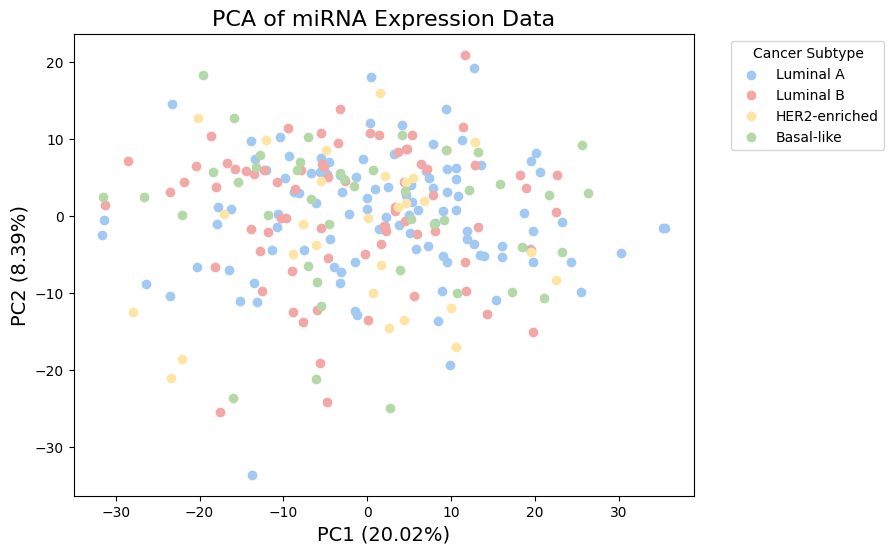

In [15]:

plt.figure(figsize=(8, 6))
for subtype in tumor_colors.keys():  
    subset = pca_df[pca_df['Tumor Subtype'] == subtype]
    plt.scatter(
        subset['PC1'], 
        subset['PC2'], 
        label=subtype, 
        color=tumor_colors[subtype] 
    )

plt.xlabel(f'PC1 ({explained_var_pc1:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_pc2:.2f}%)', fontsize=14)
plt.title('PCA of miRNA Expression Data', fontsize=16)

plt.legend(title='Cancer Subtype', bbox_to_anchor=(1.05, 1))

plt.show()


In [16]:
print("Counts of each subtype:")
print(pca_df['Tumor Subtype'].value_counts())

Counts of each subtype:
Tumor Subtype
Luminal A        106
Luminal B         73
Basal-like        43
HER2-enriched     29
Name: count, dtype: int64


**PCA with 4 components**

In [17]:
pca_4 = PCA(n_components=4)
features = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
principal_components_4 = pca_4.fit_transform(features)

pca_df_4comp = pd.DataFrame(data=principal_components_4, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_4comp['Tumor Subtype'] = subtype_list

explained_variance_4component = pca_4.explained_variance_ratio_
explained_variance_pc1 = pca_4.explained_variance_ratio_[0] * 100
explained_variance_pc2 = pca_4.explained_variance_ratio_[1] * 100
explained_variance_pc3 = pca_4.explained_variance_ratio_[2] * 100
explained_variance_pc4 = pca_4.explained_variance_ratio_[3] * 100
explained_variance_4component

array([0.20023308, 0.08393467, 0.07673032, 0.04402741])

In [18]:
pca_df_4comp

PC1        PC2        PC3        PC4 Tumor Subtype
0   -13.269574   6.328713   0.204362  -3.789177    Basal-like
1   -19.551472  18.294597   1.059434   3.478984    Basal-like
2    -1.613547   3.860401   4.567887  -0.980972    Basal-like
3     2.698754 -24.966739  11.134004 -13.225530    Basal-like
4   -11.884515   0.190040   3.764511   5.038363    Basal-like
..         ...        ...        ...        ...           ...
246   5.319731  10.544614   7.546819 -10.461376     Luminal B
247   5.601957 -10.313324  -6.815660   3.931710     Luminal B
248  -7.860923   5.957385 -10.284611  -3.071613     Luminal B
249  -3.510373   9.530883  -7.073051  -3.497104     Luminal B
250  13.171583  -1.483852   2.086440  -4.580875     Luminal B

[251 rows x 5 columns]

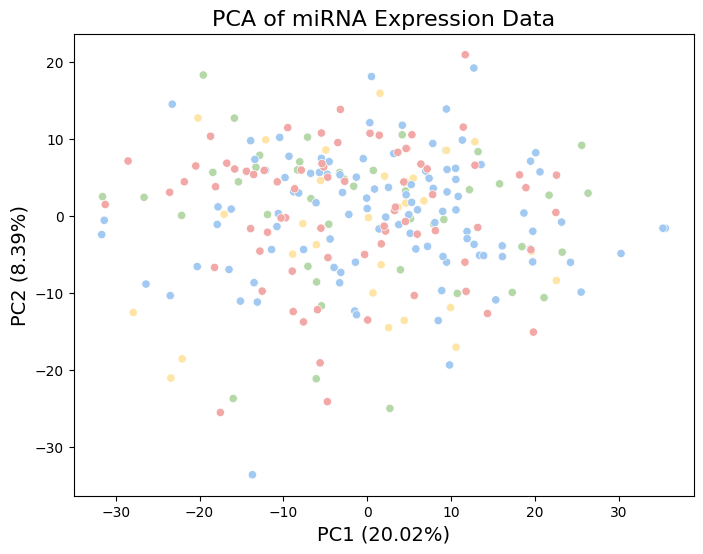

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, legend=False)
plt.title('PCA of miRNA Expression Data', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2:.2f}%)', fontsize=14)
plt.show()

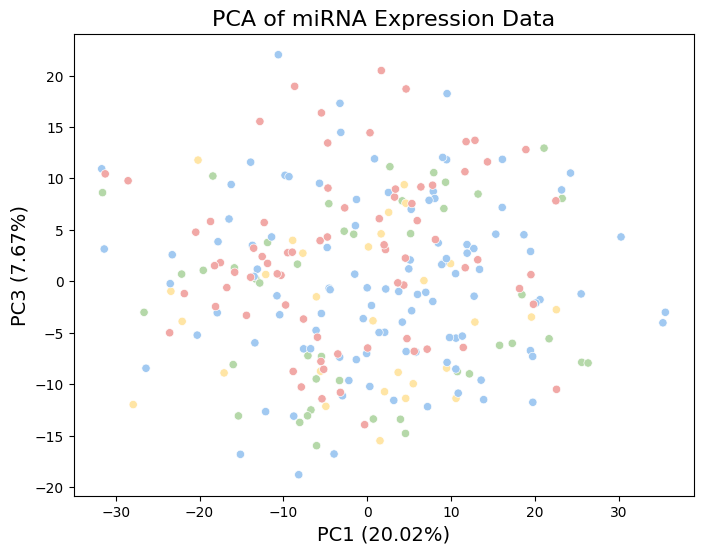

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, legend = False)

plt.title('PCA of miRNA Expression Data', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3:.2f}%)', fontsize=14)

plt.show()

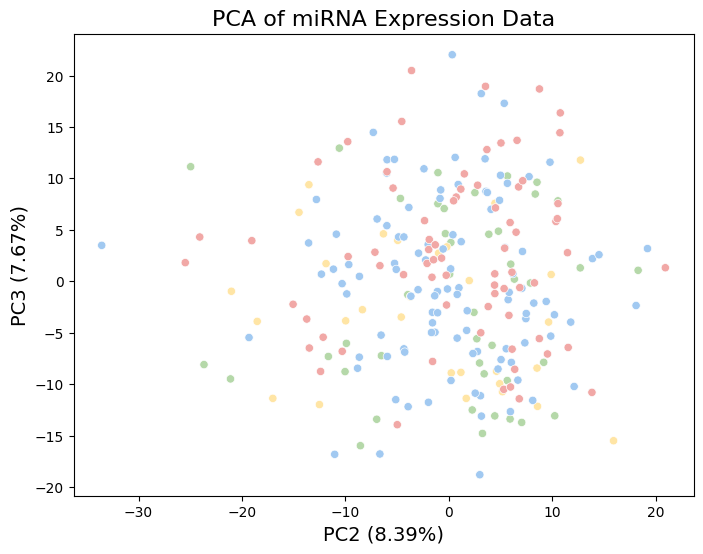

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df_4comp,
    x='PC2',
    y='PC3',
    hue='Tumor Subtype',
    palette=tumor_colors, 
    hue_order=subtype_order, legend = False,
)

plt.title('PCA of miRNA Expression Data', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3:.2f}%)', fontsize=14)

plt.show()

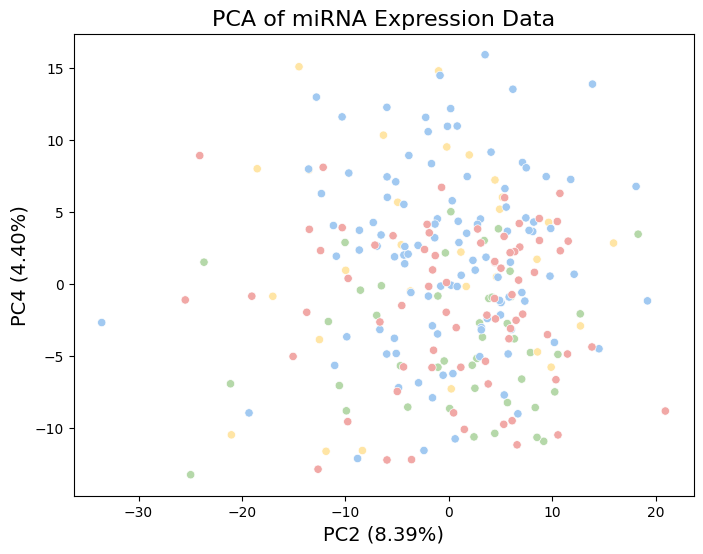

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df_4comp,
    x='PC2',
    y='PC4',
    hue='Tumor Subtype',
    palette=tumor_colors,
    hue_order=subtype_order, legend = False
)

plt.title('PCA of miRNA Expression Data', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4:.2f}%)', fontsize=14)
plt.show()

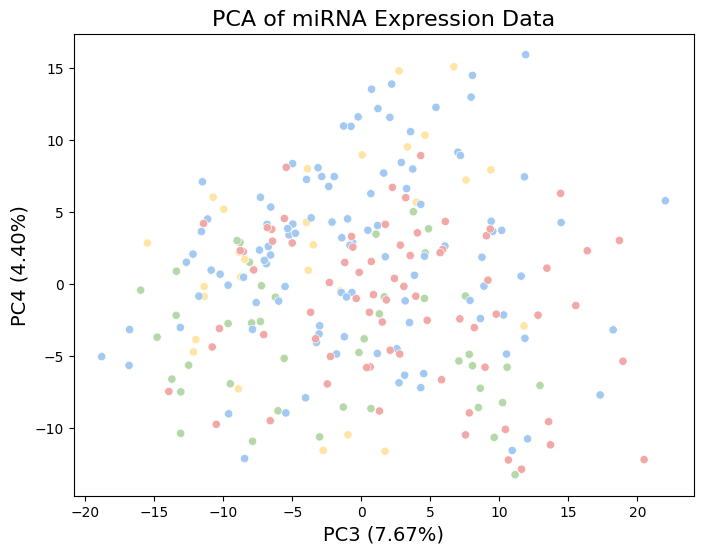

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df_4comp,
    x='PC3',
    y='PC4',
    hue='Tumor Subtype',
    palette=tumor_colors,
    hue_order=subtype_order, legend = False
)

plt.title('PCA of miRNA Expression Data', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4:.2f}%)', fontsize=14)
plt.show()

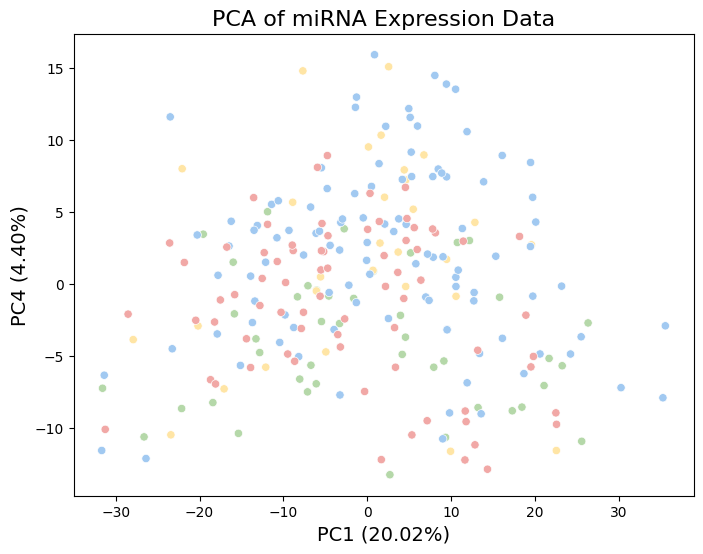

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df_4comp,
    x='PC1',
    y='PC4',
    hue='Tumor Subtype',
    palette=tumor_colors,
    hue_order=subtype_order, legend = False
)

plt.title('PCA of miRNA Expression Data', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4:.2f}%)', fontsize=14)
plt.show()

**PCA Scaled**

Since the first PCA did not reveal any difference among groups, we will try to scale the values.

In [25]:
#Scale values
scaler = StandardScaler()
tumor_subtypes = pca_df['Tumor Subtype']
pca_scaled = scaler.fit_transform(pca_df[['PC1', 'PC2']])
scaled_df = pd.DataFrame(pca_scaled, columns=['PC1', 'PC2'])
scaled_df['Tumor Subtype'] = tumor_subtypes

scaled_df


PC1       PC2 Tumor Subtype
0   -0.998898  0.735828    Basal-like
1   -1.471782  2.127082    Basal-like
2   -0.121463  0.448842    Basal-like
3    0.203155 -2.902841    Basal-like
4   -0.894634  0.022095    Basal-like
..        ...       ...           ...
246  0.400455  1.226004     Luminal B
247  0.421700 -1.199113     Luminal B
248 -0.591749  0.692655     Luminal B
249 -0.264251  1.108139     Luminal B
250  0.991521 -0.172525     Luminal B

[251 rows x 3 columns]

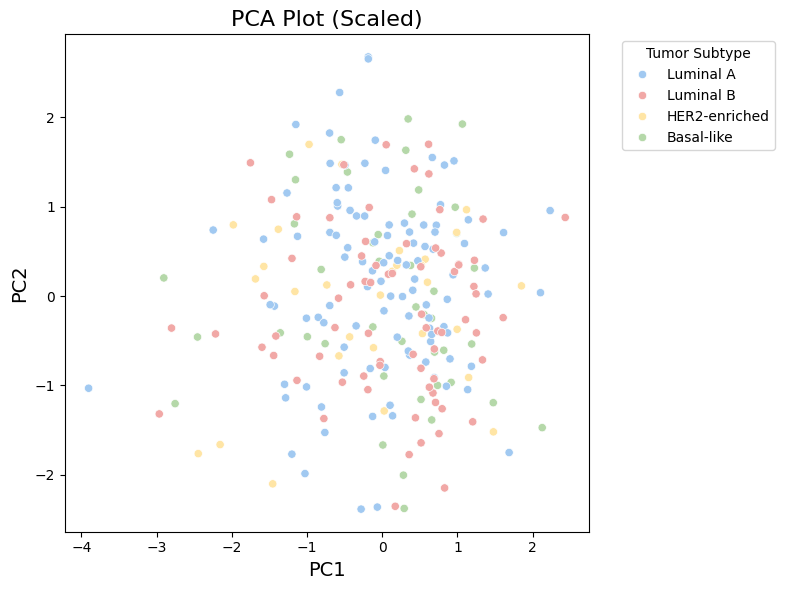

In [26]:
#PCA
tumor_colors = {
    'Luminal A': '#A1C9F1',  
    'Luminal B': '#F1A8A6', 
    'HER2-enriched': '#FFE5A5',
    'Basal-like': '#B5D8A9', 
}
subtype_order = ['Luminal A', 'Luminal B', 'HER2-enriched', 'Basal-like']

pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_scaled)

pca_df = pd.DataFrame(
    principal_components, columns=['PC1', 'PC2']
)
pca_df['Tumor Subtype'] = scaled_df['Tumor Subtype']  

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Tumor Subtype',
    palette=tumor_colors,
    hue_order=subtype_order 
)

plt.title('PCA Plot (Scaled)', fontsize=16)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.legend(title='Tumor Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

**Hierarchical Clustering - Heatmap and dendogram**

In [27]:
# Prepare Data
miRNA_expression_df = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
numeric_columns = miRNA_expression_df.select_dtypes(include=['object']).columns
miRNA_expression_df[numeric_columns] = miRNA_expression_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [28]:
# Hierarchical clustering
numeric_data = miRNA_expression_df.select_dtypes(include=['number'])   # checked for null values - False (no NA values)
transposed_numeric_df = numeric_data.T #transposed df
Z = linkage(transposed_numeric_df, method='single')  # Clustering linkage for rows


In [29]:
df = pd.DataFrame(numeric_data)

# Check for missing values
missing_values = df.isnull().any().any()
missing_values  #no NA (missing values)

np.False_

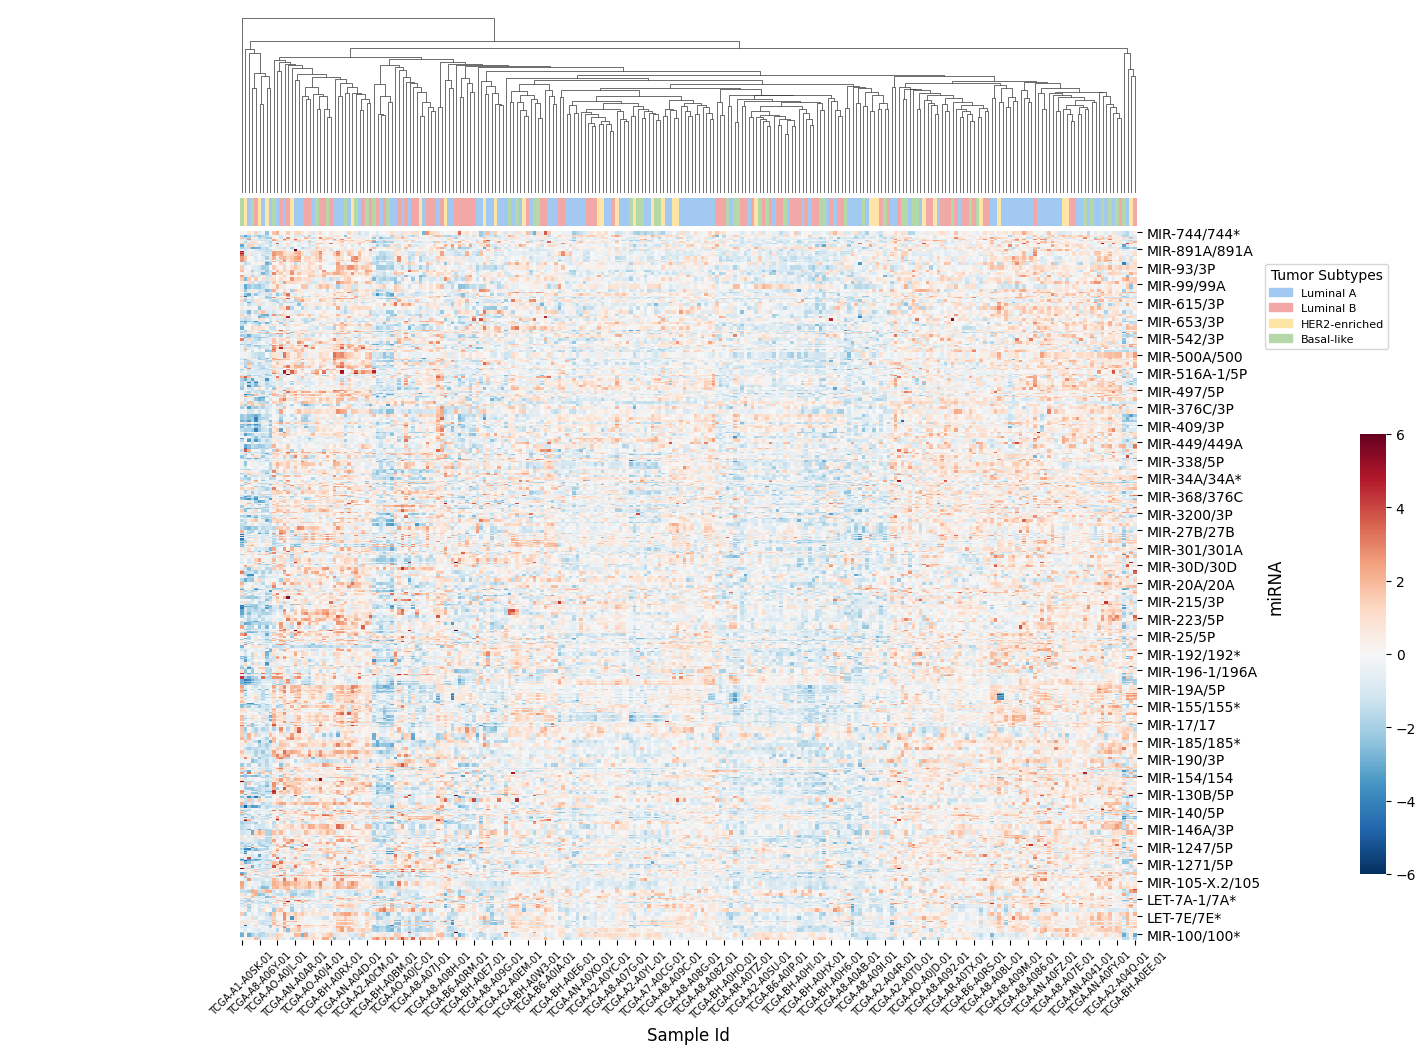

In [30]:
# Plot

# Colors for tumor subtypes
tumor_colors = {
    'Luminal A': '#A1C9F1',  
    'Luminal B': '#F1A8A6', 
    'HER2-enriched': '#FFE5A5',
    'Basal-like': '#B5D8A9', }

# Map colors
tumor_subtypes_list = subtype_list
xticklabels_colored = [tumor_colors.get(subtype, 'black') for subtype in tumor_subtypes_list]

# Recompute Z for columns
Z = linkage(transposed_numeric_df.T, method='average')
vmin, vmax = -6, 6

# Create the clustermap
g = sns.clustermap(
    transposed_numeric_df,
    row_cluster=False,      
    col_cluster=True,       
    col_linkage=Z,          
    figsize=(13, 11),
    cmap='RdBu_r',             # Heatmap color palette
    metric='euclidean',     
    annot=False,            
    cbar_pos=(1.05, 0.2, 0.02, 0.4), 
    col_colors=xticklabels_colored,
    vmin=vmin,
    vmax=vmax,)

# Customize x-axis
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=7, rotation=45)
g.ax_heatmap.set_xlabel('Sample Id', fontsize=12)
g.ax_heatmap.set_ylabel('miRNA', fontsize=12)

# Add legend for tumor subtype colors
handles = [mpatches.Patch(color=color, label=label) for label, color in tumor_colors.items()]
plt.legend(
    handles=handles,
    loc='upper right',
    bbox_to_anchor=(1.3, 1.4), 
    title='Tumor Subtypes',
    fontsize=8)

plt.show()

In [31]:
print("Shape of transposed_numeric_df:", transposed_numeric_df.shape)
print("Length of xticklabels_colored:", len(xticklabels_colored))
print("Shape of Z:", Z.shape)

Shape of transposed_numeric_df: (888, 251)
Length of xticklabels_colored: 251
Shape of Z: (250, 4)


**Logistic Regression**

In [32]:
# Expression Table
expression_table = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
expression_table

hugoGeneSymbol  MIR-744/744* MIR-744/744 MIR-744/3P MIR-744/5P MIR-758/758  \
TCGA-A1-A0SE-01       0.2973      0.2973     0.2973     0.2973      0.2044   
TCGA-A1-A0SH-01      -0.3408     -0.3408    -0.3408    -0.3408      1.4946   
TCGA-A1-A0SJ-01      -1.6876     -1.6876    -1.6876    -1.6876     -0.0618   
TCGA-A1-A0SK-01       0.1988      0.1988     0.1988     0.1988     -1.9075   
TCGA-A1-A0SM-01      -0.0434     -0.0434    -0.0434    -0.0434      0.2237   
...                      ...         ...        ...        ...         ...   
TCGA-BH-A0RX-01       0.7017      0.7017     0.7017     0.7017     -0.4983   
TCGA-BH-A0W3-01       1.8394      1.8394     1.8394     1.8394      0.5237   
TCGA-BH-A0W4-01       0.1572      0.1572     0.1572     0.1572      1.2186   
TCGA-BH-A0W5-01       -0.346      -0.346     -0.346     -0.346      1.6539   
TCGA-BH-A0WA-01      -0.4576     -0.4576    -0.4576    -0.4576     -0.6798   

hugoGeneSymbol  MIR-758/3P MIR-758/5P MIR-766/766 MIR-766/3P MIR-766/5P  ...  \
TCGA-A1-A0SE-01     0.2044     0.2044       -0.34      -0.34      -0.34  ...   
TCGA-A1-A0SH-01     1.4946     1.4946      0.3319     0.3319     0.3319  ...   
TCGA-A1-A0SJ-01    -0.0618    -0.0618     -0.3762    -0.3762    -0.3762  ...   
TCGA-A1-A0SK-01    -1.9075    -1.9075      1.6355     1.6355     1.6355  ...   
TCGA-A1-A0SM-01     0.2237     0.2237     -0.3013    -0.3013    -0.3013  ...   
...                    ...        ...         ...        ...        ...  ...   
TCGA-BH-A0RX-01    -0.4983    -0.4983      1.4496     1.4496     1.4496  ...   
TCGA-BH-A0W3-01     0.5237     0.5237      0.8351     0.8351     0.8351  ...   
TCGA-BH-A0W4-01     1.2186     1.2186     -0.5868    -0.5868    -0.5868  ...   
TCGA-BH-A0W5-01     1.6539     1.6539      0.4046     0.4046     0.4046  ...   
TCGA-BH-A0WA-01    -0.6798    -0.6798     -0.4676    -0.4676    -0.4676  ...   

hugoGeneSymbol  MIR-1-1/1 MIR-1-2/1 MIR-100/100* MIR-100/100 MIR-100/3P  \
TCGA-A1-A0SE-01    0.8994    0.8994       0.9122      0.9122     0.9122   
TCGA-A1-A0SH-01    0.6157    0.6157        1.286       1.286      1.286   
TCGA-A1-A0SJ-01    2.2474    2.2474       0.4609      0.4609     0.4609   
TCGA-A1-A0SK-01   -2.2687   -2.2687      -2.8709     -2.8709    -2.8709   
TCGA-A1-A0SM-01   -1.1549   -1.1549      -0.1348     -0.1348    -0.1348   
...                   ...       ...          ...         ...        ...   
TCGA-BH-A0RX-01    1.1383    1.1383       1.8132      1.8132     1.8132   
TCGA-BH-A0W3-01    0.0489    0.0489       0.3105      0.3105     0.3105   
TCGA-BH-A0W4-01   -2.0282   -2.0282       1.2752      1.2752     1.2752   
TCGA-BH-A0W5-01    0.0942    0.0942       1.1475      1.1475     1.1475   
TCGA-BH-A0WA-01   -0.7033   -0.7033       1.6519      1.6519     1.6519   

hugoGeneSymbol  MIR-100/5P MIR-100-11/100 MIR-101/101 MIR-101/3P MIR-101/5P  
TCGA-A1-A0SE-01     0.9122         0.9122      1.8203     1.8203     1.8203  
TCGA-A1-A0SH-01      1.286          1.286     -0.5674    -0.5674    -0.5674  
TCGA-A1-A0SJ-01     0.4609         0.4609      0.4688     0.4688     0.4688  
TCGA-A1-A0SK-01    -2.8709        -2.8709     -0.1298    -0.1298    -0.1298  
TCGA-A1-A0SM-01    -0.1348        -0.1348     -0.9285    -0.9285    -0.9285  
...                    ...            ...         ...        ...        ...  
TCGA-BH-A0RX-01     1.8132         1.8132      1.0432     1.0432     1.0432  
TCGA-BH-A0W3-01     0.3105         0.3105      0.2707     0.2707     0.2707  
TCGA-BH-A0W4-01     1.2752         1.2752       0.374      0.374      0.374  
TCGA-BH-A0W5-01     1.1475         1.1475      1.0245     1.0245     1.0245  
TCGA-BH-A0WA-01     1.6519         1.6519     -1.1131    -1.1131    -1.1131  

[251 rows x 888 columns]

In [33]:
# clinical data
clinical_data_sample_subtype = clinical_subtype_extracted_df.drop(columns=[col for col in clinical_subtype_extracted_df.columns if col not in ['sampleId', 'PAM50_SUBTYPE']])
clinical_data_sample_subtype = clinical_data_sample_subtype.set_index('sampleId')

#asserting if the indexes match - sampleId are the same on the two df
common_indices = expression_table.index.intersection(clinical_data_sample_subtype.index)
expression_table = expression_table.loc[common_indices]
clinical_data_sample_subtype = clinical_data_sample_subtype.loc[common_indices]

clinical_data_sample_subtype

PAM50_SUBTYPE
TCGA-A1-A0SE-01     Luminal A
TCGA-A1-A0SH-01     Luminal A
TCGA-A1-A0SJ-01     Luminal A
TCGA-A1-A0SK-01    Basal-like
TCGA-A1-A0SM-01     Luminal B
...                       ...
TCGA-BH-A0RX-01    Basal-like
TCGA-BH-A0W3-01     Luminal B
TCGA-BH-A0W4-01     Luminal A
TCGA-BH-A0W5-01     Luminal A
TCGA-BH-A0WA-01    Basal-like

[251 rows x 1 columns]

In [34]:
# Assure sample Id aligns to tumor subtype
assert expression_table.index.equals(clinical_data_sample_subtype.index)   # it aligns 

In [35]:
# Vectors - x is features and y is target
x = expression_table
y = clinical_data_sample_subtype.squeeze()

# Split into training tests
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# L1 Regularization
model_l1 = LogisticRegression(penalty='l1', C=0.01, solver='saga', random_state=42, multi_class='multinomial', max_iter=1000)    # c is the penalty - it is between 0 and 1 
model_l1.fit(X_train, y_train)


c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   penalty='l1', random_state=42, solver='saga')

In [36]:
# L2 Regularization
model_l2 = LogisticRegression(penalty='l2', C=0.01, solver='saga', random_state=42, multi_class='multinomial')
model_l2.fit(X_train, y_train)

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.01, multi_class='multinomial', random_state=42,
                   solver='saga')

In [37]:
class_labels = model_l1.classes_
print(class_labels)

['Basal-like' 'HER2-enriched' 'Luminal A' 'Luminal B']


In [38]:
# ROC AUC Score for L1-regularized model
y_predic_proba_l1 = model_l1.predict_proba(X_test)
roc_auc_l1 = roc_auc_score(y_test, y_predic_proba_l1, multi_class='ovr')
print("L1 Regularization ROC AUC Score:", roc_auc_l1)

# ROC AUC Score for L2-regularized model
y_predic_proba_l2 = model_l2.predict_proba(X_test)
roc_auc_l2 = roc_auc_score(y_test, y_predic_proba_l2, multi_class='ovr')
print("L2 Regularization ROC AUC Score:", roc_auc_l2)

L1 Regularization ROC AUC Score: 0.5
L2 Regularization ROC AUC Score: 0.9549137402967028


In [39]:
# Retrieving miRNAs for L1
coefficients = model_l1.coef_[0]  
selected_indices = [i for i, coef in enumerate(coefficients) if coef != 0]

miRNA_names = expression_table.columns.tolist()
selected_miRNAs = [miRNA_names[i] for i in selected_indices]
len(selected_miRNAs)


0

In [40]:
# Retrieving miRNas for L2
coefficients_l2 = model_l2.coef_[0]  
selected_indices_l2 = [i for i, coef in enumerate(coefficients_l2) if coef != 0 and coef > 0]  # this L2 had many coef < 0

miRNA_names_l2 = expression_table.columns.tolist()
selected_miRNAs_l2 = [miRNA_names_l2[i] for i in selected_indices_l2]  # we have 400 something coefficients out of the 888 miRNA - depending on the c
len(selected_miRNAs_l2)

496

Code above was a trial to do one logistic model.
The following code is the one analysed and studied in the report.

In [41]:
## All the models on the ROC Curve - multi_class = multinomial

x = expression_table
y = clinical_data_sample_subtype.squeeze()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)       # y-test are the true labels and y_pred are the predicted labels

## L1 models

model_l1_c1 = LogisticRegression(penalty='l1', solver='saga', C=0.001, random_state=42, multi_class='multinomial', max_iter=10000)
model_l1_c1.fit(X_train, y_train)

model_l1_c2 = LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=42, multi_class='multinomial', max_iter=10000)
model_l1_c2.fit(X_train, y_train)

model_l1_c3 = LogisticRegression(penalty='l1', solver='saga', C=0.4, random_state=42, multi_class='multinomial', max_iter=10000)
model_l1_c3.fit(X_train, y_train)

model_l1_c4 = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=42, multi_class='multinomial', max_iter=10000)
model_l1_c4.fit(X_train, y_train)

model_l1_c5 = LogisticRegression(penalty='l1', solver='saga', C=0.7, random_state=42, multi_class='multinomial', max_iter=10000)
model_l1_c5.fit(X_train, y_train)

model_l1_c6 = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=42, multi_class='multinomial', max_iter=10000)
model_l1_c6.fit(X_train, y_train)

## now the L2 models

model_l2_c1 = LogisticRegression(penalty='l2', solver='saga', C=0.001, random_state=42, multi_class='multinomial', max_iter=10000)
model_l2_c1.fit(X_train, y_train)

model_l2_c2 = LogisticRegression(penalty='l2', solver='saga', C=0.1, random_state=42, multi_class='multinomial', max_iter=10000)
model_l2_c2.fit(X_train, y_train)

model_l2_c3 = LogisticRegression(penalty='l2', solver='saga', C=0.4, random_state=42, multi_class='multinomial', max_iter=10000)
model_l2_c3.fit(X_train, y_train)

model_l2_c4 = LogisticRegression(penalty='l2', solver='saga', C=0.5, random_state=42, multi_class='multinomial', max_iter=10000)
model_l2_c4.fit(X_train, y_train)

model_l2_c5 = LogisticRegression(penalty='l2', solver='saga', C=0.7, random_state=42, multi_class='multinomial', max_iter=10000)
model_l2_c5.fit(X_train, y_train)

model_l2_c6 = LogisticRegression(penalty='l2', solver='saga', C=10, random_state=42, multi_class='multinomial', max_iter=10000)
model_l2_c6.fit(X_train, y_train)

models = [model_l1_c1, model_l1_c2, model_l1_c3, model_l1_c4, model_l1_c5, model_l1_c6, model_l2_c1, model_l2_c2, model_l2_c3, model_l2_c4, model_l2_c5, model_l2_c6]

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:124

In [42]:
# Confusion matrices and classification report for different models

roc_data_cm = {} #confusion matrix
roc_data_y_pred = {}
roc_data_cr = {} #classification report
roc_data_y_score = {}
roc_data_auc = {}

for model in models[0:]:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    y_score = model.predict_proba(X_test)
    roc_auc_scores = roc_auc_score(y_test, y_score, multi_class='ovr')

    roc_data_cm[model] = cm
    roc_data_y_pred[model] = y_pred
    roc_data_cr[model] = cr
    roc_data_y_score[model] = y_score
    roc_data_auc[model] = roc_auc_scores

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [43]:
# Labels for the ROC curves

models_label = [(model_l1_c1, 'L1 (C = 0.001)'),(model_l1_c2, 'L1 (C = 0.1)'),
    (model_l1_c3, 'L1 (C = 0.4)'),(model_l1_c4, 'L1 (C = 0.5)'),
    (model_l1_c5, 'L1 (C = 0.7)'),(model_l1_c6, 'L1 (C = 1)'),
    (model_l2_c1, 'L2 (C = 0.001)'),(model_l2_c2, 'L2 (C = 0.1)'),
    (model_l2_c3, 'L2 (C = 0.4)'),(model_l2_c4, 'L2 (C = 0.5)'),
    (model_l2_c5, 'L2 (C = 0.7)'),(model_l2_c6, 'L2 (C = 10)')]

model_names = ['L1 (C = 0.001)','L1 (C = 0.1)','L1 (C = 0.4)','L1 (C = 0.5)',
    'L1 (C = 0.7)','L1 (C = 1)','L2 (C = 0.001)','L2 (C = 0.1)',
    'L2 (C = 0.4)','L2 (C = 0.5)','L2 (C = 0.7)','L2 (C = 10)']


C:\Users\marga\AppData\Local\Temp\ipykernel_820\3797892950.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")


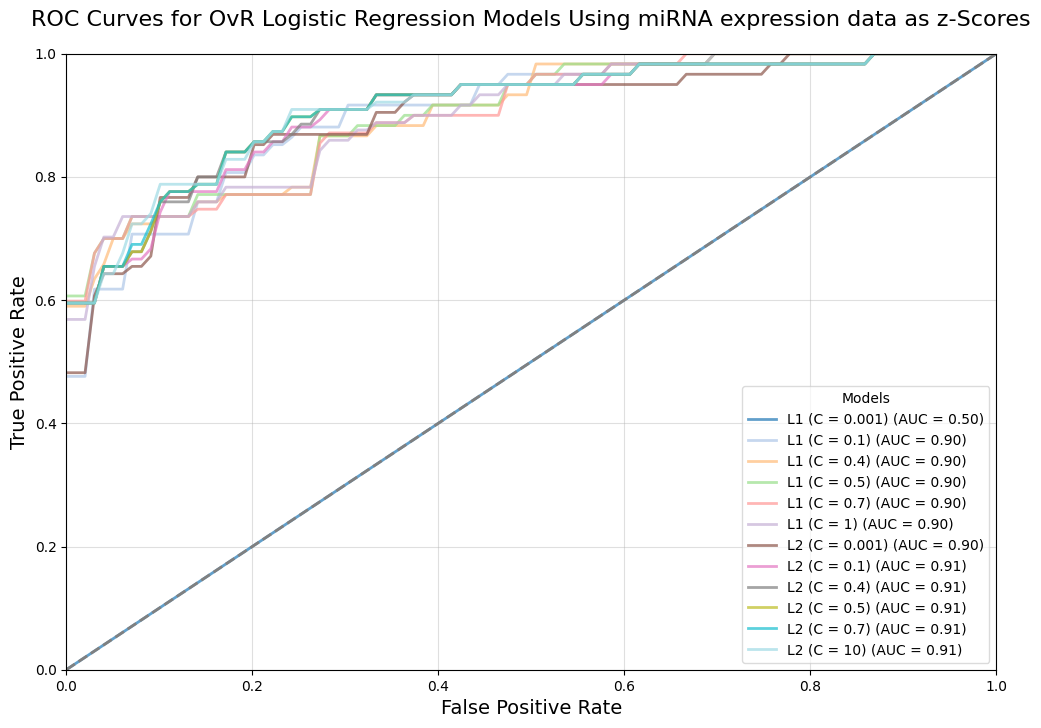

In [ ]:
## ALL ROC CURVES

classes = list(set(y_test))  # cancer subtypes
n_classes = len(classes)

# Binarize the labels (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=classes)

roc_curves = {}

# Loop through all models and model names
for model, model_name in zip(models, model_names):
    y_score = model.predict_proba(X_test)  # Predicted probabilities for each class
    
    fpr = {}
    tpr = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # ROC for class 
        sorted_idx = np.argsort(fpr[i])  
        fpr[i], tpr[i] = fpr[i][sorted_idx], tpr[i][sorted_idx]

    # Calculate the mean ROC curve (average across all classes)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    mean_auc = roc_data_auc[model]
    
    # Store the mean ROC curve data for the model
    roc_curves[model_name] = (mean_fpr, mean_tpr, mean_auc)

colormap = get_cmap("tab20")
colors = [colormap(i) for i in np.linspace(0, 1, len(roc_curves))]
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr, mean_tpr, mean_auc)) in enumerate(roc_curves.items()):
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{model_name} (AUC = {mean_auc:.2f})", color=colors[idx], alpha=0.7)

# diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for OvR Logistic Regression Models Using miRNA expression data as z-Scores", fontsize=16, pad = 20)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title = 'Models')
plt.grid(alpha=0.4)
plt.show()


C:\Users\marga\AppData\Local\Temp\ipykernel_820\1865954577.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")  # Tab20 provides up to 20 distinct colors


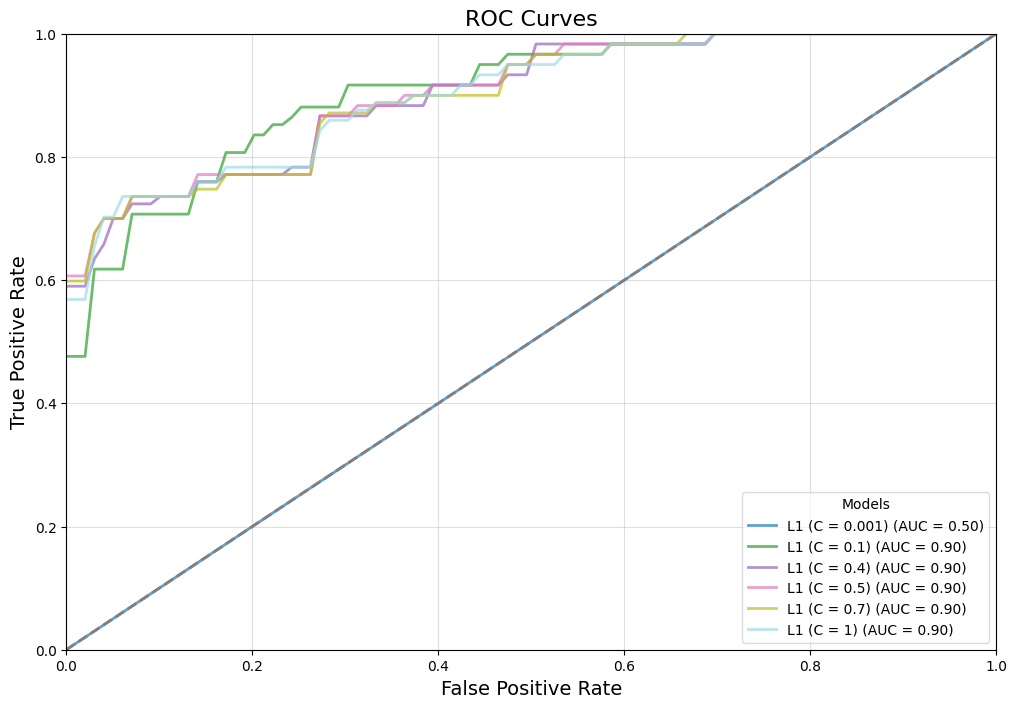

In [45]:
## ROC CURVES   -------------- L1

classes = list(set(y_test))  # cancer subtypes
n_classes = len(classes)

# Binarize the labels (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=classes)

roc_curves = {}

# Loop through all models and model names
for model, model_name in zip(models[:6], model_names[:6]):
    y_score = model.predict_proba(X_test)  # Predicted probabilities for each class
    
    fpr = {}
    tpr = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # ROC for class 
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    mean_auc = roc_data_auc[model]
    
    # Store the mean ROC curve data for the model
    roc_curves[model_name] = (mean_fpr, mean_tpr, mean_auc)

colormap = get_cmap("tab20")  # Tab20 provides up to 20 distinct colors
colors = [colormap(i) for i in np.linspace(0, 1, len(roc_curves))]
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr, mean_tpr, mean_auc)) in enumerate(roc_curves.items()):
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{model_name} (AUC = {mean_auc:.2f})", color=colors[idx], alpha=0.7)

# diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title = 'Models')
plt.grid(alpha=0.4)
plt.show()

C:\Users\marga\AppData\Local\Temp\ipykernel_820\625530960.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")  # Tab20 provides up to 20 distinct colors


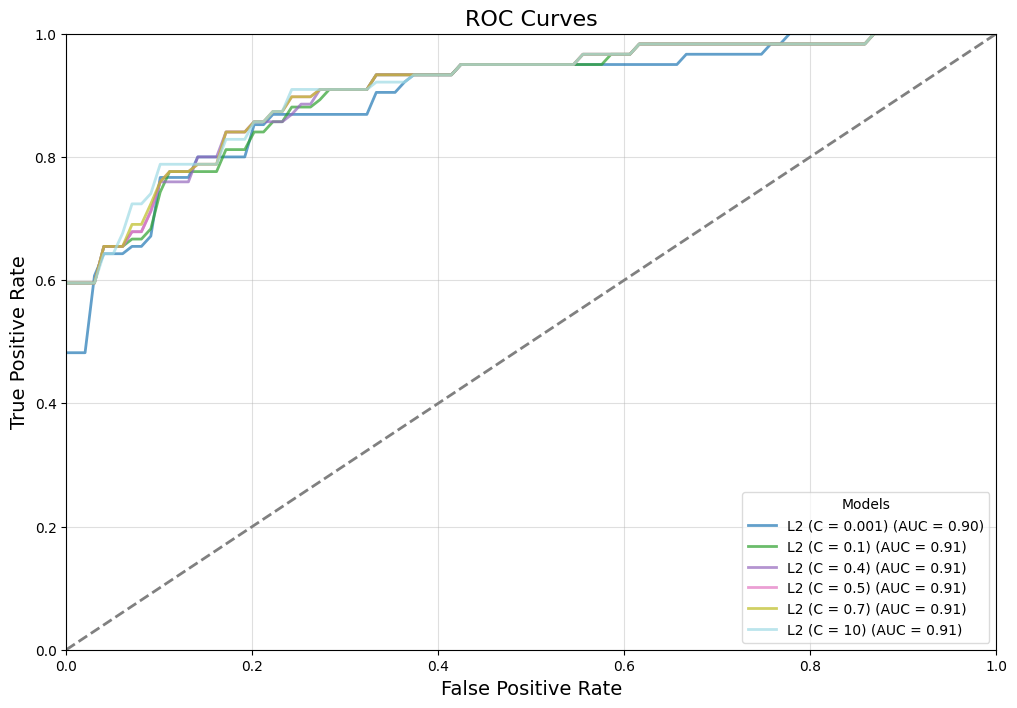

In [46]:
## ROC CURVES   -------------- L2

classes = list(set(y_test))  # cancer subtypes
n_classes = len(classes)

# Binarize the labels (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=classes)

roc_curves = {}

# Loop through all models and model names
for model, model_name in zip(models[6:], model_names[6:]):
    y_score = model.predict_proba(X_test)  # Predicted probabilities for each class
    
    fpr = {}
    tpr = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # ROC for class 
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    mean_auc = roc_data_auc[model]
    
    # Store the mean ROC curve data for the model
    roc_curves[model_name] = (mean_fpr, mean_tpr, mean_auc)

colormap = get_cmap("tab20")  # Tab20 provides up to 20 distinct colors
colors = [colormap(i) for i in np.linspace(0, 1, len(roc_curves))]
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr, mean_tpr, mean_auc)) in enumerate(roc_curves.items()):
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{model_name} (AUC = {mean_auc:.2f})", color=colors[idx], alpha=0.7)

# diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title = 'Models')
plt.grid(alpha=0.4)
plt.show()

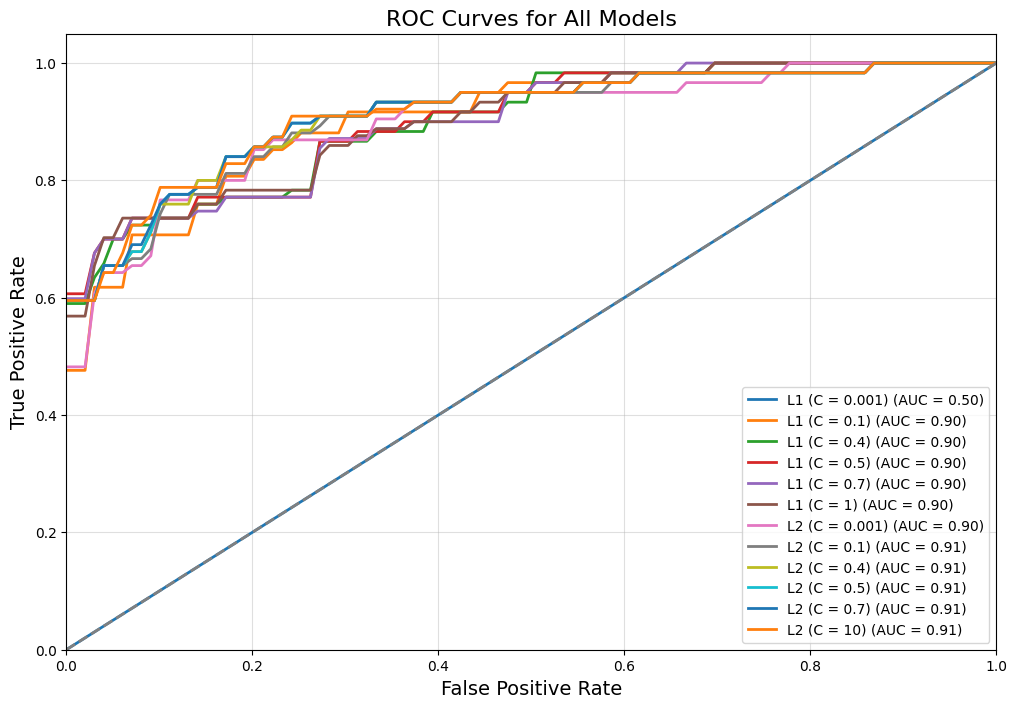

In [47]:
###### This one was without the OVR (one versus the rest)

classes = list(set(y_test))
n_classes = len(classes)

# Binarize the labels (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=classes)

roc_curves = {}

# Loop through models and their corresponding names
for model, model_name in zip(models, model_names):
    # Get predicted probabilities for each class (probabilities for each class)
    y_score = model.predict_proba(X_test)  # Shape: (n_samples, n_classes)
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # ROC for class i
        roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for class i
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
    mean_auc = np.mean(list(roc_auc.values()))
    
    # Store the mean ROC curve data for the model
    roc_curves[model_name] = (mean_fpr, mean_tpr, mean_auc)
    
# Plot the ROC curves for all models
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for model_name, (mean_fpr, mean_tpr, mean_auc) in roc_curves.items():
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{model_name} (AUC = {mean_auc:.2f})")

# Add diagonal line for reference (random guessing)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for All Models", fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.4)
plt.show()

In [48]:
# Choosing which one to use L1
print(roc_data_cr[model_l1_c1]) # AUC is 0.5, so no
print(roc_data_cr[model_l1_c2]) # when compared to c3, c3 is better
print(roc_data_cr[model_l1_c3]) # When compared to c4, c3 is better
print(roc_data_cr[model_l1_c4]) # when compared to c3, c3 is better
print(roc_data_cr[model_l1_c5]) # when compared to c3, c3 is better
print(roc_data_cr[model_l1_c6]) # when comapred to c3, c3 is better               # Conclusion : chose L1 C = 0.4

               precision    recall  f1-score   support

   Basal-like       0.00      0.00      0.00         9
HER2-enriched       0.00      0.00      0.00         6
    Luminal A       0.41      1.00      0.58        21
    Luminal B       0.00      0.00      0.00        15

     accuracy                           0.41        51
    macro avg       0.10      0.25      0.15        51
 weighted avg       0.17      0.41      0.24        51

               precision    recall  f1-score   support

   Basal-like       0.90      1.00      0.95         9
HER2-enriched       1.00      0.33      0.50         6
    Luminal A       0.70      1.00      0.82        21
    Luminal B       0.67      0.40      0.50        15

     accuracy                           0.75        51
    macro avg       0.82      0.68      0.69        51
 weighted avg       0.76      0.75      0.71        51

               precision    recall  f1-score   support

   Basal-like       0.90      1.00      0.95         9
HER

In [49]:
# Choosing which one to use L2
print(roc_data_cr[model_l2_c1]) # When compared to c2, c2 is better 
print(roc_data_cr[model_l2_c2]) # When compared to c3, c2 is better 
print(roc_data_cr[model_l2_c3]) # When compared to c2, c2 is better
print(roc_data_cr[model_l2_c4]) # When compared to c2, c2 is better
print(roc_data_cr[model_l2_c5]) # When compared to c2, c2 is better
print(roc_data_cr[model_l2_c6]) # When compared to c2, c2 is better                # Conclusion : chose L2 C = 0.1

               precision    recall  f1-score   support

   Basal-like       1.00      1.00      1.00         9
HER2-enriched       1.00      0.17      0.29         6
    Luminal A       0.64      1.00      0.78        21
    Luminal B       0.62      0.33      0.43        15

     accuracy                           0.71        51
    macro avg       0.82      0.63      0.62        51
 weighted avg       0.74      0.71      0.66        51

               precision    recall  f1-score   support

   Basal-like       1.00      1.00      1.00         9
HER2-enriched       1.00      1.00      1.00         6
    Luminal A       0.68      1.00      0.81        21
    Luminal B       1.00      0.33      0.50        15

     accuracy                           0.80        51
    macro avg       0.92      0.83      0.83        51
 weighted avg       0.87      0.80      0.77        51

               precision    recall  f1-score   support

   Basal-like       0.90      1.00      0.95         9
HER

In [50]:
# Retrieving a list with the selected miRNAs --- L1
coefficients_l1_c3 = model_l1_c3.coef_[0]  
selected_indices_l1_c3 = [i for i, coef in enumerate(coefficients_l1_c3) if coef != 0 and coef > 0]

miRNA_names_l1_c3 = expression_table.columns.tolist()
selected_miRNAs_l1_c3 = [miRNA_names_l1_c3[i] for i in selected_indices_l1_c3]  
len(selected_miRNAs_l1_c3)  

21

In [51]:
# Retrieving a list with the selected miRNAs --- L2
coefficients_l2_c2 = model_l2_c2.coef_[0]  
selected_indices_l2_c2 = [i for i, coef in enumerate(coefficients_l2_c2) if coef != 0 and coef > 0]

miRNA_names_l2_c2 = expression_table.columns.tolist()
selected_miRNAs_l2_c2 = [miRNA_names_l2_c2[i] for i in selected_indices_l2_c2]  
len(selected_miRNAs_l2_c2)

443

In [52]:
## Check if any of the MIR is in the literatrure

literature_mirna = ['MIR-10','MIR-29A','MIR-181A','MIR-223','MIR-652','MIR-93','MIR-18A','MIR-135B','MIR-718','MIR-4516','MIR-210','MIR-125b-5p','MIR-150',
                    'MIR-142-39','MIR-153','MIR-10B','MIR-26A','MIR-146A', 'MIR-183', 'MIR-200A', 'MIR-99A', 'MIR-17',
                    'MIR-155', 'let-7'] 

# MIR-183, MIR-200A, MIR-99A, MIR-17 * (article - the emerging role of miRNA clusters in BC)
#                                    * this one can be either up or down regulated
#'MIR-155', 'let-7' * book on breast cancer: https://doi.org/10.36255/exon-publications-breast-cancer-etiology chapter 3

def check_mirna_matches(selected_miRNAs, literature_miRNAs):
    matches = []
    for selected in selected_miRNAs:
        for lit in literature_miRNAs:
            if selected == lit:
                matches.append(selected)
            # Prefix match
            elif selected.startswith(lit):
                remainder = selected[len(lit):]
                if remainder == '' or re.match(r'^[-/*]', remainder):
                    matches.append(selected)
    return matches

matches_l1 = check_mirna_matches(selected_miRNAs_l1_c3, literature_mirna)
matches_l2 = check_mirna_matches(selected_miRNAs_l2_c2, literature_mirna)

print("Matching miRNAs L1:", matches_l1)
print("Matching miRNAs L2:", matches_l2)
print(len(matches_l1))
print(len(matches_l2))

Matching miRNAs L1: ['MIR-18A/18A*', 'MIR-18A/18A', 'MIR-18A/3P', 'MIR-18A/18;18A', 'MIR-18A/5P', 'MIR-135B/135B*', 'MIR-135B/135B', 'MIR-135B/3P', 'MIR-135B/5P']
Matching miRNAs L2: ['MIR-93/93*', 'MIR-93/93', 'MIR-93/3P', 'MIR-93/5P', 'MIR-93-1/93', 'MIR-93-7.1/93', 'MIR-99A/99A*', 'MIR-99A/99A', 'MIR-99A/3P', 'MIR-99A/5P', 'MIR-652/652', 'MIR-652/3P', 'MIR-652/5P', 'MIR-29A/29A', 'MIR-29A/29A*', 'MIR-29A/3P', 'MIR-29A/5P', 'MIR-223/223', 'MIR-223/223*', 'MIR-223/3P', 'MIR-223/5P', 'MIR-26A-1/1*', 'MIR-200A/200A', 'MIR-200A/200A*', 'MIR-200A/3P', 'MIR-200A/5P', 'MIR-17/17*', 'MIR-17/17', 'MIR-181A-2/2*', 'MIR-183/183*', 'MIR-183/183', 'MIR-183/3P', 'MIR-183/5P', 'MIR-18A/18A*', 'MIR-18A/18A', 'MIR-18A/3P', 'MIR-18A/18;18A', 'MIR-18A/5P', 'MIR-135B/135B*', 'MIR-135B/135B', 'MIR-135B/3P', 'MIR-135B/5P', 'MIR-146A/146A*', 'MIR-146A/146A', 'MIR-146A/146', 'MIR-146A/5P', 'MIR-146A/3P']
9
47


In [53]:
# PCA com L1

features_l1 = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0) # now we have to drop the miRNA (columns) to be left with 21 columns
features_l1 = features_l1[[col for col in selected_miRNAs_l1_c3 if col in features_l1]]

# Initialize PCA
pca_l1 = PCA(n_components=2)

pca_result_l1 = pca_l1.fit_transform(features_l1)

pca_df_l1 = pd.DataFrame(data=pca_result_l1, columns=['PC1', 'PC2'])

print("Explained variance ratio (percentage):", pca_l1.explained_variance_ratio_)    ### Values above 0.7 are good

explained_var = pca_l1.explained_variance_ratio_
explained_var_pc1_l1 = pca_l1.explained_variance_ratio_[0] * 100
explained_var_pc2_l1 = pca_l1.explained_variance_ratio_[1] * 100

Explained variance ratio (percentage): [0.57297252 0.14904846]


In [54]:
pca_df_l1['Tumor Subtype'] = subtype_list
pca_df_l1

PC1       PC2 Tumor Subtype
0   -2.358532  0.352352    Basal-like
1   -2.287649  0.509070    Basal-like
2   -1.775278  2.749411    Basal-like
3    9.936150 -5.159185    Basal-like
4    1.151019  1.760049    Basal-like
..        ...       ...           ...
246  4.704371  5.194471     Luminal B
247 -2.137431  0.368832     Luminal B
248 -0.604880  1.095965     Luminal B
249 -0.183344  1.545673     Luminal B
250  5.625720  1.868337     Luminal B

[251 rows x 3 columns]

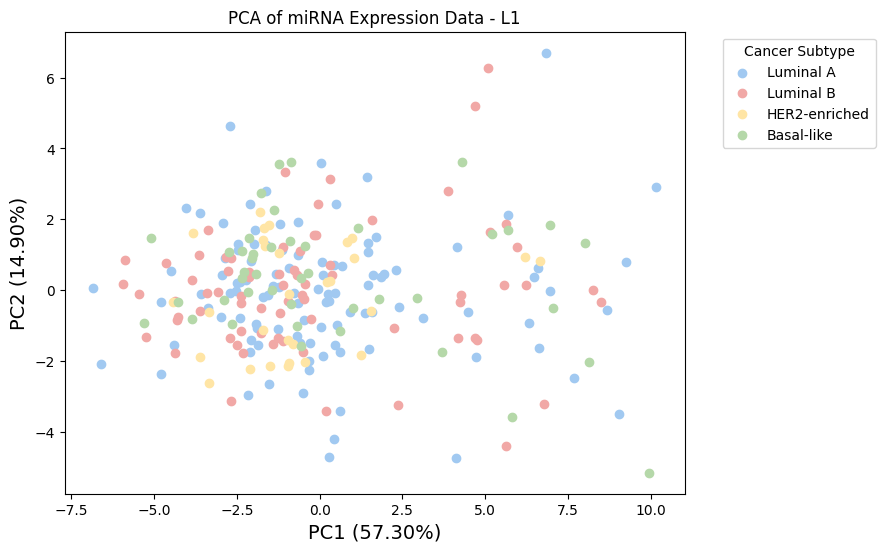

In [55]:
tumor_colors = {
    'Luminal A': '#A1C9F1', 
    'Luminal B': '#F1A8A6', 
    'HER2-enriched': '#FFE5A5',
    'Basal-like': '#B5D8A9',  
}

plt.figure(figsize=(8, 6))
for subtype in subtype_order:
    subset_l1 = pca_df_l1[pca_df_l1['Tumor Subtype'] == subtype]
    plt.scatter(subset_l1['PC1'], subset_l1['PC2'], label=subtype, color=tumor_colors[subtype])  # Apply custom colors

# Add plot titles and labels
plt.xlabel(f'PC1 ({explained_var_pc1_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_pc2_l1:.2f}%)', fontsize=14)
plt.title('PCA of miRNA Expression Data - L1')

plt.legend(title='Cancer Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [56]:
# PCA with L2

features_l2 = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0) # now we have to drop the miRNA (columns) to be left with 21 columns
features_l2 = features_l2[[col for col in selected_miRNAs_l2_c2 if col in features_l2]]

# Initialize PCA
pca_l2 = PCA(n_components=2) 

pca_result_l2 = pca_l2.fit_transform(features_l2)

pca_df_l2 = pd.DataFrame(data=pca_result_l2, columns=['PC1', 'PC2'])

print("Explained variance ratio (percentage):", pca_l2.explained_variance_ratio_)    ### Values above 0.7 are good

explained_var_l2 = pca_l2.explained_variance_ratio_
explained_var_pc1_l2 = pca_l2.explained_variance_ratio_[0] * 100
explained_var_pc2_l2 = pca_l1.explained_variance_ratio_[1] * 100

Explained variance ratio (percentage): [0.27246645 0.06560115]


In [57]:
pca_df_l2['Tumor Subtype'] = subtype_list
pca_df_l2

PC1        PC2 Tumor Subtype
0    -9.507605   4.189903    Basal-like
1   -15.556361   9.121404    Basal-like
2    -1.280995   3.996710    Basal-like
3    10.319711 -11.095317    Basal-like
4    -9.701952   1.377025    Basal-like
..         ...        ...           ...
246   7.906520   9.137127     Luminal B
247   2.156461  -5.970973     Luminal B
248  -7.003612   1.289807     Luminal B
249  -3.604945   3.365368     Luminal B
250  12.798397   2.059815     Luminal B

[251 rows x 3 columns]

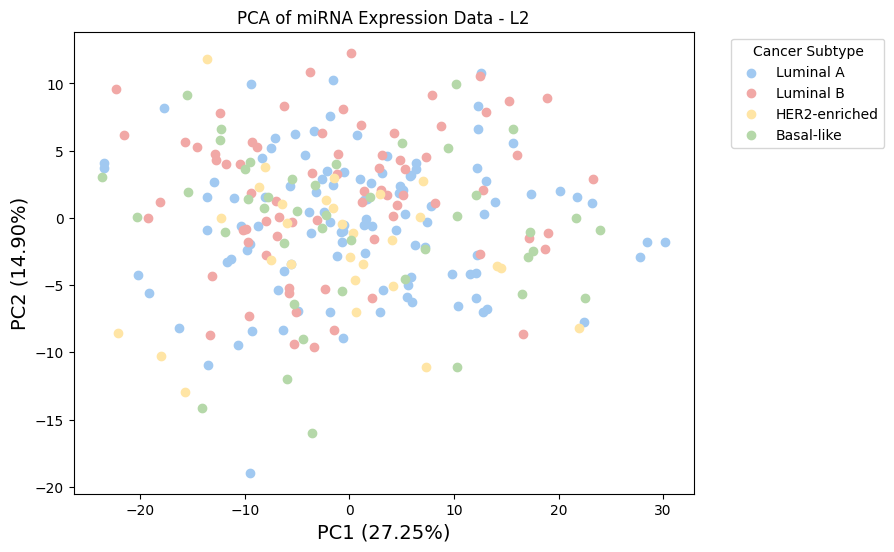

In [58]:
tumor_colors = {
    'Luminal A': '#A1C9F1', 
    'Luminal B': '#F1A8A6', 
    'HER2-enriched': '#FFE5A5',
    'Basal-like': '#B5D8A9',  
}
plt.figure(figsize=(8, 6))
for subtype in subtype_order: 
    subset_l2 = pca_df_l2[pca_df_l2['Tumor Subtype'] == subtype]
    plt.scatter(subset_l2['PC1'], subset_l2['PC2'], label=subtype, color=tumor_colors[subtype])

plt.xlabel(f'PC1 ({explained_var_pc1_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_pc2_l2:.2f}%)', fontsize=14)
plt.title('PCA of miRNA Expression Data - L2')

plt.legend(title='Cancer Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [59]:
## PCA with 4 components L1

pca_4_l1 = PCA(n_components=4)
features_l1_4comp = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_l1_4comp = features_l1_4comp[[col for col in selected_miRNAs_l1_c3 if col in features_l1_4comp]]
principal_components_4_l1 = pca_4_l1.fit_transform(features_l1_4comp)

pca_df_4comp_l1 = pd.DataFrame(data=principal_components_4_l1, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_4comp_l1['Tumor Subtype'] = subtype_list

explained_variance_4component_l1 = pca_4_l1.explained_variance_ratio_
explained_variance_pc1_l1_4 = pca_4_l1.explained_variance_ratio_[0] * 100
explained_variance_pc2_l1_4 = pca_4_l1.explained_variance_ratio_[1] * 100
explained_variance_pc3_l1_4 = pca_4_l1.explained_variance_ratio_[2] * 100
explained_variance_pc4_l1_4 = pca_4_l1.explained_variance_ratio_[3] * 100
explained_variance_4component_l1

array([0.57297252, 0.14904846, 0.11074032, 0.0756285 ])

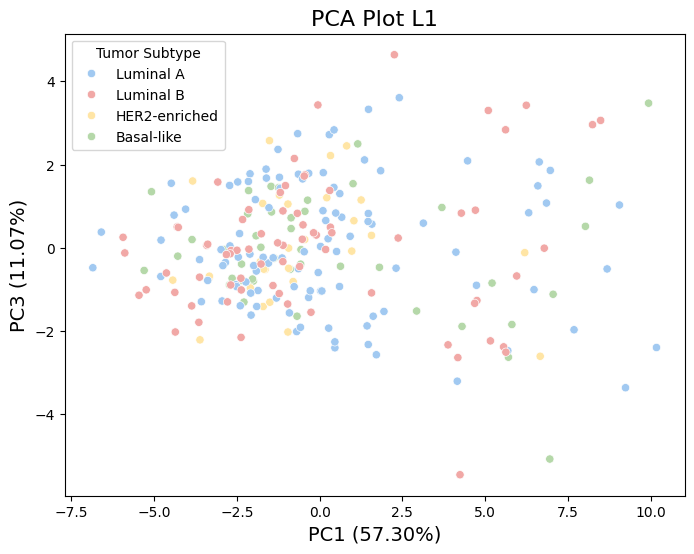

In [60]:
tumor_colors = {
    'Luminal A': '#A1C9F1', 
    'Luminal B': '#F1A8A6', 
    'HER2-enriched': '#FFE5A5',
    'Basal-like': '#B5D8A9',  
}
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l1, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_l1_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_l1_4:.2f}%)', fontsize=14)

plt.show()

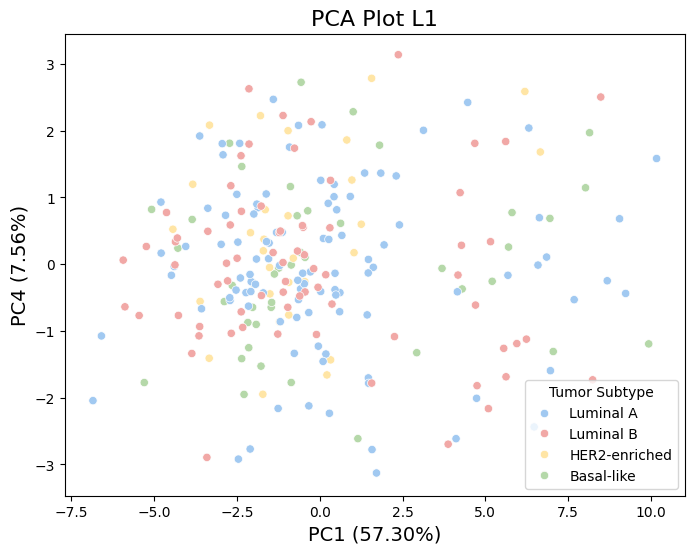

In [61]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l1, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_l1_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_l1_4:.2f}%)', fontsize=14)

plt.show()

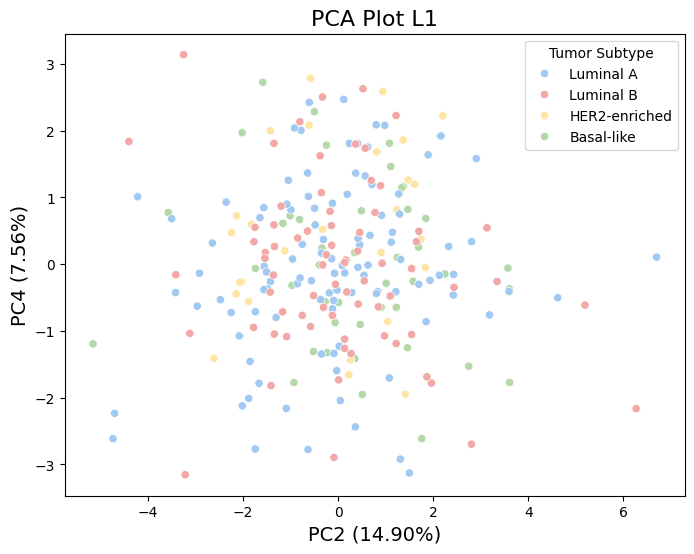

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l1, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_l1_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_l1_4:.2f}%)', fontsize=14)

plt.show()

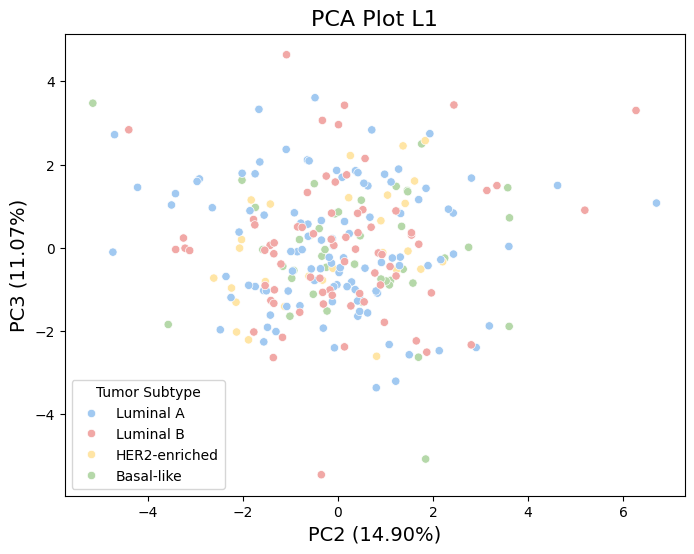

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l1, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_l1_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_l1_4:.2f}%)', fontsize=14)

plt.show()

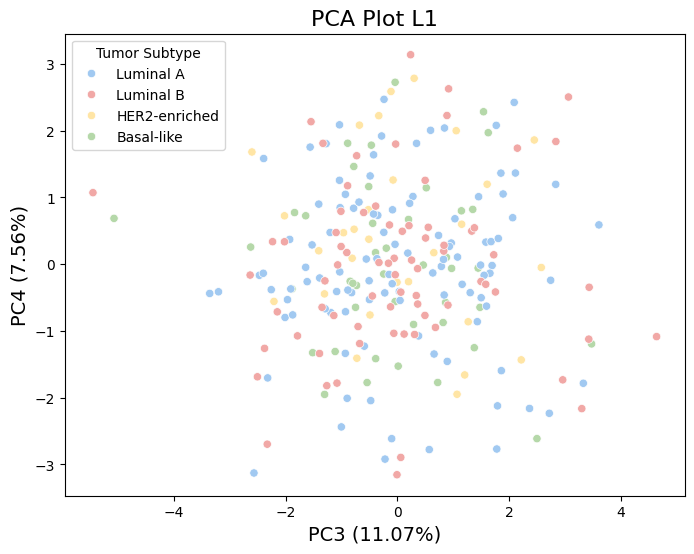

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l1, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3_l1_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_l1_4:.2f}%)', fontsize=14)

plt.show()

In [65]:
## PCA with 4 components L2

pca_4_l2 = PCA(n_components=4)
features_l2_4comp = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_l2_4comp = features_l2_4comp[[col for col in selected_miRNAs_l2_c2 if col in features_l2_4comp]]
principal_components_4_l2 = pca_4_l2.fit_transform(features_l2_4comp)


pca_df_4comp_l2 = pd.DataFrame(data=principal_components_4_l2, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_4comp_l2['Tumor Subtype'] = subtype_list

explained_variance_4component_l2 = pca_4_l2.explained_variance_ratio_
explained_variance_pc1_l2_4 = pca_4_l2.explained_variance_ratio_[0] * 100
explained_variance_pc2_l2_4 = pca_4_l2.explained_variance_ratio_[1] * 100
explained_variance_pc3_l2_4 = pca_4_l2.explained_variance_ratio_[2] * 100
explained_variance_pc4_l2_4 = pca_4_l2.explained_variance_ratio_[3] * 100
explained_variance_4component_l2

array([0.27246645, 0.06560115, 0.06352995, 0.03388894])

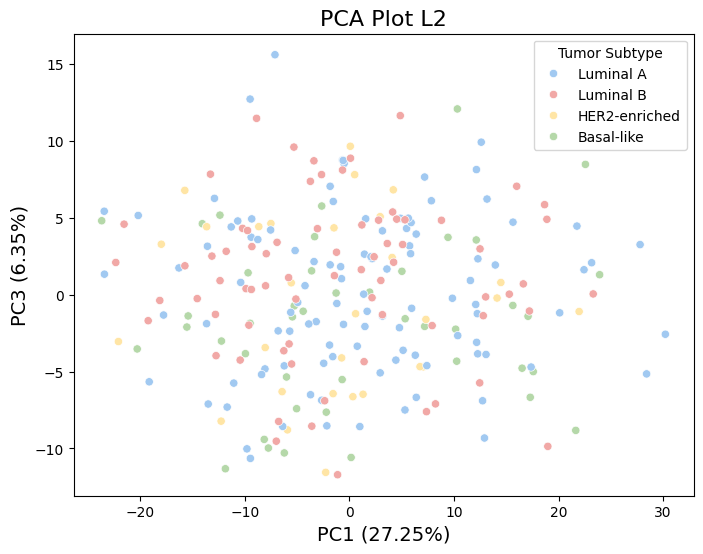

In [66]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l2, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L2', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_l2_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_l2_4:.2f}%)', fontsize=14)

plt.show()

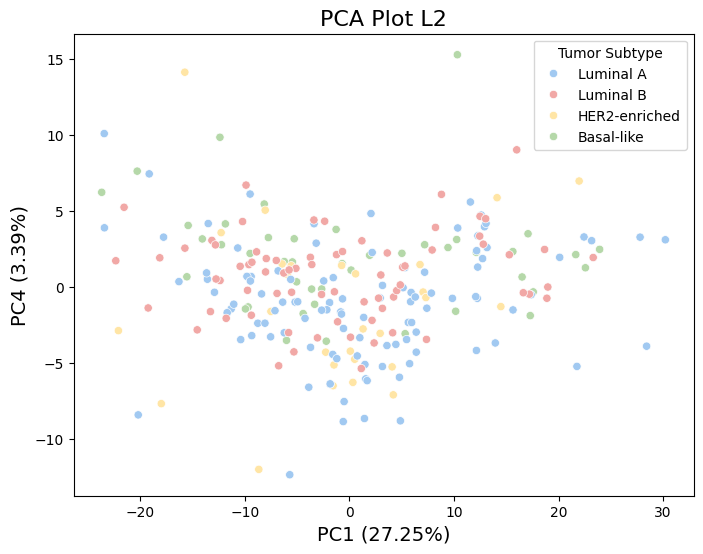

In [67]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l2, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L2', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_l2_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_l2_4:.2f}%)', fontsize=14)

plt.show()

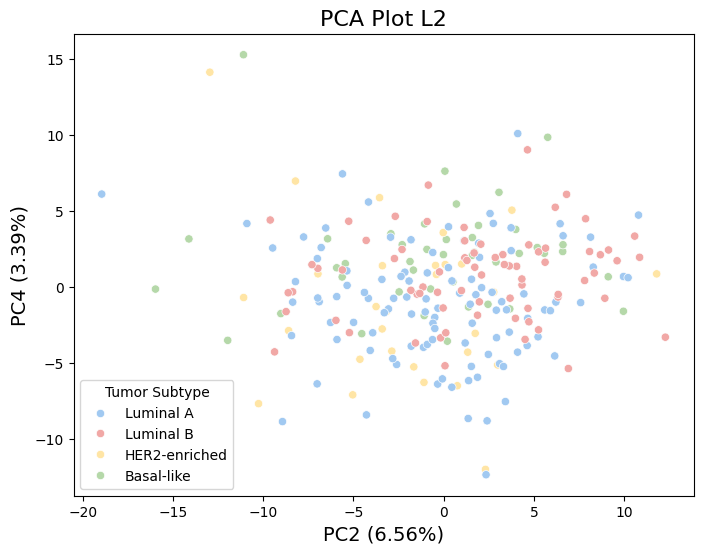

In [68]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l2, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L2', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_l2_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_l2_4:.2f}%)', fontsize=14)

plt.show()

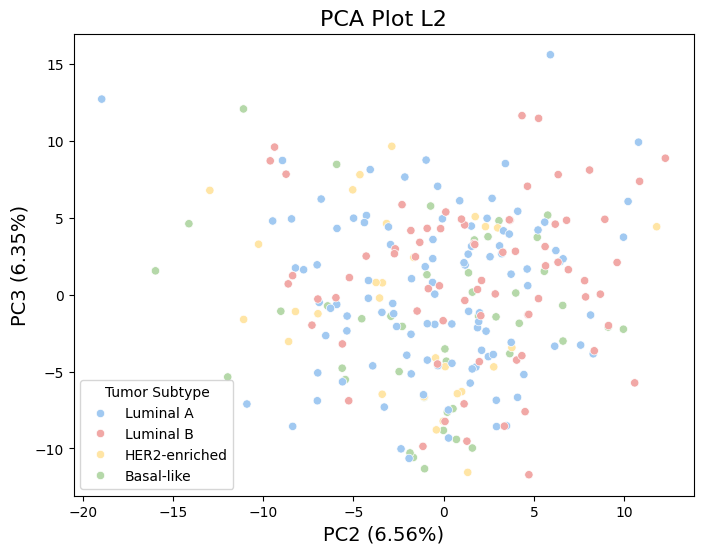

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_l2, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L2', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_l2_4:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_l2_4:.2f}%)', fontsize=14)

plt.show()

The goal witht he next code is to see it using a logistic model with ovr makes a difference

In [70]:
## Logistic models to make ROC Curves - multi_class = ovr, data is miRNA expression normalized as z-scores

x_ovr_z = expression_table
y_ovr_z = clinical_data_sample_subtype.squeeze()

X_train_z_ovr, X_test_z_ovr, y_train_z_ovr, y_test_z_ovr = train_test_split(x_ovr_z, y_ovr_z, test_size=0.2, random_state=42, stratify=y)       # y-test are the true labels and y_pred are the predicted labels

## L1 models

model_l1_c1_z_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.001, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c1_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l1_c2_z_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c2_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l1_c3_z_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.4, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c3_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l1_c4_z_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c4_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l1_c5_z_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.7, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c5_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l1_c6_z_ovr = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c6_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

## now the L2 models

model_l2_c1_z_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.001, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c1_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l2_c2_z_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.1, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c2_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l2_c3_z_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.4, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c3_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l2_c4_z_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.5, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c4_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l2_c5_z_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.7, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c5_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

model_l2_c6_z_ovr = LogisticRegression(penalty='l2', solver='saga', C=10, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c6_z_ovr.fit(X_train_z_ovr, y_train_z_ovr)

models_z_ovr = [model_l1_c1_z_ovr, model_l1_c2_z_ovr, model_l1_c3_z_ovr, model_l1_c4_z_ovr, model_l1_c5_z_ovr, model_l1_c6_z_ovr, model_l2_c1_z_ovr, model_l2_c2_z_ovr, model_l2_c3_z_ovr, model_l2_c4_z_ovr, model_l2_c5_z_ovr, model_l2_c6_z_ovr]

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\li

In [71]:
# Confusion matrices and classification report for different models

roc_data_cm_z_ovr = {} #confusion matrix
roc_data_y_pred_z_ovr = {}
roc_data_cr_z_ovr = {} #classification report
roc_data_y_score_z_ovr = {}
roc_data_auc_z_ovr = {}

for model in models_z_ovr[0:]:
    y_pred_z_ovr = model.predict(X_test_z_ovr)
    cm_z_ovr = confusion_matrix(y_test_z_ovr, y_pred_z_ovr)
    cr_z_ovr = classification_report(y_test_z_ovr, y_pred_z_ovr)
    y_score_z_ovr = model.predict_proba(X_test_z_ovr)
    roc_auc_scores_z_ovr = roc_auc_score(y_test_z_ovr, y_score_z_ovr, multi_class='ovr')

    roc_data_cm_z_ovr[model] = cm_z_ovr
    roc_data_y_pred_z_ovr[model] = y_pred_z_ovr
    roc_data_cr_z_ovr[model] = cr_z_ovr
    roc_data_y_score_z_ovr[model] = y_score_z_ovr
    roc_data_auc_z_ovr[model] = roc_auc_scores_z_ovr

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [72]:
# Labels for the ROC curves

models_label_z_ovr = [(model_l1_c1_z_ovr, 'L1 (C = 0.001)'),(model_l1_c2_z_ovr, 'L1 (C = 0.1)'),
    (model_l1_c3_z_ovr, 'L1 (C = 0.4)'),(model_l1_c4_z_ovr, 'L1 (C = 0.5)'),
    (model_l1_c5_z_ovr, 'L1 (C = 0.7)'),(model_l1_c6_z_ovr, 'L1 (C = 1)'),
    (model_l2_c1_z_ovr, 'L2 (C = 0.001)'),(model_l2_c2_z_ovr, 'L2 (C = 0.1)'),
    (model_l2_c3_z_ovr, 'L2 (C = 0.4)'),(model_l2_c4_z_ovr, 'L2 (C = 0.5)'),
    (model_l2_c5_z_ovr, 'L2 (C = 0.7)'),(model_l2_c6_z_ovr, 'L2 (C = 10)')]

model_names_z_ovr = ['L1 (C = 0.001)','L1 (C = 0.1)','L1 (C = 0.4)','L1 (C = 0.5)',
    'L1 (C = 0.7)','L1 (C = 1)','L2 (C = 0.001)','L2 (C = 0.1)',
    'L2 (C = 0.4)','L2 (C = 0.5)','L2 (C = 0.7)','L2 (C = 10)']

C:\Users\marga\AppData\Local\Temp\ipykernel_820\3500980490.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")


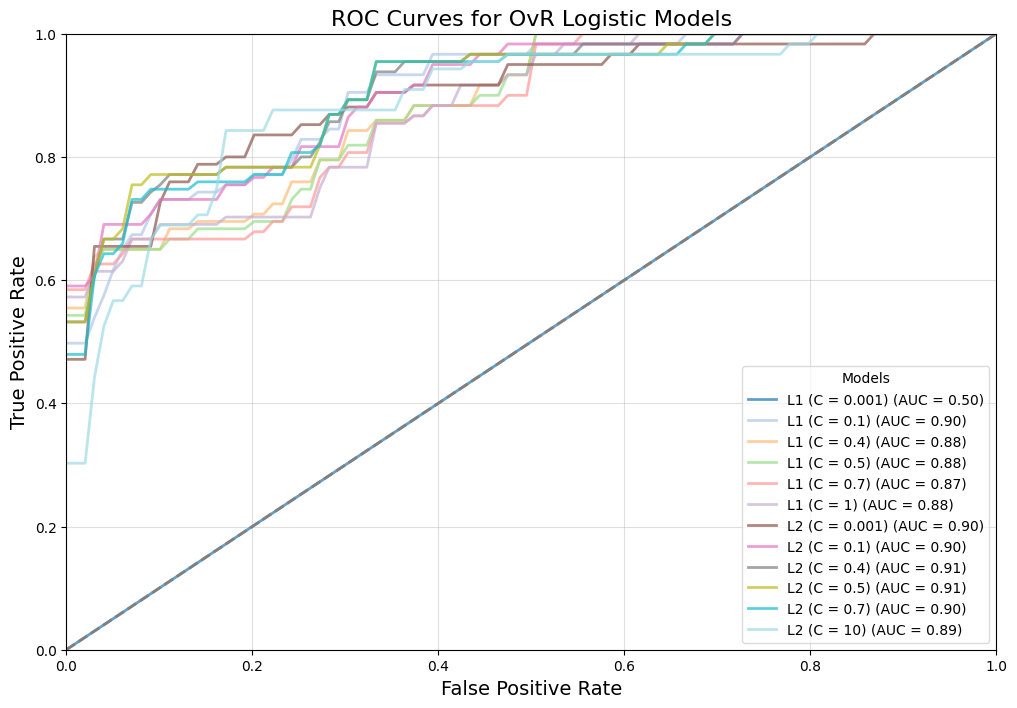

In [73]:
## ALL ROC CURVES for normalized miRNa expressinon as z-scores and ovr logistic models

classes_z_ovr = list(set(y_test_z_ovr))  # cancer subtypes
n_classes_z_ovr = len(classes_z_ovr)

# Binarize the labels (one-hot encoding)
y_test_bin_z_ovr = label_binarize(y_test_z_ovr, classes=classes_z_ovr)

roc_curves_z_ovr = {}

for model, model_name in zip(models_z_ovr, model_names_z_ovr):
    y_score_z_ovr = model.predict_proba(X_test_z_ovr)  # Predicted probabilities for each class
    
    fpr_z_ovr = {}
    tpr_z_ovr = {}
    
    for i in range(n_classes_z_ovr):
        fpr_z_ovr[i], tpr_z_ovr[i], __z_ovr = roc_curve(y_test_bin_z_ovr[:, i], y_score_z_ovr[:, i])  # ROC for class 
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr_z_ovr = np.linspace(0, 1, 100)
    mean_tpr_z_ovr = np.mean([np.interp(mean_fpr_z_ovr, fpr_z_ovr[i], tpr_z_ovr[i]) for i in range(n_classes_z_ovr)], axis=0)
    mean_auc_z_ovr = roc_data_auc_z_ovr[model]
    
    # Store the mean ROC curve data for the model
    roc_curves_z_ovr[model_name] = (mean_fpr_z_ovr, mean_tpr_z_ovr, mean_auc_z_ovr)

colormap = get_cmap("tab20") 
colors = [colormap(i) for i in np.linspace(0, 1, len(roc_curves_z_ovr))]
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr_z_ovr, mean_tpr_z_ovr, mean_auc_z_ovr)) in enumerate(roc_curves_z_ovr.items()):
    plt.plot(mean_fpr_z_ovr, mean_tpr_z_ovr, lw=2, label=f"{model_name} (AUC = {mean_auc_z_ovr:.2f})", color=colors[idx], alpha=0.7)

# diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for OvR Logistic Models", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title = 'Models')
plt.grid(alpha=0.4)
plt.show()

In [74]:
# Classification reports for the models above

for model, name in models_label_z_ovr:
    print(f"{name}:")
    print(roc_data_cr_z_ovr[model])
    print()

### Conclusion: L1 c=1 c6 and L2 c=0.1 c2 are the best 

L1 (C = 0.001):
               precision    recall  f1-score   support

   Basal-like       0.00      0.00      0.00         9
HER2-enriched       0.00      0.00      0.00         6
    Luminal A       0.41      1.00      0.58        21
    Luminal B       0.00      0.00      0.00        15

     accuracy                           0.41        51
    macro avg       0.10      0.25      0.15        51
 weighted avg       0.17      0.41      0.24        51


L1 (C = 0.1):
               precision    recall  f1-score   support

   Basal-like       0.90      1.00      0.95         9
HER2-enriched       1.00      0.17      0.29         6
    Luminal A       0.68      1.00      0.81        21
    Luminal B       0.56      0.33      0.42        15

     accuracy                           0.71        51
    macro avg       0.78      0.63      0.61        51
 weighted avg       0.72      0.71      0.66        51


L1 (C = 0.4):
               precision    recall  f1-score   support

   Basal-lik

In [75]:
# Retrieving a list with the selected miRNAs --- L1 z cores ovr logistic models
coefficients_z_ovr_l1_c6 = model_l1_c6_z_ovr.coef_[0]  
selected_indices_z_ovr_l1_c6 = [i for i, coef in enumerate(coefficients_z_ovr_l1_c6) if coef != 0 and coef > 0]

miRNA_names_z_ovr_l1_c6 = expression_table.columns.tolist()
selected_miRNAs_z_ovr_l1_c6 = [miRNA_names_z_ovr_l1_c6[i] for i in selected_indices_z_ovr_l1_c6]  
len(selected_miRNAs_z_ovr_l1_c6)  

33

In [76]:
# Retrieving a list with the selected miRNAs --- L2 z cores ovr logistic models
coefficients_z_ovr_l2_c2 = model_l2_c2_z_ovr.coef_[0]  
selected_indices_z_ovr_l2_c2 = [i for i, coef in enumerate(coefficients_z_ovr_l2_c2) if coef != 0 and coef > 0]

miRNA_names_z_ovr_l2_c2 = expression_table.columns.tolist()
selected_miRNAs_z_ovr_l2_c2 = [miRNA_names_z_ovr_l2_c2[i] for i in selected_indices_z_ovr_l2_c2]  
len(selected_miRNAs_z_ovr_l2_c2)  

461

In [77]:
## PCA with 4 components L1

pca_4_z_ovr_l1_c6 = PCA(n_components=4)
features_z_ovr_l1_c6 = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_z_ovr_l1_c6 = features_z_ovr_l1_c6[[col for col in selected_miRNAs_z_ovr_l1_c6 if col in features_z_ovr_l1_c6]]
principal_components_z_ovr_l1_c6 = pca_4_z_ovr_l1_c6.fit_transform(features_z_ovr_l1_c6)

pca_df_4comp_z_ovr_l1_c6 = pd.DataFrame(data=principal_components_z_ovr_l1_c6, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_4comp_z_ovr_l1_c6['Tumor Subtype'] = subtype_list

explained_variance_4component_z_ovr_l1_c6 = pca_4_z_ovr_l1_c6.explained_variance_ratio_
explained_variance_pc1_z_ovr_l1_c6 = pca_4_z_ovr_l1_c6.explained_variance_ratio_[0] * 100
explained_variance_pc2_z_ovr_l1_c6 = pca_4_z_ovr_l1_c6.explained_variance_ratio_[1] * 100
explained_variance_pc3_z_ovr_l1_c6 = pca_4_z_ovr_l1_c6.explained_variance_ratio_[2] * 100
explained_variance_pc4_z_ovr_l1_c6 = pca_4_z_ovr_l1_c6.explained_variance_ratio_[3] * 100
explained_variance_4component_z_ovr_l1_c6

array([0.46008396, 0.11401077, 0.09722265, 0.07422853])

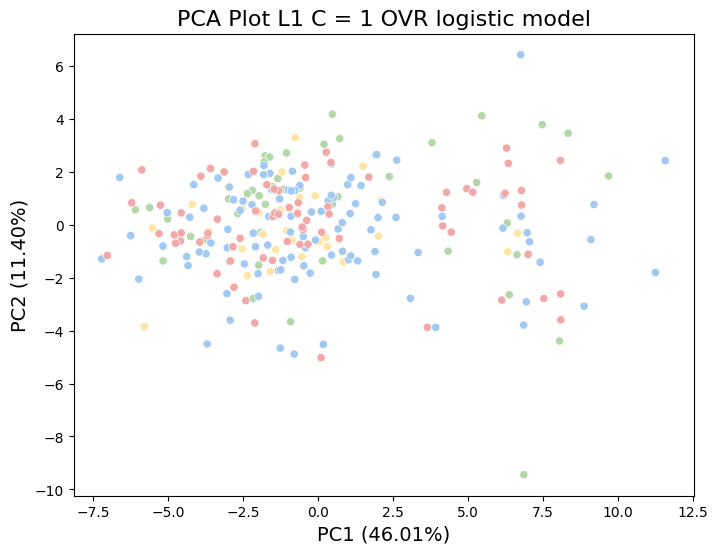

In [78]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l1_c6, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend=False)

plt.title('PCA Plot L1 C = 1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.show()

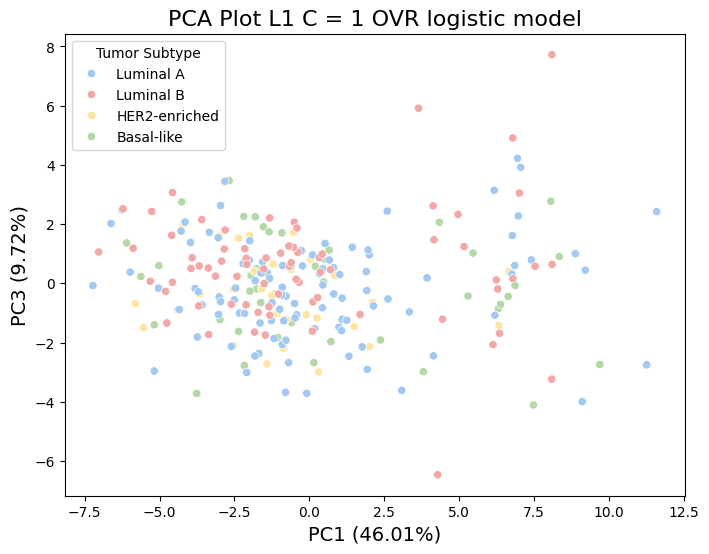

In [79]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l1_c6, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1 C = 1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.show()

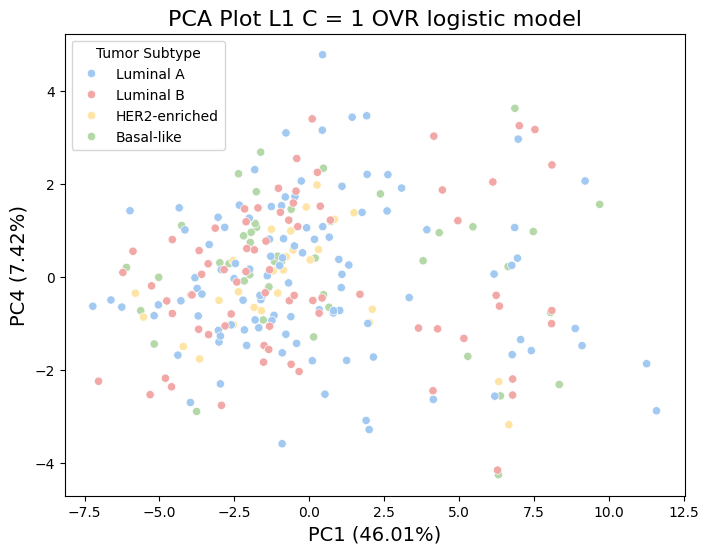

In [80]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l1_c6, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1 C = 1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.show()

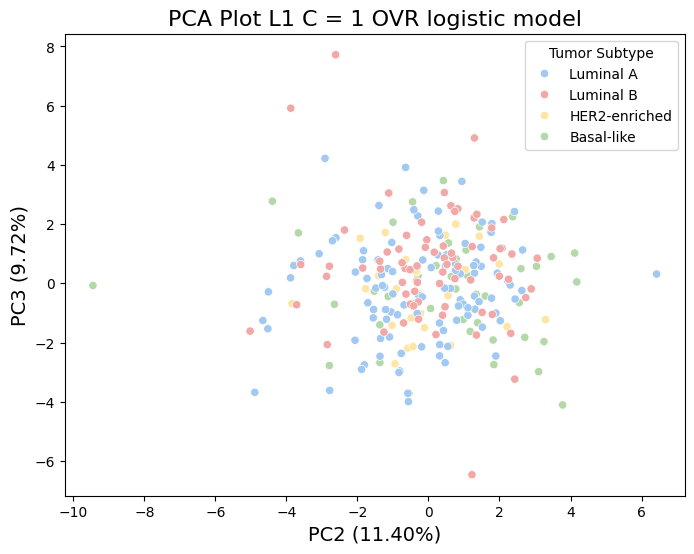

In [81]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l1_c6, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1 C = 1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.show()

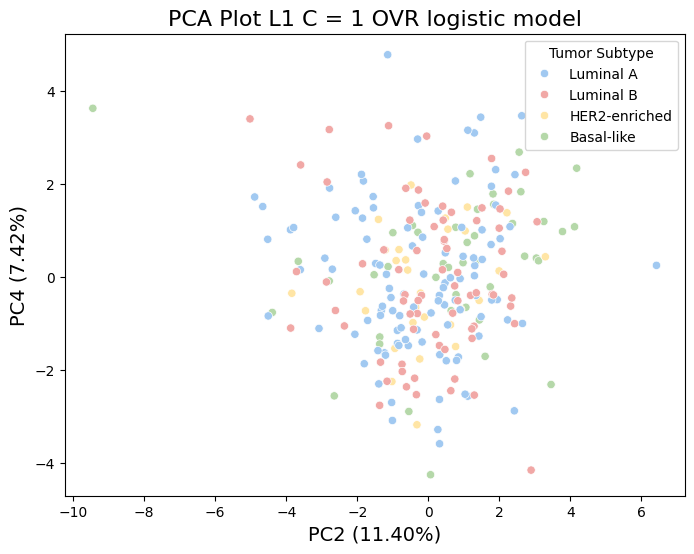

In [82]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l1_c6, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1 C = 1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.show()

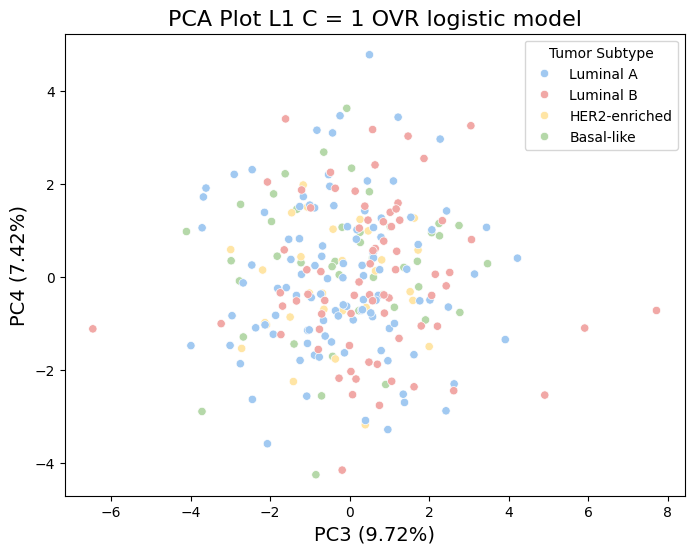

In [83]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l1_c6, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot L1 C = 1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_z_ovr_l1_c6:.2f}%)', fontsize=14)
plt.show()

In [84]:
## PCA with 4 components L2

pca_4_z_ovr_l2_c2 = PCA(n_components=4)
features_z_ovr_l2_c2 = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_z_ovr_l2_c2 = features_z_ovr_l2_c2[[col for col in selected_miRNAs_z_ovr_l2_c2 if col in features_z_ovr_l2_c2]]
principal_components_z_ovr_l2_c2 = pca_4_z_ovr_l2_c2.fit_transform(features_z_ovr_l2_c2)

pca_df_4comp_z_ovr_l2_c2 = pd.DataFrame(data=principal_components_z_ovr_l2_c2, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_4comp_z_ovr_l2_c2['Tumor Subtype'] = subtype_list

explained_variance_4component_z_ovr_l2_c2 = pca_4_z_ovr_l2_c2.explained_variance_ratio_
explained_variance_pc1_z_ovr_l2_c2 = pca_4_z_ovr_l2_c2.explained_variance_ratio_[0] * 100
explained_variance_pc2_z_ovr_l2_c2 = pca_4_z_ovr_l2_c2.explained_variance_ratio_[1] * 100
explained_variance_pc3_z_ovr_l2_c2 = pca_4_z_ovr_l2_c2.explained_variance_ratio_[2] * 100
explained_variance_pc4_z_ovr_l2_c2 = pca_4_z_ovr_l2_c2.explained_variance_ratio_[3] * 100
explained_variance_4component_z_ovr_l2_c2

array([0.26082608, 0.07506307, 0.0661373 , 0.03671398])

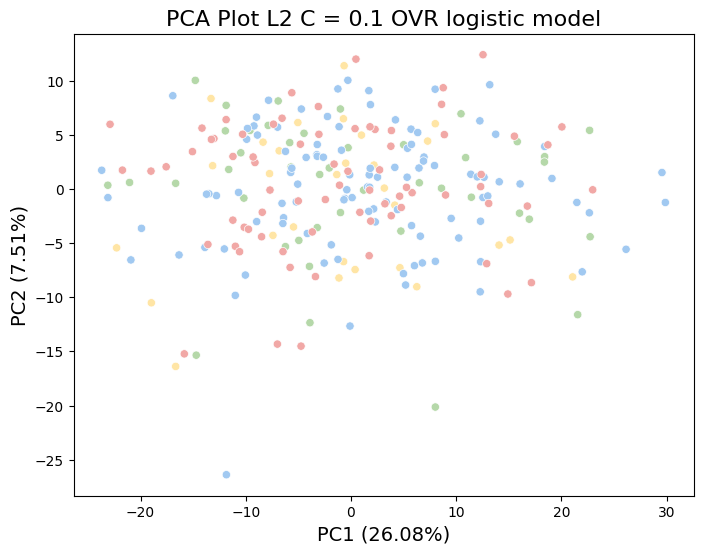

In [85]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_4comp_z_ovr_l2_c2, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)

plt.title('PCA Plot L2 C = 0.1 OVR logistic model', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_z_ovr_l2_c2:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2_z_ovr_l2_c2:.2f}%)', fontsize=14)
plt.show()

**Heatmaps**

In [86]:
# Prepare Data for the L1 Heatmap Hierarchichal clustering

miRNA_expr_l1_hm = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
miRNA_expr_l1_hm = miRNA_expr_l1_hm[[col for col in selected_miRNAs_l1_c3 if col in miRNA_expr_l1_hm]]
numeric_columns_l1 = miRNA_expr_l1_hm.select_dtypes(include=['object']).columns
miRNA_expr_l1_hm[numeric_columns_l1] = miRNA_expr_l1_hm[numeric_columns_l1].apply(pd.to_numeric, errors='coerce')


# Hierarchical clustering

numeric_data_l1_hm = miRNA_expr_l1_hm.select_dtypes(include=['number'])   # checked for null values - False (no NA values)
transposed_numeric_df_l1 = numeric_data_l1_hm.T #transposed df
Z_l1 = linkage(transposed_numeric_df_l1, method='single')

df_l1 = pd.DataFrame(numeric_data_l1_hm)

missing_values_l1 = df_l1.isnull().any().any()
missing_values_l1 # No NA

np.False_

C:\Users\marga\AppData\Local\Temp\ipykernel_820\2697416656.py:42: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


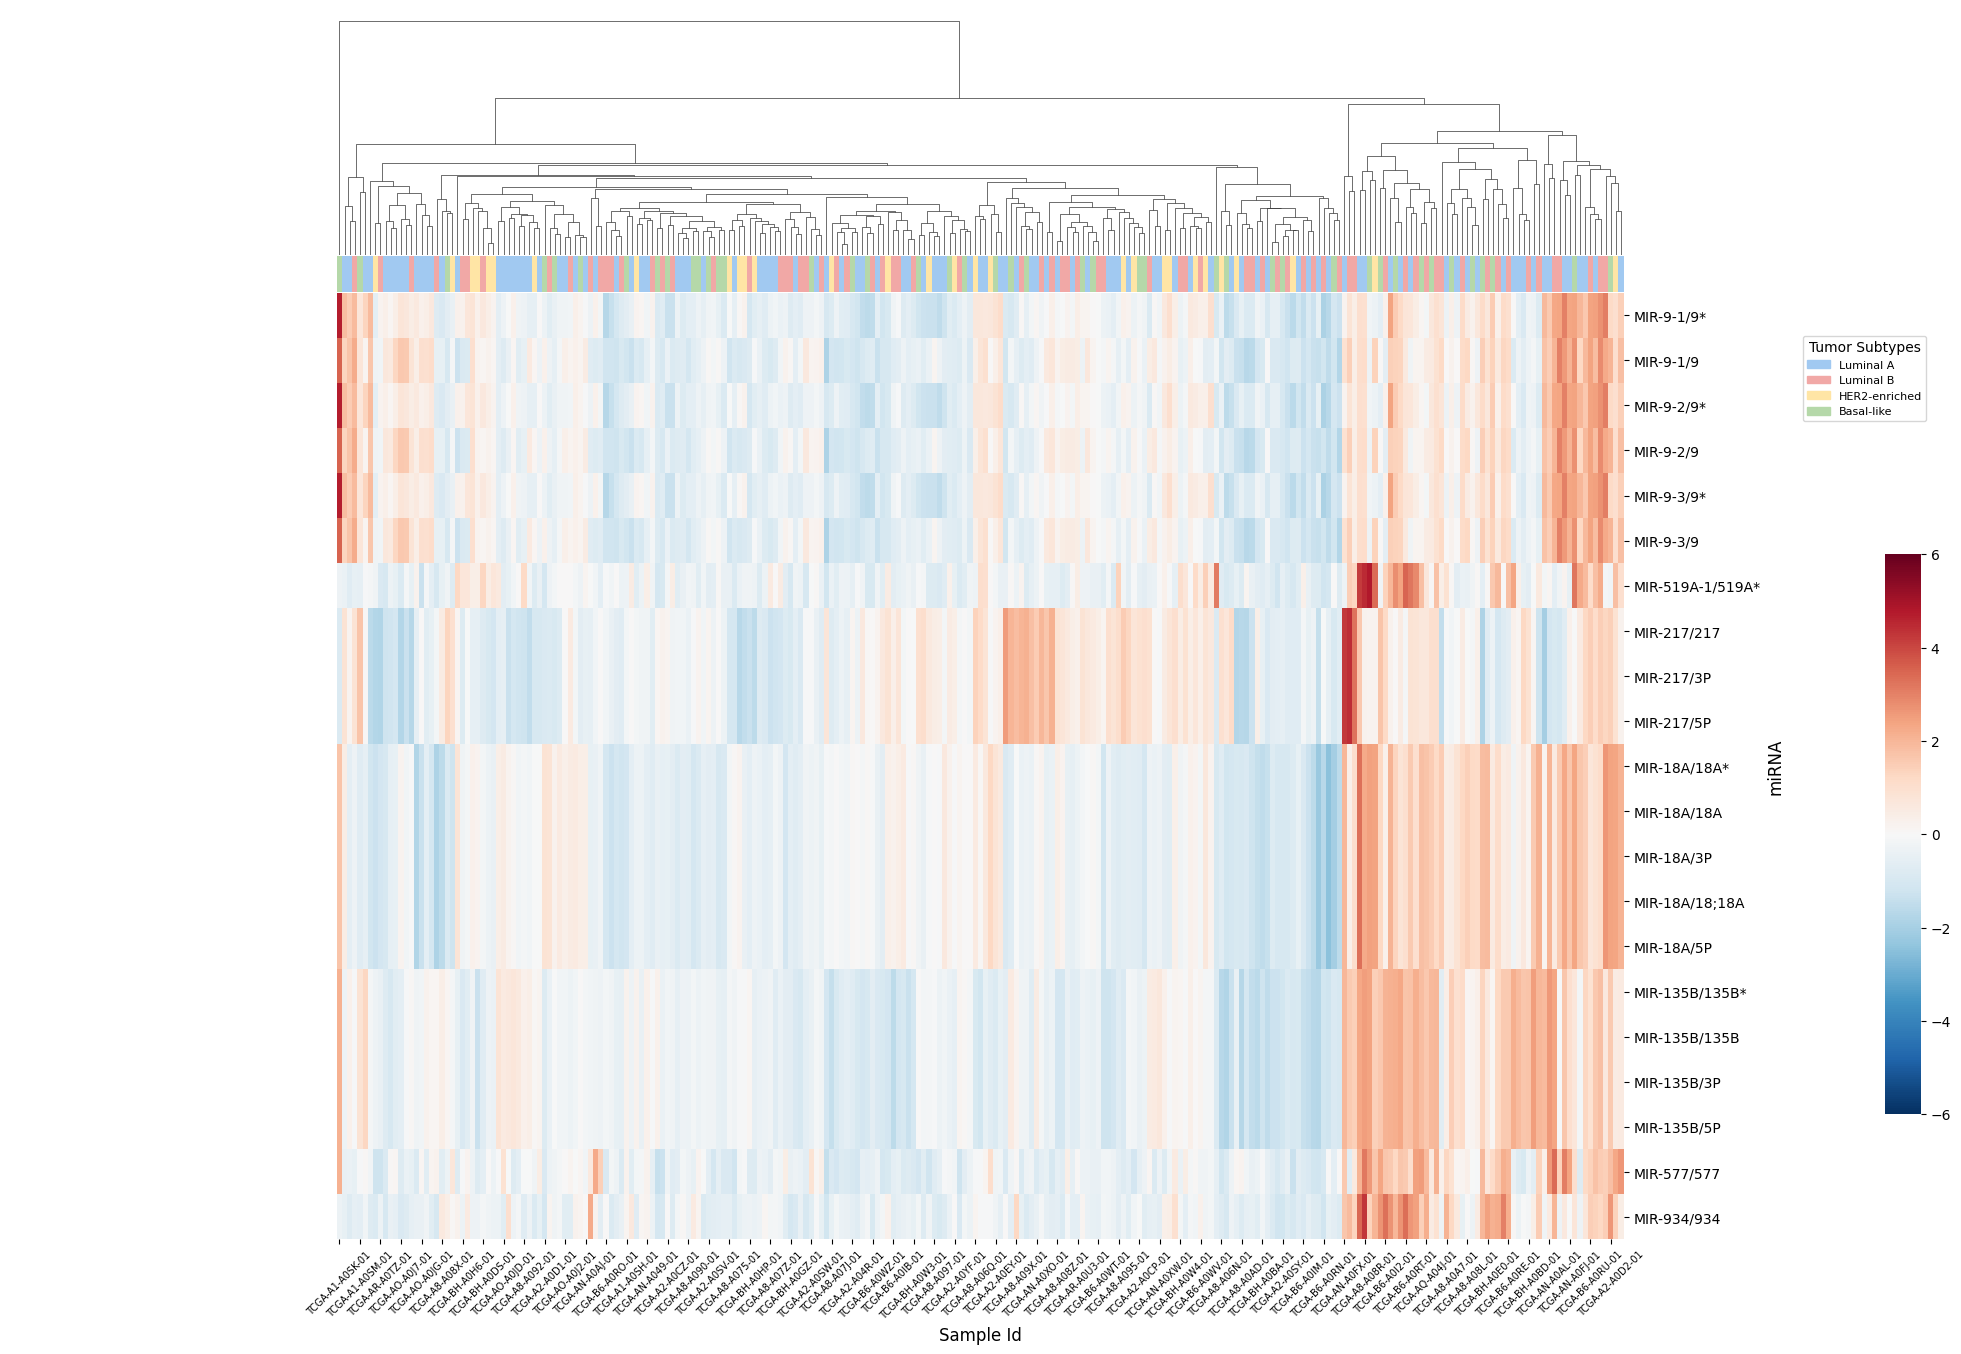

In [87]:
# Plot

# Map colors
tumor_subtypes_list = subtype_list
xticklabels_colored = [tumor_colors.get(subtype, 'black') for subtype in tumor_subtypes_list]

Z_l1 = linkage(transposed_numeric_df_l1.T, method='average')

vmin, vmax = -6, 6

# Create the clustermap
g = sns.clustermap(
    transposed_numeric_df_l1,
    row_cluster=False,
    col_cluster=True,
    col_linkage=Z_l1,
    figsize=(18, 14),
    cmap='RdBu_r',
    metric='euclidean',
    annot=False,
    cbar_pos=(1.05, 0.2, 0.02, 0.4),
    col_colors=xticklabels_colored,
    vmin=vmin,  # Minimum value for colormap
    vmax=vmax,  # Maximum value for colormap
)

# Customize x-axis
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=7, rotation=45)
g.ax_heatmap.set_xlabel('Sample Id', fontsize=12)
g.ax_heatmap.set_ylabel('miRNA', fontsize=12)

# Add legend for tumor subtype colors
handles = [mpatches.Patch(color=color, label=label) for label, color in tumor_colors.items()]
plt.legend(
    handles=handles,
    loc='upper right',
    bbox_to_anchor=(1.3, 1.4), 
    title='Tumor Subtypes',
    fontsize=8
)

plt.tight_layout()
plt.show()

In [88]:
# Prepare Data for the L2 Heatmap Hierarchichal clustering

miRNA_expr_l2_hm = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
miRNA_expr_l2_hm = miRNA_expr_l2_hm[[col for col in selected_miRNAs_l2_c2 if col in miRNA_expr_l2_hm]]
numeric_columns_l2 = miRNA_expr_l2_hm.select_dtypes(include=['object']).columns
miRNA_expr_l2_hm[numeric_columns_l2] = miRNA_expr_l2_hm[numeric_columns_l2].apply(pd.to_numeric, errors='coerce')


# Hierarchical clustering

numeric_data_l2_hm = miRNA_expr_l2_hm.select_dtypes(include=['number'])   # checked for null values - False (no NA values)
transposed_numeric_df_l2 = numeric_data_l2_hm.T #transposed df
Z_l2 = linkage(transposed_numeric_df_l2, method='single')

df_l2 = pd.DataFrame(numeric_data_l2_hm)

missing_values_l2 = df_l2.isnull().any().any()
missing_values_l2 # No NA

np.False_

C:\Users\marga\AppData\Local\Temp\ipykernel_820\1671839739.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


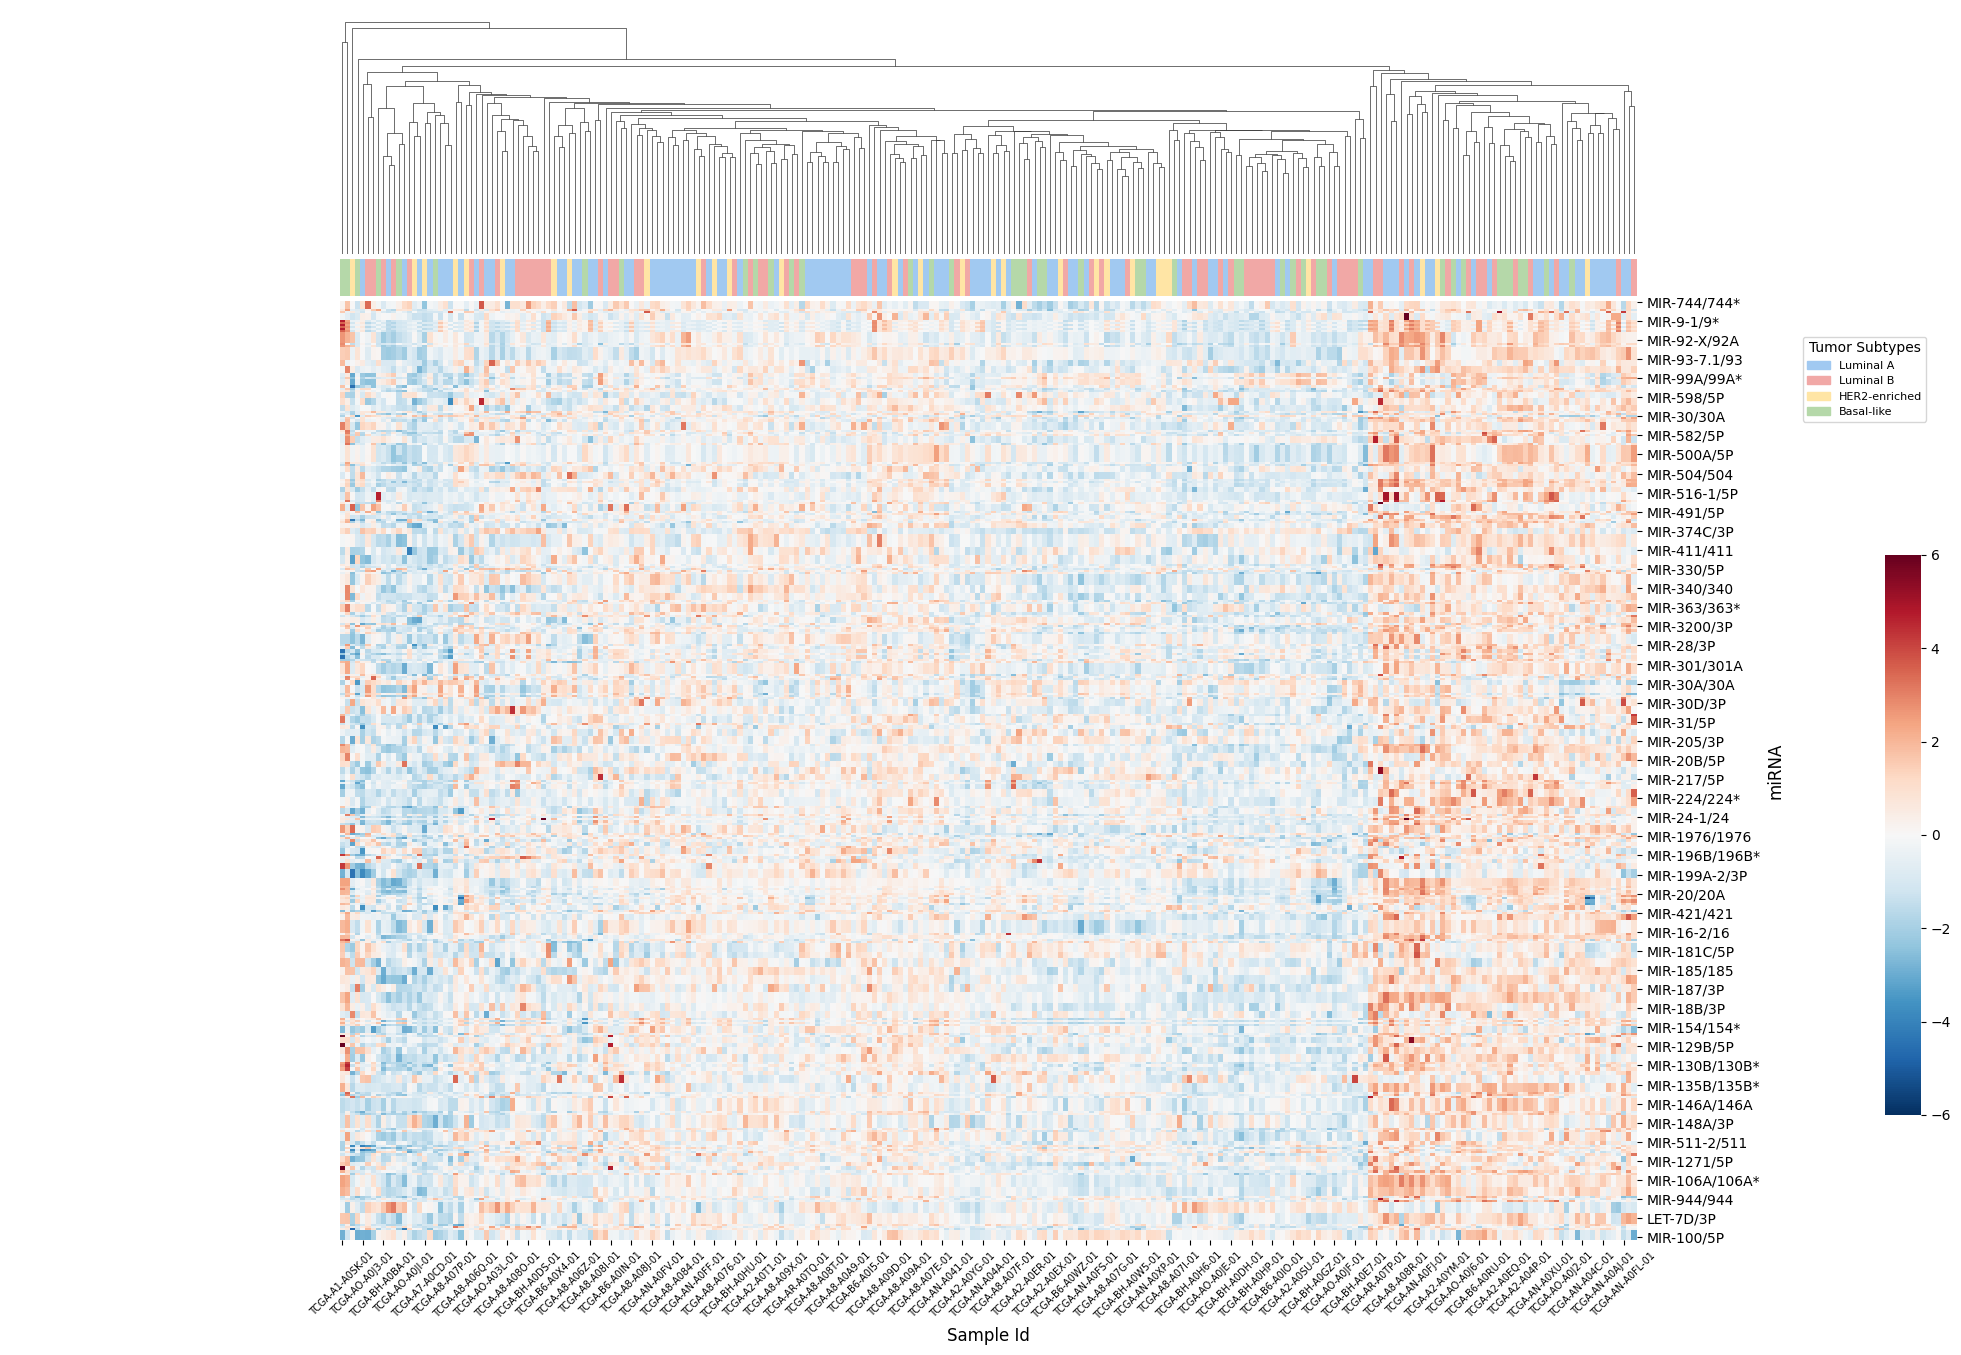

In [89]:
# Plot

# Map colors
tumor_subtypes_list = subtype_list
xticklabels_colored = [tumor_colors.get(subtype, 'black') for subtype in tumor_subtypes_list]

Z_l2 = linkage(transposed_numeric_df_l2.T, method='average')

vmin, vmax = -6, 6

#  clustermap
g = sns.clustermap(
    transposed_numeric_df_l2,
    row_cluster=False,
    col_cluster=True,
    col_linkage=Z_l2,
    figsize=(18, 14),
    cmap='RdBu_r',
    metric='euclidean',
    annot=False,
    cbar_pos=(1.05, 0.2, 0.02, 0.4),
    col_colors=xticklabels_colored,
    vmin=vmin,
    vmax=vmax,
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=7, rotation=45)
g.ax_heatmap.set_xlabel('Sample Id', fontsize=12)
g.ax_heatmap.set_ylabel('miRNA', fontsize=12)

# Add legend for tumor subtype colors
handles = [mpatches.Patch(color=color, label=label) for label, color in tumor_colors.items()]
plt.legend(
    handles=handles,
    loc='upper right',
    bbox_to_anchor=(1.3, 1.4), 
    title='Tumor Subtypes',
    fontsize=8
)

plt.tight_layout()
plt.show()

**Variance Analysis**

L1 threshold > 0.5 and > 1

In [90]:
## Prepare df
df_variance = miRNA_expression.drop(index=['entrezGeneId', 'type'])
df_variancel1 = df_variance.transpose()
df_variancel1 = df_variancel1.drop(index=[r for r in df_variancel1.index if r not in selected_miRNAs_l1_c3])
df_variancel1

TCGA-A1-A0SE-01 TCGA-A1-A0SH-01 TCGA-A1-A0SJ-01  \
hugoGeneSymbol                                                     
MIR-9-1/9*               -0.5913         -0.6395         -0.6195   
MIR-9-1/9                -0.6597         -1.1701         -1.0247   
MIR-9-2/9*               -0.5913         -0.6395         -0.6195   
MIR-9-2/9                -0.6597         -1.1701         -1.0247   
MIR-9-3/9*               -0.5913         -0.6395         -0.6195   
MIR-9-3/9                -0.6597         -1.1701         -1.0247   
MIR-519A-1/519A*         -0.2528         -0.2883         -0.2736   
MIR-217/217              -0.0647         -0.1629          1.3285   
MIR-217/3P               -0.0647         -0.1629          1.3285   
MIR-217/5P               -0.0647         -0.1629          1.3285   
MIR-18A/18A*             -1.0683         -1.1035         -0.8904   
MIR-18A/18A              -1.0683         -1.1035         -0.8904   
MIR-18A/3P               -1.0683         -1.1035         -0.8904   
MIR-18A/18;18A           -1.0683         -1.1035         -0.8904   
MIR-18A/5P               -1.0683         -1.1035         -0.8904   
MIR-135B/135B*            -0.172          0.2629          0.1385   
MIR-135B/135B             -0.172          0.2629          0.1385   
MIR-135B/3P               -0.172          0.2629          0.1385   
MIR-135B/5P               -0.172          0.2629          0.1385   
MIR-577/577              -0.5107           0.256         -0.3365   
MIR-934/934               0.5411           0.184          0.3762   

                 TCGA-A1-A0SK-01 TCGA-A1-A0SM-01 TCGA-A1-A0SO-01  \
hugoGeneSymbol                                                     
MIR-9-1/9*                4.6875          0.7179          2.4185   
MIR-9-1/9                 3.5332          0.7652          2.7368   
MIR-9-2/9*                4.6875          0.7179          2.4185   
MIR-9-2/9                 3.5332          0.7652          2.7368   
MIR-9-3/9*                4.6875          0.7179          2.4185   
MIR-9-3/9                 3.5332          0.7652          2.7368   
MIR-519A-1/519A*         -0.2912         -0.5332           3.218   
MIR-217/217              -0.8459          1.7254         -0.0226   
MIR-217/3P               -0.8459          1.7254         -0.0226   
MIR-217/5P               -0.8459          1.7254         -0.0226   
MIR-18A/18A*              1.7024         -0.7289          2.3444   
MIR-18A/18A               1.7024         -0.7289          2.3444   
MIR-18A/3P                1.7024         -0.7289          2.3444   
MIR-18A/18;18A            1.7024         -0.7289          2.3444   
MIR-18A/5P                1.7024         -0.7289          2.3444   
MIR-135B/135B*            2.1181          0.8813          0.7342   
MIR-135B/135B             2.1181          0.8813          0.7342   
MIR-135B/3P               2.1181          0.8813          0.7342   
MIR-135B/5P               2.1181          0.8813          0.7342   
MIR-577/577               2.1534         -0.0701           0.996   
MIR-934/934              -0.3749         -0.5907          0.7605   

                 TCGA-A2-A04P-01 TCGA-A2-A04Q-01 TCGA-A2-A04R-01  \
hugoGeneSymbol                                                     
MIR-9-1/9*               -0.5735            0.69         -0.9892   
MIR-9-1/9                  0.032          0.5168         -1.1048   
MIR-9-2/9*               -0.5735            0.69         -0.9892   
MIR-9-2/9                  0.032          0.5168         -1.1048   
MIR-9-3/9*               -0.5735            0.69         -0.9892   
MIR-9-3/9                  0.032          0.5168         -1.1048   
MIR-519A-1/519A*         -0.2396            0.07         -0.5466   
MIR-217/217               1.7263          1.0231          0.1722   
MIR-217/3P                1.7263          1.0231          0.1722   
MIR-217/5P                1.7263          1.0231          0.1722   
MIR-18A/18A*              1.2603          1.5328           0.073   
MIR

In [91]:
## Calculating variance

variances_l1 = df_variancel1.var(axis=1)
variances_l1

hugoGeneSymbol
MIR-9-1/9*          0.972586
MIR-9-1/9           0.969034
MIR-9-2/9*          0.972586
MIR-9-2/9           0.969034
MIR-9-3/9*          0.972586
MIR-9-3/9           0.969034
MIR-519A-1/519A*    1.068106
MIR-217/217         1.027946
MIR-217/3P          1.027946
MIR-217/5P          1.027946
MIR-18A/18A*         0.97487
MIR-18A/18A          0.97487
MIR-18A/3P           0.97487
MIR-18A/18;18A       0.97487
MIR-18A/5P           0.97487
MIR-135B/135B*      1.006484
MIR-135B/135B       1.006484
MIR-135B/3P         1.006484
MIR-135B/5P         1.006484
MIR-577/577         0.966851
MIR-934/934         1.003823
dtype: object

In [92]:
# Filter for variance thresholds
filtered_l1_05 = variances_l1[variances_l1 >= 0.5]         ## 21 miRNA
filtered_l1_1 = variances_l1[variances_l1 >= 1]            ## 9 miRNA

In [93]:
## Prepare df for L1 variance > 0.5 PCA
# remove 2 rows from miRNA_expression and select the filteres miRNA
features_variance = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_variance_l1_05 = features_variance.drop(columns=[col for col in features_variance.columns if col not in filtered_l1_05])

In [94]:
# Initialize PCA
pca_variance_l1_05 = PCA(n_components=4)  

pca_result_var_l1_05 = pca_variance_l1_05.fit_transform(features_variance_l1_05)
explained_var_ratio = pca_variance_l1_05.explained_variance_ratio_
pca_df_var_l1_05 = pd.DataFrame(data=pca_result_var_l1_05, columns=['PC1', 'PC2', 'PC3', 'PC4'])

print("Explained variance ratio (percentage):", explained_var_ratio)    ### Values above 0.7 are good

explained_var_pc1_l105 = explained_var_ratio[0] * 100
explained_var_pc2_l105 = explained_var_ratio[1] * 100
explained_var_pc3_l105 = explained_var_ratio[2] * 100
explained_var_pc4_l105 = explained_var_ratio[3] * 100

Explained variance ratio (percentage): [0.57297252 0.14904846 0.11074032 0.0756285 ]


In [95]:
pca_df_var_l1_05

PC1       PC2       PC3       PC4
0   -2.358532  0.352352 -0.389953 -1.415030
1   -2.287649  0.509070 -1.303969 -1.951014
2   -1.775278  2.749411  0.013003 -1.527248
3    9.936150 -5.159185  3.474268 -1.193935
4    1.151019  1.760049  2.496348 -2.613732
..        ...       ...       ...       ...
246  4.704371  5.194471  0.903742 -0.612430
247 -2.137431  0.368832 -0.032125  1.800714
248 -0.604880  1.095965 -0.449173 -0.475831
249 -0.183344  1.545673  0.360733 -0.066466
250  5.625720  1.868337 -2.506515 -1.686976

[251 rows x 4 columns]

In [96]:
pca_df_var_l1_05['Tumor Subtype'] = subtype_list
pca_df_var_l1_05

PC1       PC2       PC3       PC4 Tumor Subtype
0   -2.358532  0.352352 -0.389953 -1.415030    Basal-like
1   -2.287649  0.509070 -1.303969 -1.951014    Basal-like
2   -1.775278  2.749411  0.013003 -1.527248    Basal-like
3    9.936150 -5.159185  3.474268 -1.193935    Basal-like
4    1.151019  1.760049  2.496348 -2.613732    Basal-like
..        ...       ...       ...       ...           ...
246  4.704371  5.194471  0.903742 -0.612430     Luminal B
247 -2.137431  0.368832 -0.032125  1.800714     Luminal B
248 -0.604880  1.095965 -0.449173 -0.475831     Luminal B
249 -0.183344  1.545673  0.360733 -0.066466     Luminal B
250  5.625720  1.868337 -2.506515 -1.686976     Luminal B

[251 rows x 5 columns]

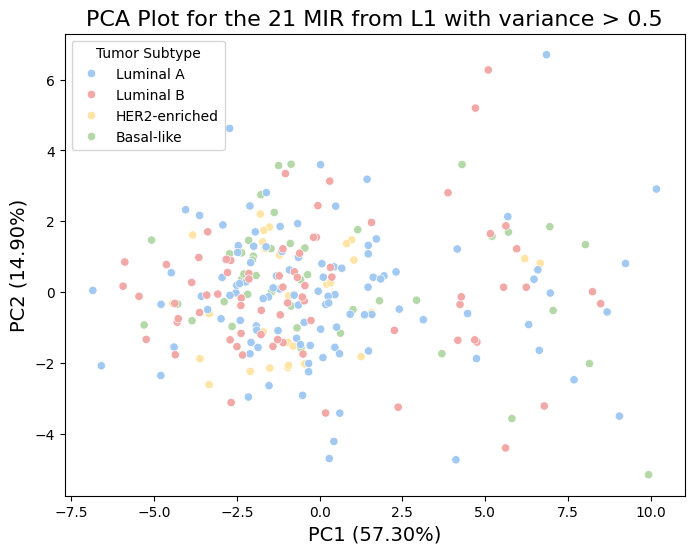

In [97]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_05, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 21 MIR from L1 with variance > 0.5', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l105:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_pc2_l105:.2f}%)', fontsize=14)

plt.show()

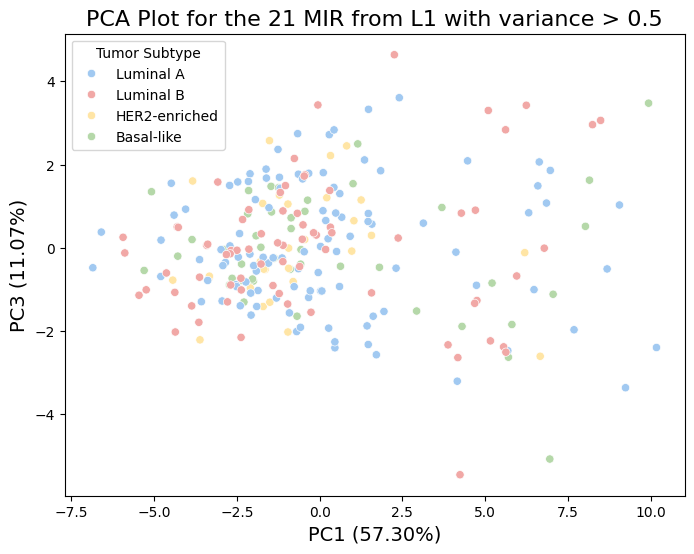

In [98]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_05, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 21 MIR from L1 with variance > 0.5', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l105:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_var_pc3_l105:.2f}%)', fontsize=14)

plt.show()

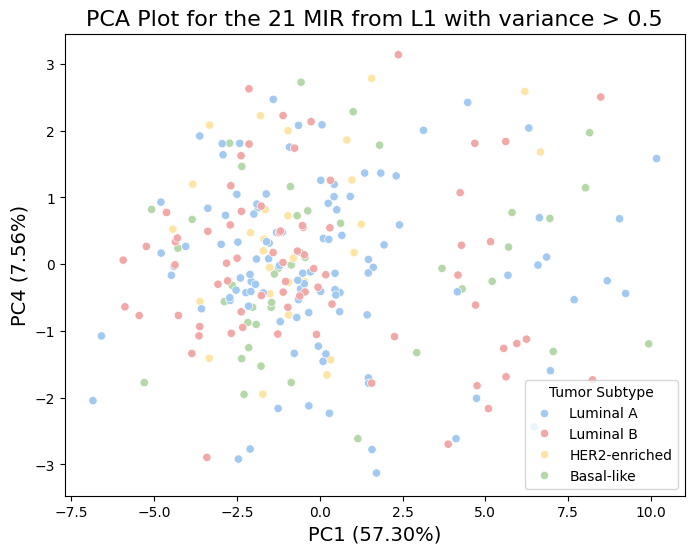

In [99]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_05, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 21 MIR from L1 with variance > 0.5', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l105:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l105:.2f}%)', fontsize=14)

plt.show()

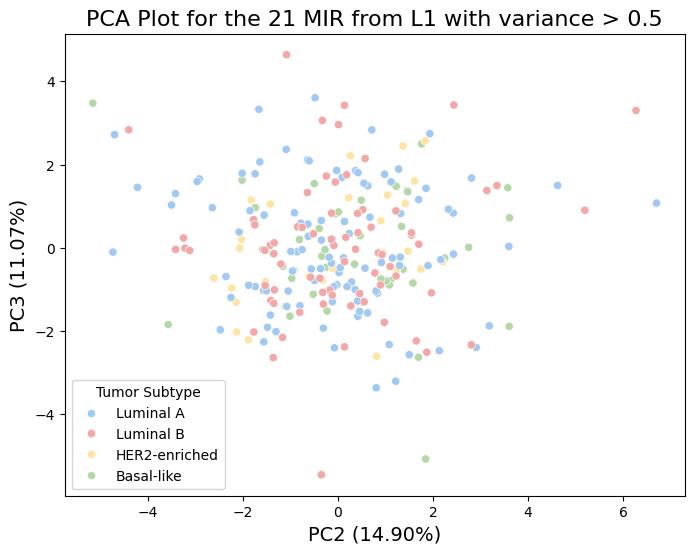

In [100]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_05, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 21 MIR from L1 with variance > 0.5', fontsize=16)
plt.xlabel(f'PC2 ({explained_var_pc2_l105:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_var_pc3_l105:.2f}%)', fontsize=14)

plt.show()

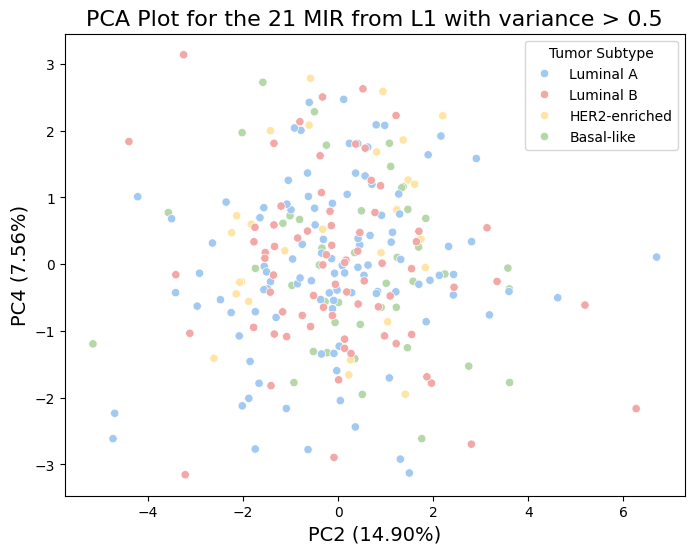

In [101]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_05, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 21 MIR from L1 with variance > 0.5', fontsize=16)
plt.xlabel(f'PC2 ({explained_var_pc2_l105:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l105:.2f}%)', fontsize=14)

plt.show()

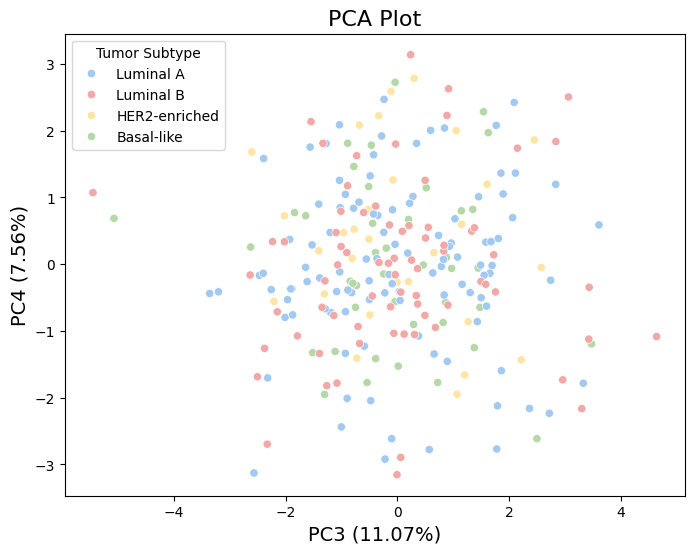

In [102]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_05, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot', fontsize=16)
plt.xlabel(f'PC3 ({explained_var_pc3_l105:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l105:.2f}%)', fontsize=14)

plt.show()

In [103]:
## Prepare df for L1 variance > 1 PCA
# remove 2 rows from miRNA_expression and select the filteres miRNA
features_variance = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_variance_l1_1 = features_variance.drop(columns=[col for col in features_variance.columns if col not in filtered_l1_1])

In [104]:
# Initialize PCA
pca_variance_l1_1 = PCA(n_components=4)  

pca_result_var_l1_1 = pca_variance_l1_1.fit_transform(features_variance_l1_1)
explained_var_ratio_l1_1 = pca_variance_l1_1.explained_variance_ratio_
pca_df_var_l1_1 = pd.DataFrame(data=pca_result_var_l1_1, columns=['PC1', 'PC2', 'PC3', 'PC4'])

print("Explained variance ratio (percentage):", explained_var_ratio_l1_1)    ### Values above 0.7 are good

explained_var_pc1_l1_1 = explained_var_ratio_l1_1[0] * 100
explained_var_pc2_l1_1 = explained_var_ratio_l1_1[1] * 100
explained_var_pc3_l1_1 = explained_var_ratio_l1_1[2] * 100
explained_var_pc4_l1_1 = explained_var_ratio_l1_1[3] * 100

Explained variance ratio (percentage): [0.57869114 0.30140699 0.08452713 0.03537473]


In [105]:
pca_df_var_l1_1['Tumor Subtype'] = subtype_list
pca_df_var_l1_1

PC1       PC2       PC3       PC4 Tumor Subtype
0   -0.201402 -0.066738  0.121044  0.659469    Basal-like
1    0.315743 -0.487937 -0.423407  0.243550    Basal-like
2    1.103147  1.988635 -0.344384  0.354094    Basal-like
3    2.734209 -2.804103 -2.219336 -0.776228    Basal-like
4    2.153536  2.228733 -1.622081 -0.588462    Basal-like
..        ...       ...       ...       ...           ...
246  5.219128  4.020566  0.000918 -0.175871     Luminal B
247 -2.013283  0.717869  0.319055  0.143721     Luminal B
248  0.680273  0.484360  0.605224 -0.729583     Luminal B
249  0.446247  1.488585  0.292087 -0.872380     Luminal B
250  5.756731 -0.686055  1.315870 -0.102788     Luminal B

[251 rows x 5 columns]

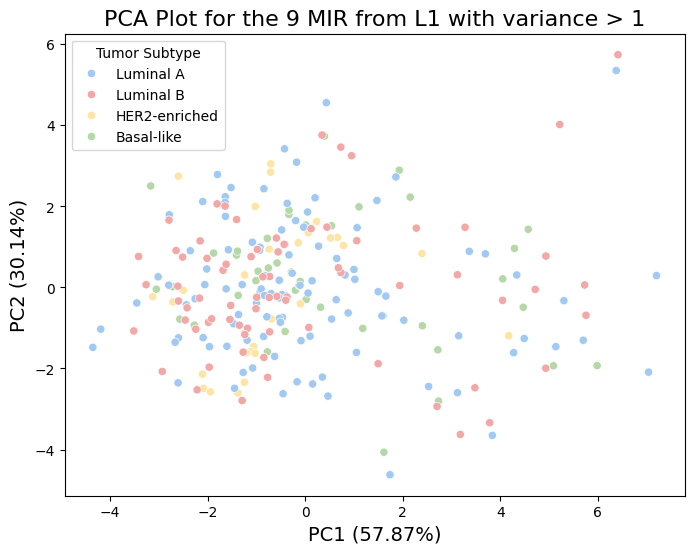

In [106]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_1, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 9 MIR from L1 with variance > 1', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_pc2_l1_1:.2f}%)', fontsize=14)

plt.show()

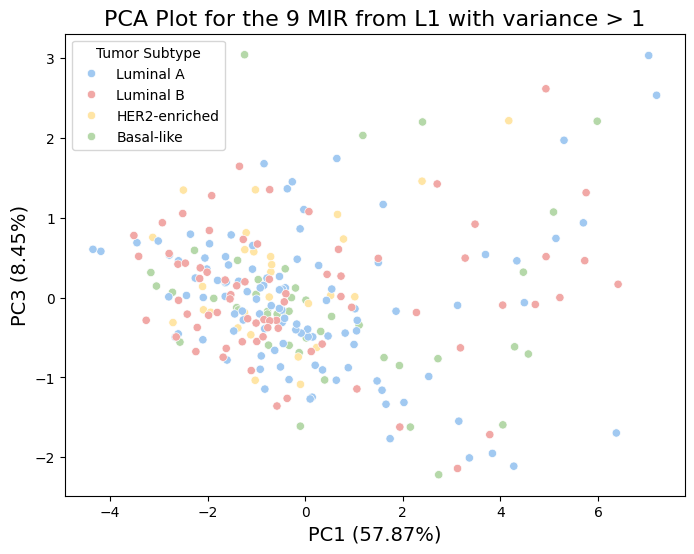

In [107]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_1, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 9 MIR from L1 with variance > 1', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_var_pc3_l1_1:.2f}%)', fontsize=14)

plt.show()

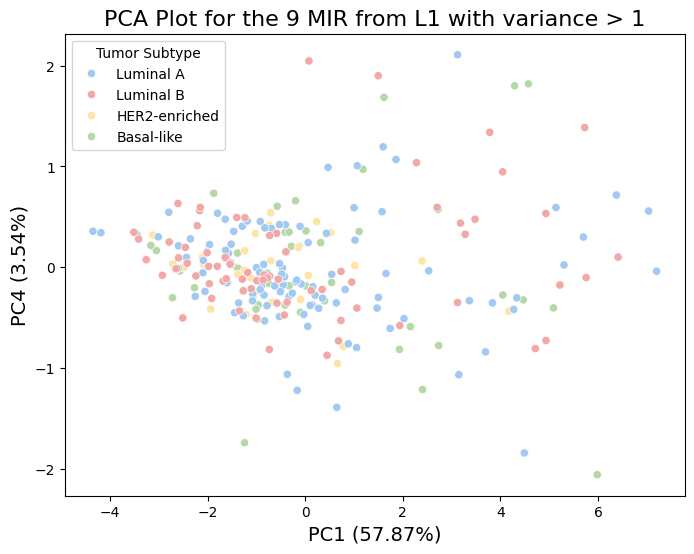

In [108]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_1, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 9 MIR from L1 with variance > 1', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l1_1:.2f}%)', fontsize=14)

plt.show()

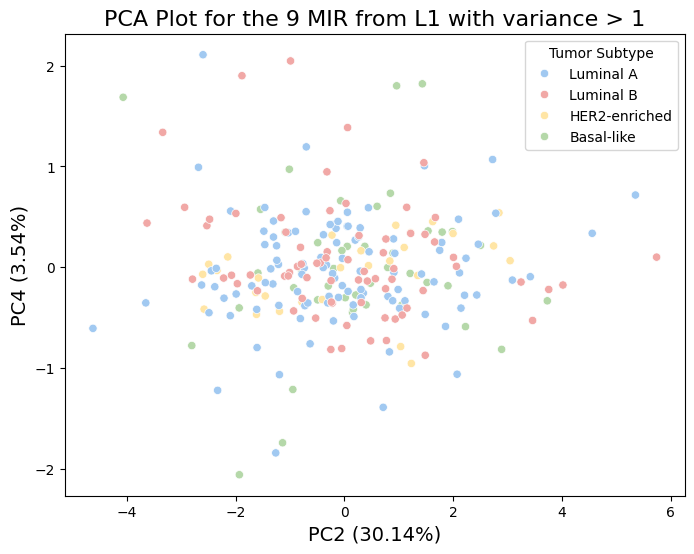

In [109]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_1, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 9 MIR from L1 with variance > 1', fontsize=16)
plt.xlabel(f'PC2 ({explained_var_pc2_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l1_1:.2f}%)', fontsize=14)

plt.show()

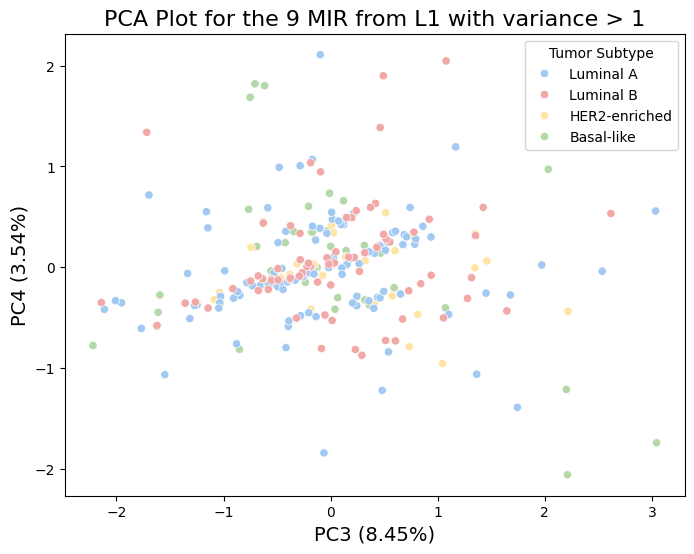

In [110]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_1, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 9 MIR from L1 with variance > 1', fontsize=16)
plt.xlabel(f'PC3 ({explained_var_pc3_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l1_1:.2f}%)', fontsize=14)

plt.show()

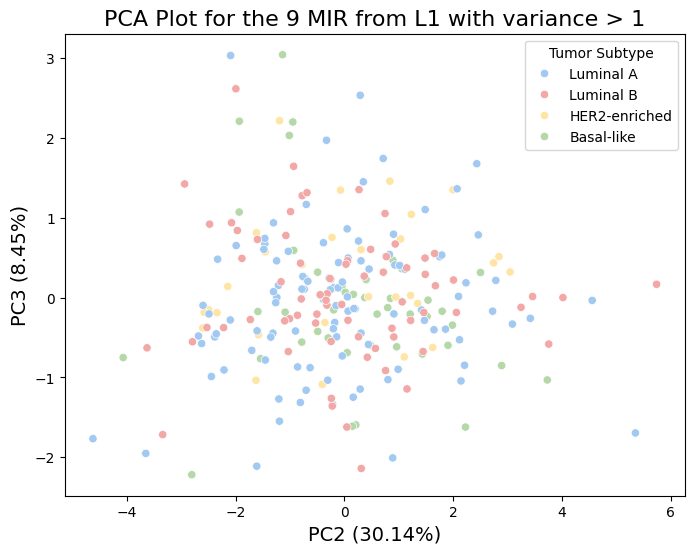

In [111]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l1_1, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 9 MIR from L1 with variance > 1', fontsize=16)
plt.xlabel(f'PC2 ({explained_var_pc2_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_var_pc3_l1_1:.2f}%)', fontsize=14)

plt.show()

L2 thresholds > 0.5 and 1

In [112]:
## Prepare df
df_variance = miRNA_expression.drop(index=['entrezGeneId', 'type'])
df_variancel2 = df_variance.transpose()
df_variancel2 = df_variancel2.drop(index=[r for r in df_variancel1.index if r not in selected_miRNAs_l1_c3])
df_variancel2

TCGA-A1-A0SE-01 TCGA-A1-A0SH-01 TCGA-A1-A0SJ-01  \
hugoGeneSymbol                                                   
MIR-744/744*            0.2973         -0.3408         -1.6876   
MIR-744/744             0.2973         -0.3408         -1.6876   
MIR-744/3P              0.2973         -0.3408         -1.6876   
MIR-744/5P              0.2973         -0.3408         -1.6876   
MIR-758/758             0.2044          1.4946         -0.0618   
...                        ...             ...             ...   
MIR-100/5P              0.9122           1.286          0.4609   
MIR-100-11/100          0.9122           1.286          0.4609   
MIR-101/101             1.8203         -0.5674          0.4688   
MIR-101/3P              1.8203         -0.5674          0.4688   
MIR-101/5P              1.8203         -0.5674          0.4688   

               TCGA-A1-A0SK-01 TCGA-A1-A0SM-01 TCGA-A1-A0SO-01  \
hugoGeneSymbol                                                   
MIR-744/744*            0.1988         -0.0434          1.7106   
MIR-744/744             0.1988         -0.0434          1.7106   
MIR-744/3P              0.1988         -0.0434          1.7106   
MIR-744/5P              0.1988         -0.0434          1.7106   
MIR-758/758            -1.9075          0.2237          0.2881   
...                        ...             ...             ...   
MIR-100/5P             -2.8709         -0.1348         -1.1782   
MIR-100-11/100         -2.8709         -0.1348         -1.1782   
MIR-101/101            -0.1298         -0.9285          0.6624   
MIR-101/3P             -0.1298         -0.9285          0.6624   
MIR-101/5P             -0.1298         -0.9285          0.6624   

               TCGA-A2-A04P-01 TCGA-A2-A04Q-01 TCGA-A2-A04R-01  \
hugoGeneSymbol                                                   
MIR-744/744*            -0.378         -0.8786          0.3478   
MIR-744/744             -0.378         -0.8786          0.3478   
MIR-744/3P              -0.378         -0.8786          0.3478   
MIR-744/5P              -0.378         -0.8786          0.3478   
MIR-758/758            -2.3948          0.3392          0.6054   
...                        ...             ...             ...   
MIR-100/5P               0.426          0.6871          0.4133   
MIR-100-11/100           0.426          0.6871          0.4133   
MIR-101/101            -0.8854          0.1805         -0.5443   
MIR-101/3P             -0.8854          0.1805         -0.5443   
MIR-101/5P             -0.8854          0.1805         -0.5443   

               TCGA-A2-A04V-01  ... TCGA-BH-A0HO-01 TCGA-BH-A0HP-01  \
hugoGeneSymbol                  ...                                   
MIR-744/744*           -0.8847  ...          0.9156         -1.5327   
MIR-744/744            -0.8847  ...          0.9156         -1.5327   
MIR-744/3P             -0.8847  ...          0.9156         -1.5327   
MIR-744/5P             -0.8847  ...          0.9156         -1.5327   
MIR-758/758             0.6602  ...         -1.7507         -0.7018   
...                        ...  ...             ...             ...   
MIR-100/5P             -1.1175  ...         -0.2346          1.2119   
MIR-100-11/100         -1.1175  ...         -0.2346          1.2119   
MIR-101/101            -0.4267  ...          0.3234          1.2329   
MIR-101/3P             -0.4267  ...          0.3234          1.2329   
MIR-101/5P             -0.4267  ...          0.3234          1.2329   

               TCGA-BH-A0HU-01 TCGA-BH-A0HW-01 TCGA-BH-A0HX-01  \
hugoGeneSymbol                                                   
MIR-744/744*            0.4095          0.3909         -0.7938   
MIR-744/744             0.4095          0.3909         -0.7938   
MIR-744/3P              0.4095          0.3909         -0.7938   
MIR-744/5P              0.4095          0.3909         -0.7938   
MIR-758/758            -0.1852         -0.5525           0.243   
...                        ...             ...      

In [113]:
## Calculating variance

variances_l2 = df_variancel2.var(axis=1)
variances_l2

hugoGeneSymbol
MIR-744/744*      1.020959
MIR-744/744       1.020959
MIR-744/3P        1.020959
MIR-744/5P        1.020959
MIR-758/758        1.01281
                    ...   
MIR-100/5P        1.059228
MIR-100-11/100    1.059228
MIR-101/101       1.012801
MIR-101/3P        1.012801
MIR-101/5P        1.012801
Length: 888, dtype: object

In [114]:
# Filter for variance thresholds
filtered_l2_05 = variances_l2[variances_l2 >= 0.5]         ## 888 miRNA which is my total miRNA count
filtered_l2_1 = variances_l2[variances_l2 >= 1]            ## 436 miRNA 

In [115]:
## Prepare df for L2 variance > 1 PCA
# remove 2 rows from miRNA_expression and select the filteres miRNA
features_variance = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
features_variance_l2_1 = features_variance.drop(columns=[col for col in features_variance.columns if col not in filtered_l2_1])

In [116]:
# Initialize PCA
pca_variance_l2_1 = PCA(n_components=4)  

pca_result_var_l2_1 = pca_variance_l2_1.fit_transform(features_variance_l2_1)
explained_var_ratio_l2_1 = pca_variance_l2_1.explained_variance_ratio_
pca_df_var_l2_1 = pd.DataFrame(data=pca_result_var_l2_1, columns=['PC1', 'PC2', 'PC3', 'PC4'])

print("Explained variance ratio (percentage):", explained_var_ratio_l2_1)    ### Values above 0.7 are good

explained_var_pc1_l2_1 = explained_var_ratio_l2_1[0] * 100
explained_var_pc2_l2_1 = explained_var_ratio_l2_1[1] * 100
explained_var_pc3_l2_1 = explained_var_ratio_l2_1[2] * 100
explained_var_pc4_l2_1 = explained_var_ratio_l2_1[3] * 100

Explained variance ratio (percentage): [0.16582385 0.11606013 0.07690141 0.04617654]


In [117]:
pca_df_var_l2_1['Tumor Subtype'] = subtype_list
pca_df_var_l2_1

PC1        PC2       PC3       PC4 Tumor Subtype
0   -6.441908   5.670695  3.770681  1.145796    Basal-like
1   -5.333870  15.931761  3.818110 -9.327042    Basal-like
2    1.467259   0.338608  4.870587  1.420640    Basal-like
3   -6.902929 -23.657539  1.219803 -2.767344    Basal-like
4   -4.802319   1.311598  2.387636 -5.730002    Basal-like
..        ...        ...       ...       ...           ...
246  6.518570   4.973511  7.516150  9.096308     Luminal B
247  0.555862  -7.771356 -6.389979 -2.857128     Luminal B
248 -4.227467   8.148083 -6.148135  0.901897     Luminal B
249 -1.018152   9.713413 -2.035984  3.774889     Luminal B
250  6.646839  -3.581566 -3.711872 -1.153522     Luminal B

[251 rows x 5 columns]

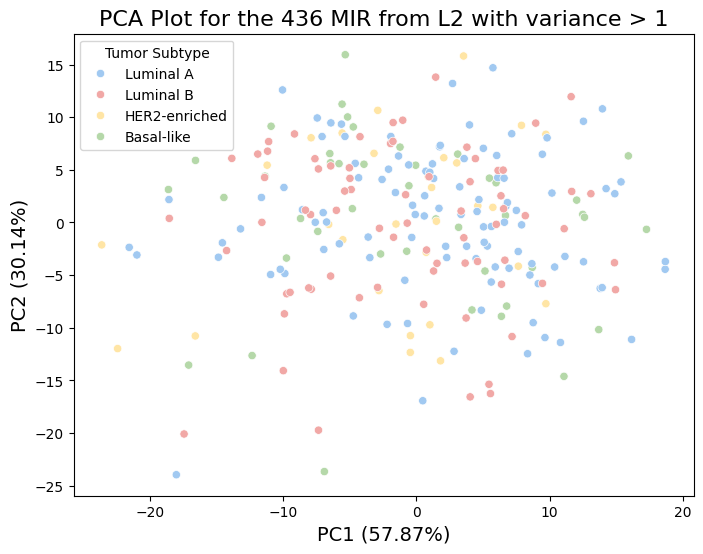

In [118]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l2_1, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 436 MIR from L2 with variance > 1', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_var_pc2_l1_1:.2f}%)', fontsize=14)

plt.show()

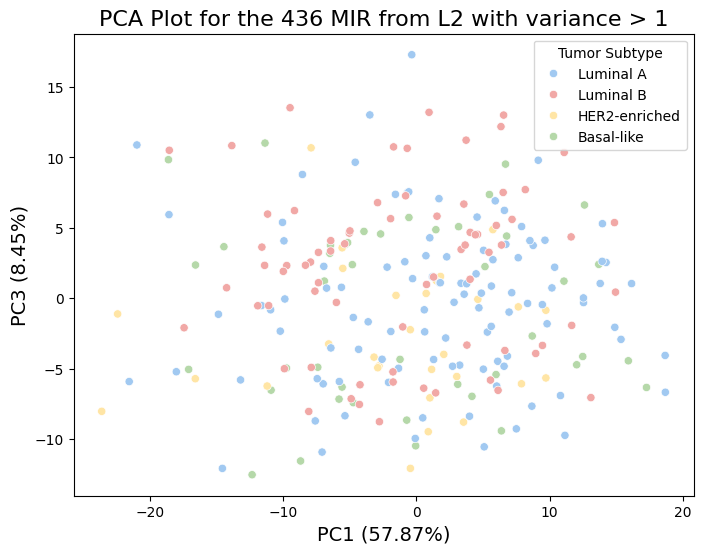

In [119]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l2_1, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 436 MIR from L2 with variance > 1', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_var_pc3_l1_1:.2f}%)', fontsize=14)

plt.show()

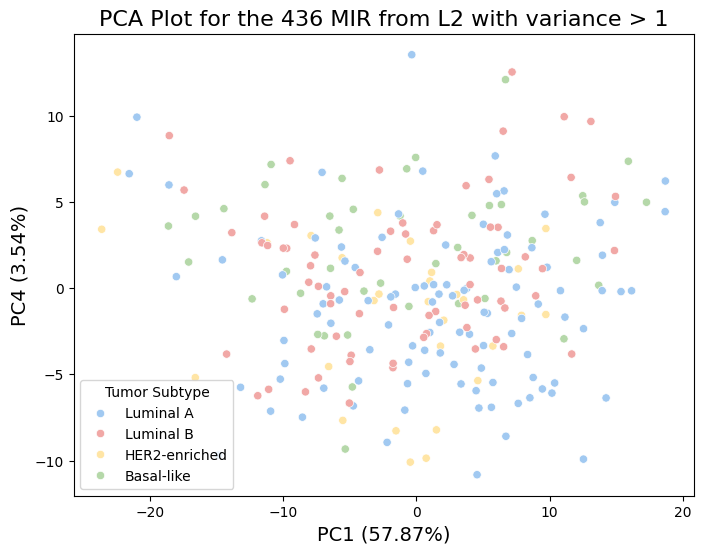

In [120]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l2_1, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 436 MIR from L2 with variance > 1', fontsize=16)
plt.xlabel(f'PC1 ({explained_var_pc1_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l1_1:.2f}%)', fontsize=14)

plt.show()

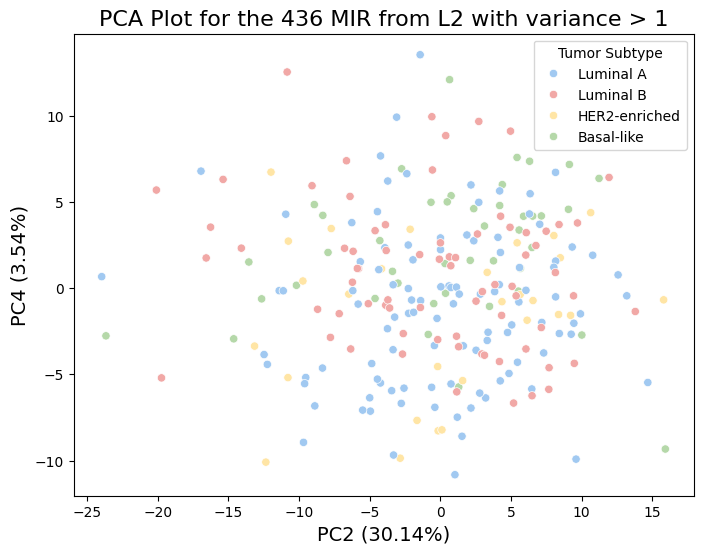

In [121]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l2_1, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 436 MIR from L2 with variance > 1', fontsize=16)
plt.xlabel(f'PC2 ({explained_var_pc2_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l1_1:.2f}%)', fontsize=14)

plt.show()

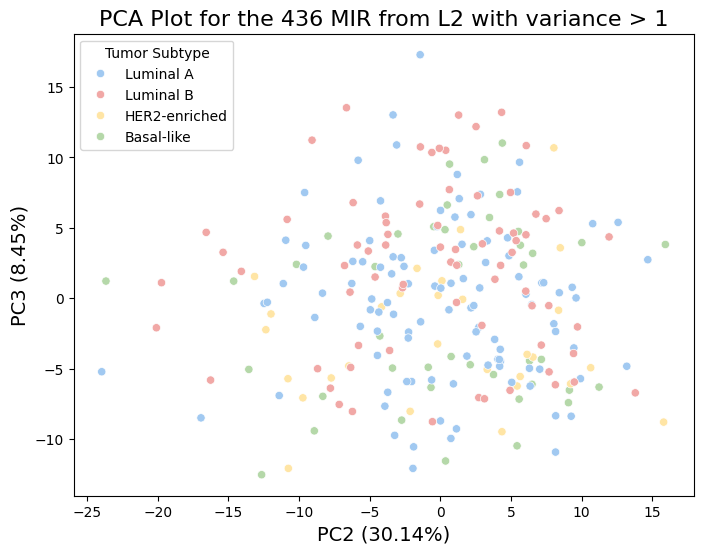

In [122]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l2_1, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 436 MIR from L2 with variance > 1', fontsize=16)
plt.xlabel(f'PC2 ({explained_var_pc2_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_var_pc3_l1_1:.2f}%)', fontsize=14)

plt.show()

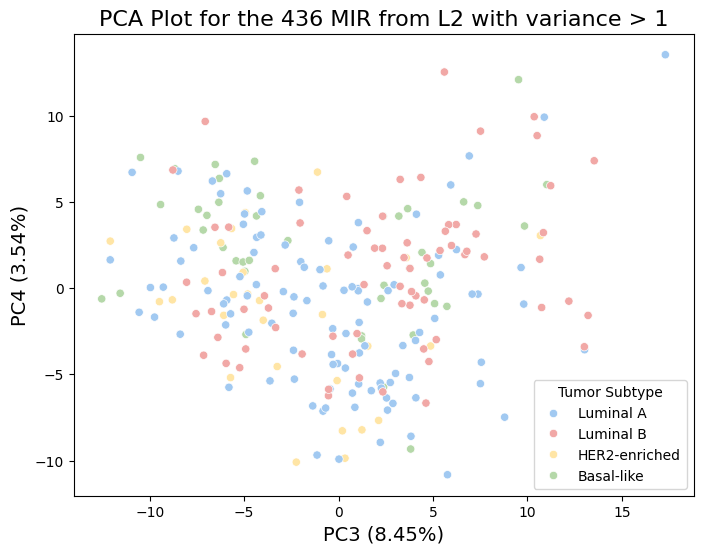

In [123]:
## PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_var_l2_1, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)

plt.title('PCA Plot for the 436 MIR from L2 with variance > 1', fontsize=16)
plt.xlabel(f'PC3 ({explained_var_pc3_l1_1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_var_pc4_l1_1:.2f}%)', fontsize=14)

plt.show()

**PCA with data retrieved from TCGA**

In [124]:
# Data frame with the data non-normalized  -----------------------------  ## I called it non-normalized, but it is normalized ---------------- it's just data retrieved from TCGA in R
non_normalized_data = pd.read_table("C:/Users/marga/Downloads/Projeto/Data_TGCA/BRCA_microRNA_expression.txt", sep='\t')

# Removed the 8 samples of normal like tumour - normal_like_id (list of strings)
non_normalized_data = non_normalized_data.drop(columns=[col for col in normal_like_ids if col in non_normalized_data.columns])

# Remove column 'type' and 'entrezGeneId'
non_normalized_data.drop(columns=['type', 'entrezGeneId'], inplace=True)

# Transpose the data frame
non_normalized_data = np.transpose(non_normalized_data)
non_normalized_data.columns = non_normalized_data.iloc[0]    # need to remove indexes from columns
non_normalized_data = non_normalized_data[1:]

# I only ave the PAM50_subtype for 251 sampleId, so let's filter them
sample_and_subtype = clinical_subtype_extracted_df[["sampleId", "PAM50_SUBTYPE"]]
non_normalized_data = non_normalized_data[non_normalized_data.index.isin(sample_and_subtype['sampleId'])]  # this is ready for PCA, except the tumor subtype is not matched

# I want to now match the tumor subtype to the df
non_normalized_subtype_df = pd.merge(non_normalized_data, sample_and_subtype, left_index=True, right_on='sampleId', how='inner') # merge ensures the sampleId matches the subtype
non_normalized_subtype_df = non_normalized_subtype_df[['sampleId', 'PAM50_SUBTYPE'] + [col for col in non_normalized_subtype_df.columns if col not in ['sampleId', 'PAM50_SUBTYPE']]]

# Extract column with subtype as a list of strings
subtypes_list_non_normalized = non_normalized_subtype_df['PAM50_SUBTYPE'].tolist()

In [125]:
# Perform PCA
pca_4_non_normal = PCA(n_components=4)
features_non_normal = non_normalized_data
principal_components_non_normal = pca_4_non_normal.fit_transform(features_non_normal)

pca_df_non_normal = pd.DataFrame(data=principal_components_non_normal, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_non_normal['Tumor Subtype'] = subtypes_list_non_normalized

explained_variance_non_normal = pca_4_non_normal.explained_variance_ratio_
explained_variance_pc1_non_normal = pca_4_non_normal.explained_variance_ratio_[0] * 100
explained_variance_pc2_non_normal = pca_4_non_normal.explained_variance_ratio_[1] * 100
explained_variance_pc3_non_normal = pca_4_non_normal.explained_variance_ratio_[2] * 100
explained_variance_pc4_non_normal = pca_4_non_normal.explained_variance_ratio_[3] * 100
explained_variance_non_normal

array([0.20118797, 0.0708006 , 0.0632677 , 0.050729  ])

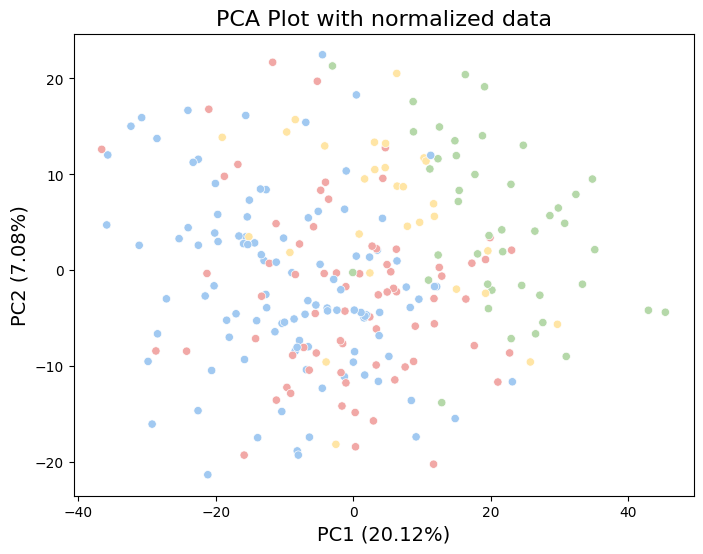

In [126]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_non_normal, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)

plt.title('PCA Plot with normalized data', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_non_normal:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2_non_normal:.2f}%)', fontsize=14)

plt.show()

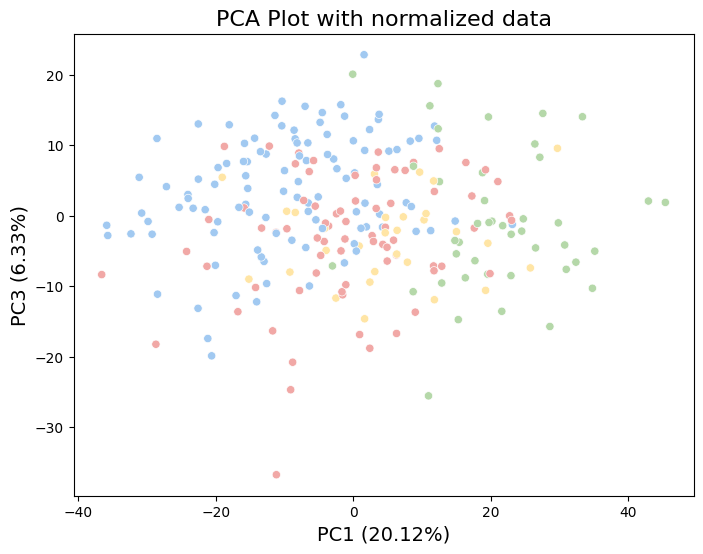

In [127]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_non_normal, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)

plt.title('PCA Plot with normalized data', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_non_normal:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_non_normal:.2f}%)', fontsize=14)

plt.show()

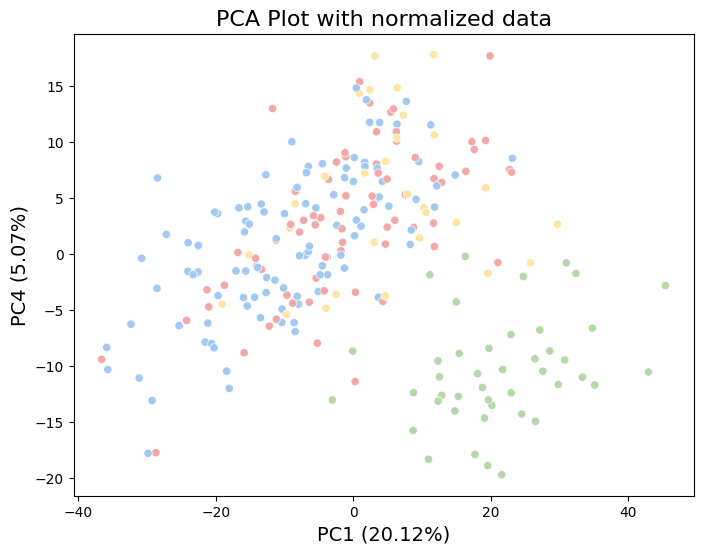

In [128]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_non_normal, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)

plt.title('PCA Plot with normalized data', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_non_normal:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_non_normal:.2f}%)', fontsize=14)

plt.show()

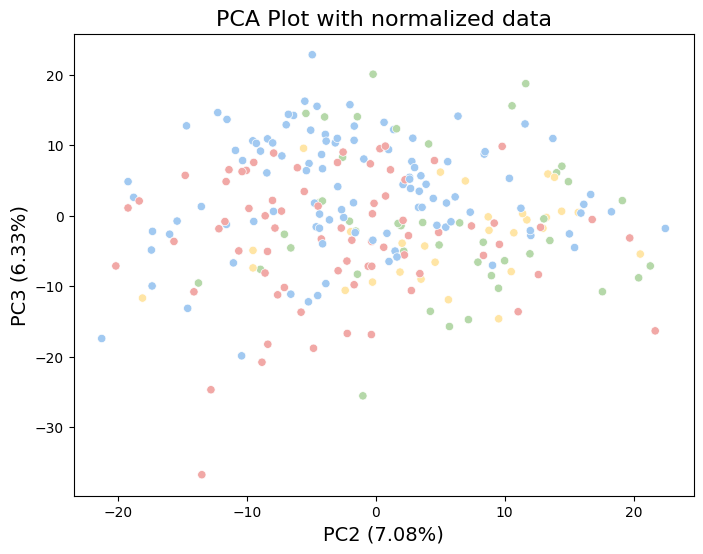

In [129]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_non_normal, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend=False)

plt.title('PCA Plot with normalized data', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_non_normal:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_non_normal:.2f}%)', fontsize=14)

plt.show()

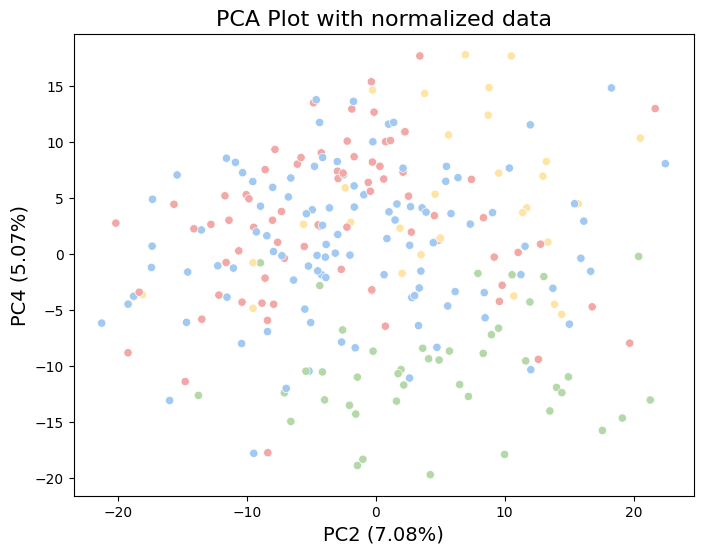

In [130]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_non_normal, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)

plt.title('PCA Plot with normalized data', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_non_normal:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_non_normal:.2f}%)', fontsize=14)

plt.show()

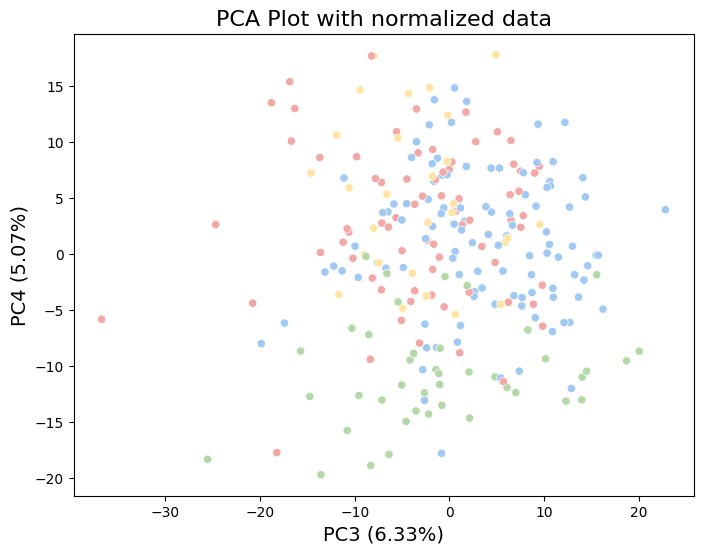

In [131]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_non_normal, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order,legend=False)

plt.title('PCA Plot with normalized data', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3_non_normal:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_non_normal:.2f}%)', fontsize=14)

plt.show()

**Logistic Regression Models with normalized data**

In [132]:
# Expression Table
normalized_expression_table = non_normalized_data

# Expression Table with Clinical Info
df_subtype = non_normalized_subtype_df.iloc[:, :2]
df_subtype

sampleId PAM50_SUBTYPE
237  TCGA-A1-A0SE-01     Luminal A
242  TCGA-A1-A0SH-01     Luminal A
243  TCGA-A1-A0SJ-01     Luminal A
2    TCGA-A1-A0SK-01    Basal-like
389  TCGA-A1-A0SM-01     Luminal B
..               ...           ...
11   TCGA-BH-A0RX-01    Basal-like
439  TCGA-BH-A0W3-01     Luminal B
313  TCGA-BH-A0W4-01     Luminal A
314  TCGA-BH-A0W5-01     Luminal A
67   TCGA-BH-A0WA-01    Basal-like

[251 rows x 2 columns]

In [133]:
# Log regressions - 4 models with penalty L1 and 4 others with L2
# multi_class = 'ovr'

x_norm_tcga_ovr = normalized_expression_table
y_norm_tcga_ovr = df_subtype.squeeze()
y_norm_tcga_ovr = y_norm_tcga_ovr['PAM50_SUBTYPE']

X_train_tcga_ovr, X_test_tcga_ovr, y_train_tcga_ovr, y_test_tcga_ovr = train_test_split(x_norm_tcga_ovr, y_norm_tcga_ovr, test_size=0.2, random_state=42, stratify=y_norm_tcga_ovr)       # y-test are the true labels and y_pred are the predicted labels

model_l1_c1_tcga_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.001, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c1_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

model_l1_c2_tcga_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c2_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

model_l1_c3_tcga_ovr = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c3_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

model_l1_c4_tcga_ovr = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=42, multi_class='ovr', max_iter=10000)
model_l1_c4_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)


## now the L2 models

model_l2_c1_tcga_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.001, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c1_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

model_l2_c2_tcga_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.1, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c2_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

model_l2_c3_tcga_ovr = LogisticRegression(penalty='l2', solver='saga', C=0.5, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c3_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

model_l2_c4_tcga_ovr = LogisticRegression(penalty='l2', solver='saga', C=1, random_state=42, multi_class='ovr', max_iter=10000)
model_l2_c4_tcga_ovr.fit(X_train_tcga_ovr, y_train_tcga_ovr)

models_tcga_ovr = [model_l1_c1_tcga_ovr, model_l1_c2_tcga_ovr, model_l1_c3_tcga_ovr, model_l1_c4_tcga_ovr,
    model_l2_c1_tcga_ovr, model_l2_c2_tcga_ovr, model_l2_c3_tcga_ovr, model_l2_c4_tcga_ovr]

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\li

In [134]:
# Labels for ROC curves
models_label_tcga_ovr = [(model_l1_c1_tcga_ovr, 'L1 (C = 0.001)'),(model_l1_c2_tcga_ovr, 'L1 (C = 0.1)'),
    (model_l1_c3_tcga_ovr, 'L1 (C = 0.5)'),(model_l1_c4_tcga_ovr, 'L1 (C = 1)'),
    (model_l2_c1_tcga_ovr, 'L2 (C = 0.001)'),(model_l2_c2_tcga_ovr, 'L2 (C = 0.1)'),
    (model_l2_c3_tcga_ovr, 'L2 (C = 0.5)'),(model_l2_c4_tcga_ovr, 'L2 (C = 1)')]

model_names_tcga_ovr = ['L1 (C = 0.001)','L1 (C = 0.1)','L1 (C = 0.5)','L1 (C = 1)',
    'L2 (C = 0.001)','L2 (C = 0.1)','L2 (C = 0.5)','L2 (C = 1)']

In [135]:
# Confusion matrices and classification report for different models   

roc_data_cm_tcga_ovr = {} #confusion matrix
roc_data_y_pred_tcga_ovr = {}
roc_data_cr_tcga_ovr = {} #classification report
roc_data_y_score_tcga_ovr = {}
roc_data_auc_tcga_ovr = {}

for model in models_tcga_ovr[0:]:
    y_pred_tcga_ovr = model.predict(X_test_tcga_ovr)
    cm_tcga_ovr = confusion_matrix(y_test_tcga_ovr, y_pred_tcga_ovr)
    cr_tcga_ovr = classification_report(y_test_tcga_ovr, y_pred_tcga_ovr)
    y_score_tcga_ovr = model.predict_proba(X_test_tcga_ovr)
    roc_auc_scores_tcga_ovr = roc_auc_score(y_test_tcga_ovr, y_score_tcga_ovr, multi_class='ovr')

    roc_data_cm_tcga_ovr[model] = cm_tcga_ovr
    roc_data_y_pred_tcga_ovr[model] = y_pred_tcga_ovr
    roc_data_cr_tcga_ovr[model] = cr_tcga_ovr
    roc_data_y_score_tcga_ovr[model] = y_score_tcga_ovr
    roc_data_auc_tcga_ovr[model] = roc_auc_scores_tcga_ovr

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [136]:
# ovr
# Affering which one is the best model - L1
print(roc_data_cr_tcga_ovr[model_l1_c1_tcga_ovr])
print(roc_data_cr_tcga_ovr[model_l1_c2_tcga_ovr]) # Best model for L1
print(roc_data_cr_tcga_ovr[model_l1_c3_tcga_ovr])
print(roc_data_cr_tcga_ovr[model_l1_c4_tcga_ovr]) 

# Affering which one is the best model - L2
print(roc_data_cr_tcga_ovr[model_l2_c1_tcga_ovr])
print(roc_data_cr_tcga_ovr[model_l2_c2_tcga_ovr])
print(roc_data_cr_tcga_ovr[model_l2_c3_tcga_ovr]) # Best model for L2
print(roc_data_cr_tcga_ovr[model_l2_c4_tcga_ovr])

               precision    recall  f1-score   support

   Basal-like       0.00      0.00      0.00         9
HER2-enriched       0.00      0.00      0.00         6
    Luminal A       0.41      1.00      0.58        21
    Luminal B       0.00      0.00      0.00        15

     accuracy                           0.41        51
    macro avg       0.10      0.25      0.15        51
 weighted avg       0.17      0.41      0.24        51

               precision    recall  f1-score   support

   Basal-like       1.00      0.89      0.94         9
HER2-enriched       0.67      0.33      0.44         6
    Luminal A       0.64      1.00      0.78        21
    Luminal B       0.57      0.27      0.36        15

     accuracy                           0.69        51
    macro avg       0.72      0.62      0.63        51
 weighted avg       0.69      0.69      0.65        51

               precision    recall  f1-score   support

   Basal-like       1.00      0.89      0.94         9
HER

C:\Users\marga\AppData\Local\Temp\ipykernel_820\726096072.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")


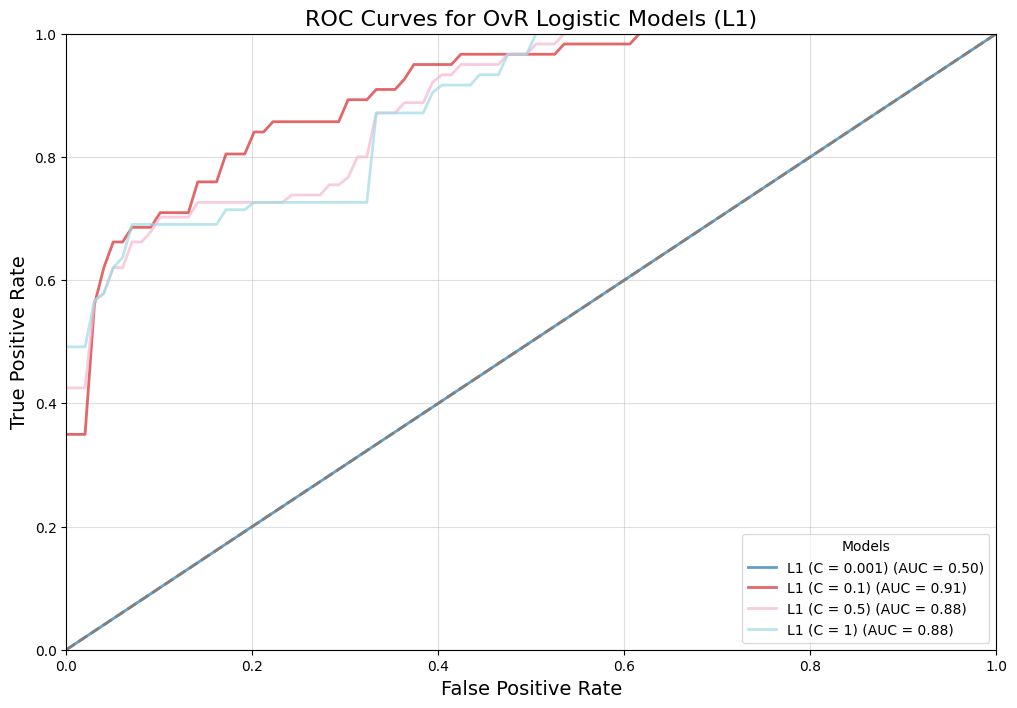

In [137]:
# ROC CURVES   -------------- L1

classes_tcga_ovr = list(set(y_test_tcga_ovr))  # cancer subtypes
n_classes_tcga_ovr = len(classes_tcga_ovr)

y_test_bin_tcga_ovr = label_binarize(y_test_tcga_ovr, classes=classes_tcga_ovr)
roc_curves_tcga_ovr = {}

# Loop through all models and model names
for model, model_name in zip(models_tcga_ovr[:4], model_names_tcga_ovr[:4]):
    y_score_tcga_ovr = model.predict_proba(X_test_tcga_ovr)  # Predicted probabilities for each class
    
    fpr_tcga_ovr = {}
    tpr_tcga_ovr = {}
    auc_per_class_tcga_ovr = {}

    # Compute ROC for each class
    for i in range(n_classes_tcga_ovr):
        fpr_tcga_ovr[i], tpr_tcga_ovr[i], _tcga_ovr = roc_curve(y_test_bin_tcga_ovr[:, i], y_score_tcga_ovr[:, i])  # ROC for class 
        auc_per_class_tcga_ovr[i] = roc_auc_score(y_test_bin_tcga_ovr[:, i], y_score_tcga_ovr[:, i])  # AUC per class
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr_tcga_ovr = np.linspace(0, 1, 100)
    mean_tpr_tcga_ovr = np.mean([np.interp(mean_fpr_tcga_ovr, fpr_tcga_ovr[i], tpr_tcga_ovr[i]) for i in range(n_classes_tcga_ovr)], axis=0)
    
    # Calculate the macro-average AUC
    auc_score_tcga_ovr = np.mean(list(auc_per_class_tcga_ovr.values()))  # average of AUCs per class
    roc_data_auc_tcga_ovr[model_name] = auc_score_tcga_ovr  # Update the AUC in the storage
    
    # Store the mean ROC curve data for the model
    roc_curves_tcga_ovr[model_name] = (mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, auc_score_tcga_ovr)

colormap = get_cmap("tab20") 
colors_tcga_ovr = [colormap(i) for i in np.linspace(0, 1, len(roc_curves_tcga_ovr))]

# Plotting
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, auc_score_tcga_ovr)) in enumerate(roc_curves_tcga_ovr.items()):
    plt.plot(mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, lw=2, label=f"{model_name} (AUC = {auc_score_tcga_ovr:.2f})", color=colors_tcga_ovr[idx], alpha=0.7)

# Diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for OvR Logistic Models (L1)", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title="Models")
plt.grid(alpha=0.4)
plt.show()

C:\Users\marga\AppData\Local\Temp\ipykernel_820\2819208476.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")


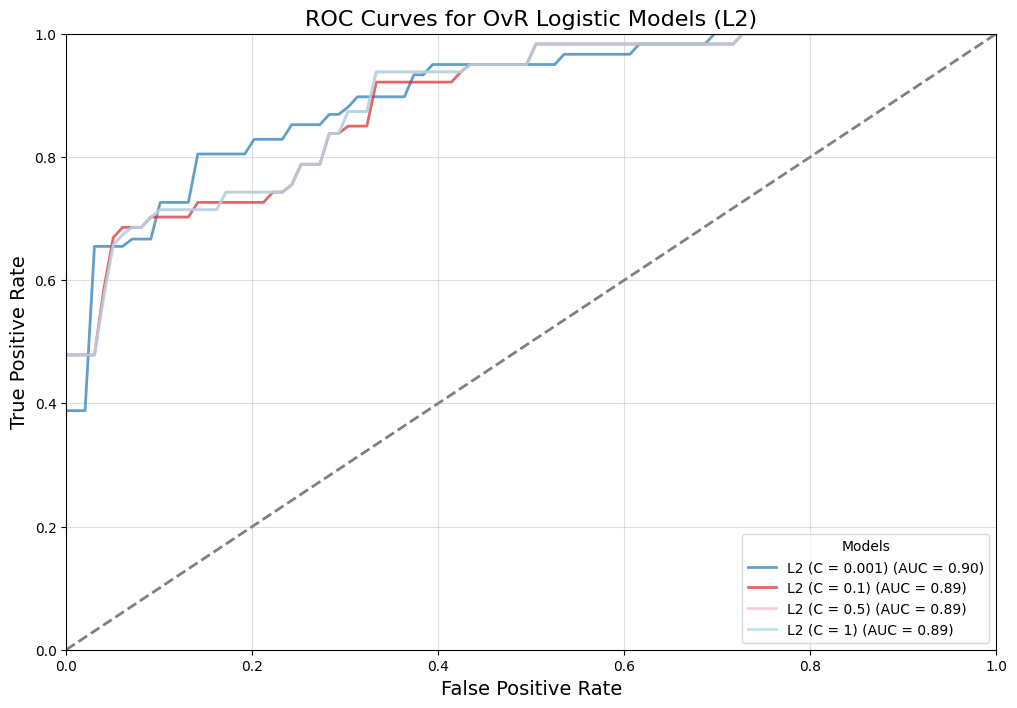

In [138]:
# ROC CURVES   -------------- L2

classes_tcga_ovr = list(set(y_test_tcga_ovr))  # cancer subtypes
n_classes_tcga_ovr = len(classes_tcga_ovr)

y_test_bin_tcga_ovr = label_binarize(y_test_tcga_ovr, classes=classes_tcga_ovr)
roc_curves_tcga_ovr = {}

# Loop through all models and model names
for model, model_name in zip(models_tcga_ovr[4:], model_names_tcga_ovr[4:]):
    y_score_tcga_ovr = model.predict_proba(X_test_tcga_ovr)  # Predicted probabilities for each class
    
    fpr_tcga_ovr = {}
    tpr_tcga_ovr = {}
    auc_per_class_tcga_ovr = {}

    # Compute ROC for each class
    for i in range(n_classes_tcga_ovr):
        fpr_tcga_ovr[i], tpr_tcga_ovr[i], _tcga_ovr = roc_curve(y_test_bin_tcga_ovr[:, i], y_score_tcga_ovr[:, i])  # ROC for class 
        auc_per_class_tcga_ovr[i] = roc_auc_score(y_test_bin_tcga_ovr[:, i], y_score_tcga_ovr[:, i])  # AUC per class
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr_tcga_ovr = np.linspace(0, 1, 100)
    mean_tpr_tcga_ovr = np.mean([np.interp(mean_fpr_tcga_ovr, fpr_tcga_ovr[i], tpr_tcga_ovr[i]) for i in range(n_classes_tcga_ovr)], axis=0)
    
    # Calculate the macro-average AUC
    auc_score_tcga_ovr = np.mean(list(auc_per_class_tcga_ovr.values()))  # average of AUCs per class
    roc_data_auc_tcga_ovr[model_name] = auc_score_tcga_ovr  # Update the AUC in the storage
    
    # Store the mean ROC curve data for the model
    roc_curves_tcga_ovr[model_name] = (mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, auc_score_tcga_ovr)

colormap = get_cmap("tab20") 
colors_tcga_ovr = [colormap(i) for i in np.linspace(0, 1, len(roc_curves_tcga_ovr))]

# Plotting
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, auc_score_tcga_ovr)) in enumerate(roc_curves_tcga_ovr.items()):
    plt.plot(mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, lw=2, label=f"{model_name} (AUC = {auc_score_tcga_ovr:.2f})", color=colors_tcga_ovr[idx], alpha=0.7)

# Diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for OvR Logistic Models (L2)", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title="Models")
plt.grid(alpha=0.4)
plt.show()

C:\Users\marga\AppData\Local\Temp\ipykernel_820\1967707887.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("tab20")


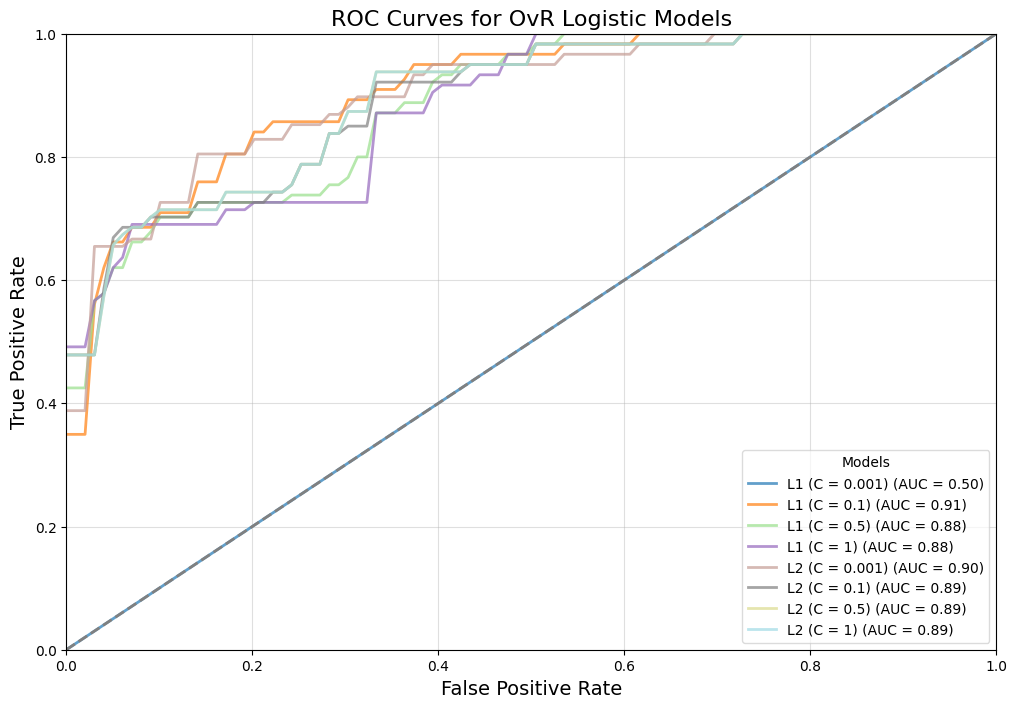

In [139]:
# ROC CURVES   -------------- all

classes_tcga_ovr = list(set(y_test_tcga_ovr))  # cancer subtypes
n_classes_tcga_ovr = len(classes_tcga_ovr)

y_test_bin_tcga_ovr = label_binarize(y_test_tcga_ovr, classes=classes_tcga_ovr)
roc_curves_tcga_ovr = {}

# Loop through all models and model names
for model, model_name in zip(models_tcga_ovr, model_names_tcga_ovr):
    y_score_tcga_ovr = model.predict_proba(X_test_tcga_ovr)  # Predicted probabilities for each class
    
    fpr_tcga_ovr = {}
    tpr_tcga_ovr = {}
    auc_per_class_tcga_ovr = {}

    # Compute ROC for each class
    for i in range(n_classes_tcga_ovr):
        fpr_tcga_ovr[i], tpr_tcga_ovr[i], _tcga_ovr = roc_curve(y_test_bin_tcga_ovr[:, i], y_score_tcga_ovr[:, i])  # ROC for class 
        auc_per_class_tcga_ovr[i] = roc_auc_score(y_test_bin_tcga_ovr[:, i], y_score_tcga_ovr[:, i])  # AUC per class
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr_tcga_ovr = np.linspace(0, 1, 100)
    mean_tpr_tcga_ovr = np.mean([np.interp(mean_fpr_tcga_ovr, fpr_tcga_ovr[i], tpr_tcga_ovr[i]) for i in range(n_classes_tcga_ovr)], axis=0)
    
    # Calculate the macro-average AUC
    auc_score_tcga_ovr = np.mean(list(auc_per_class_tcga_ovr.values()))  # average of AUCs per class
    roc_data_auc_tcga_ovr[model_name] = auc_score_tcga_ovr  # Update the AUC in the storage
    
    # Store the mean ROC curve data for the model
    roc_curves_tcga_ovr[model_name] = (mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, auc_score_tcga_ovr)

colormap = get_cmap("tab20") 
colors_tcga_ovr = [colormap(i) for i in np.linspace(0, 1, len(roc_curves_tcga_ovr))]

# Plotting
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, auc_score_tcga_ovr)) in enumerate(roc_curves_tcga_ovr.items()):
    plt.plot(mean_fpr_tcga_ovr, mean_tpr_tcga_ovr, lw=2, label=f"{model_name} (AUC = {auc_score_tcga_ovr:.2f})", color=colors_tcga_ovr[idx], alpha=0.7)

# Diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for OvR Logistic Models", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title="Models")
plt.grid(alpha=0.4)
plt.show()

In [140]:
# Extract list of miRNa from the best models   - L1
coefficients_l1_c2_tcga_ovr = model_l1_c2_tcga_ovr.coef_[0]  
selected_indices_l1_c2_tcga_ovr = [i for i, coef in enumerate(coefficients_l1_c2_tcga_ovr) if coef != 0 and coef > 0]

miRNA_names_l1_c2_tcga_ovr = normalized_expression_table.columns.tolist()
selected_miRNAs_l1_c2_tcga = [miRNA_names_l1_c2_tcga_ovr[i] for i in selected_indices_l1_c2_tcga_ovr]  
len(selected_miRNAs_l1_c2_tcga)  

14

In [141]:
# Extract list of miRNa from the best models   - L2
coefficients_l2_c3_tcga_ovr = model_l2_c3_tcga_ovr.coef_[0]  
selected_indices_l2_c3_tcga_ovr = [i for i, coef in enumerate(coefficients_l2_c3_tcga_ovr) if coef != 0 and coef > 0]

miRNA_names_l2_c3_tcga_ovr = normalized_expression_table.columns.tolist()
selected_miRNAs_l2_c3_tcga_ovr = [miRNA_names_l2_c3_tcga_ovr[i] for i in selected_indices_l2_c3_tcga_ovr]  
len(selected_miRNAs_l2_c3_tcga_ovr)  

516

Now trying witht he multinomial class - still usinf the TCGA retrieved miRNA expression table

In [142]:
# Log regressions - 4 models with penalty L1 and 4 others with L2
# multi_class = 'multinomial'

x_norm_m = normalized_expression_table
y_norm_m = df_subtype.squeeze()
y_norm_m = y_norm_m['PAM50_SUBTYPE']

X_train_norm_m, X_test_norm_m, y_train_norm_m, y_test_norm_m = train_test_split(x_norm_m, y_norm_m, test_size=0.2, random_state=42, stratify=y_norm_m)       # y-test are the true labels and y_pred are the predicted labels

model_norm_l1_c1_m = LogisticRegression(penalty='l1', solver='saga', C=0.001, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l1_c1_m.fit(X_train_norm_m, y_train_norm_m)

model_norm_l1_c2_m = LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l1_c2_m.fit(X_train_norm_m, y_train_norm_m)

model_norm_l1_c3_m = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l1_c3_m.fit(X_train_norm_m, y_train_norm_m)

model_norm_l1_c4_m = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l1_c4_m.fit(X_train_norm_m, y_train_norm_m)


## now the L2 models

model_norm_l2_c1_m = LogisticRegression(penalty='l2', solver='saga', C=0.001, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l2_c1_m.fit(X_train_norm_m, y_train_norm_m)

model_norm_l2_c2_m = LogisticRegression(penalty='l2', solver='saga', C=0.1, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l2_c2_m.fit(X_train_norm_m, y_train_norm_m)

model_norm_l2_c3_m = LogisticRegression(penalty='l2', solver='saga', C=0.5, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l2_c3_m.fit(X_train_norm_m, y_train_norm_m)

model_norm_l2_c4_m = LogisticRegression(penalty='l2', solver='saga', C=1, random_state=42, multi_class='multinomial', max_iter=10000)
model_norm_l2_c4_m.fit(X_train_norm_m, y_train_norm_m)


models_norm_m = [model_norm_l1_c1_m, model_norm_l1_c2_m, model_norm_l1_c3_m, model_norm_l1_c4_m,
    model_norm_l2_c1_m, model_norm_l2_c2_m, model_norm_l2_c3_m, model_norm_l2_c4_m]

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:124

In [143]:
# Labels for ROC curves
models_label_norm_m = [(model_norm_l1_c1_m, 'L1 (C = 0.001)'),(model_norm_l1_c2_m, 'L1 (C = 0.1)'),
    (model_norm_l1_c3_m, 'L1 (C = 0.5)'),(model_norm_l1_c4_m, 'L1 (C = 1)'),
    (model_norm_l2_c1_m, 'L2 (C = 0.001)'),(model_norm_l2_c2_m, 'L2 (C = 0.1)'),
    (model_norm_l2_c3_m, 'L2 (C = 0.5)'),(model_norm_l2_c4_m, 'L2 (C = 1)')]

model_norm_names_m = ['L1 (C = 0.001)','L1 (C = 0.1)','L1 (C = 0.5)','L1 (C = 1)',
    'L2 (C = 0.001)','L2 (C = 0.1)','L2 (C = 0.5)','L2 (C = 1)']

In [144]:
# Confusion matrices and classification report for different models

roc_data_cm_norm_m = {} #confusion matrix
roc_data_y_pred_norm_m = {}
roc_data_cr_norm_m = {} #classification report
roc_data_y_score_norm_m = {}
roc_data_auc_norm_m = {}

for model in models_norm_m[0:]:
    y_pred_norm_m = model.predict(X_test_norm_m)
    cm_norm_m = confusion_matrix(y_test_norm_m, y_pred_norm_m)
    cr_norm_m = classification_report(y_test_norm_m, y_pred_norm_m)
    y_score_norm_m = model.predict_proba(X_test_norm_m)
    roc_auc_scores_norm_m = roc_auc_score(y_test_norm_m, y_score_norm_m, multi_class='ovr')

    roc_data_cm_norm_m[model] = cm_norm_m
    roc_data_y_pred_norm_m[model] = y_pred_norm_m
    roc_data_cr_norm_m[model] = cr_norm_m
    roc_data_y_score_norm_m[model] = y_score_norm_m
    roc_data_auc_norm_m[model] = roc_auc_scores_norm_m

c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marga\Downloads\Projeto\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [145]:
# Affering which one is the best model - L1
print(roc_data_cr_norm_m[model_norm_l1_c1_m])
print(roc_data_cr_norm_m[model_norm_l1_c2_m])
print(roc_data_cr_norm_m[model_norm_l1_c3_m])
print(roc_data_cr_norm_m[model_norm_l1_c4_m])

# Affering which one is the best model - L2
print(roc_data_cr_norm_m[model_norm_l2_c1_m])
print(roc_data_cr_norm_m[model_norm_l2_c2_m])
print(roc_data_cr_norm_m[model_norm_l2_c3_m])
print(roc_data_cr_norm_m[model_norm_l2_c4_m])

               precision    recall  f1-score   support

   Basal-like       0.00      0.00      0.00         9
HER2-enriched       0.00      0.00      0.00         6
    Luminal A       0.41      1.00      0.58        21
    Luminal B       0.00      0.00      0.00        15

     accuracy                           0.41        51
    macro avg       0.10      0.25      0.15        51
 weighted avg       0.17      0.41      0.24        51

               precision    recall  f1-score   support

   Basal-like       1.00      0.78      0.88         9
HER2-enriched       0.75      0.50      0.60         6
    Luminal A       0.66      1.00      0.79        21
    Luminal B       0.50      0.27      0.35        15

     accuracy                           0.69        51
    macro avg       0.73      0.64      0.65        51
 weighted avg       0.68      0.69      0.65        51

               precision    recall  f1-score   support

   Basal-like       1.00      0.89      0.94         9
HER

C:\Users\marga\AppData\Local\Temp\ipykernel_820\522882490.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_m = get_cmap("tab20")


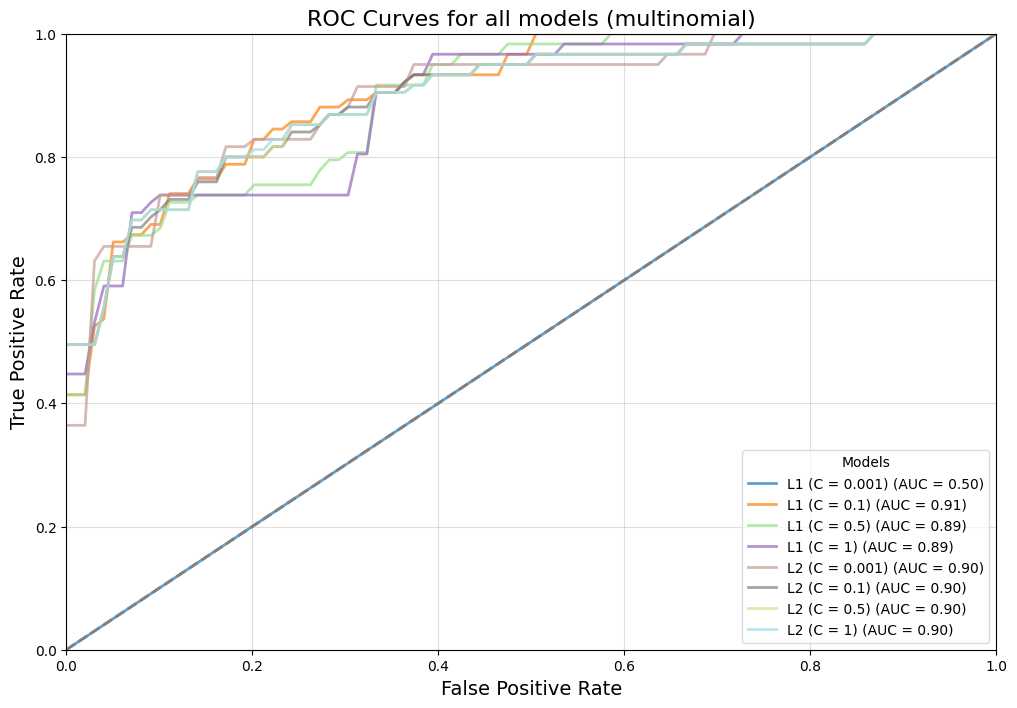

In [146]:
# ROC CURVES 

classes_norm_m = list(set(y_test_norm_m))  # cancer subtypes
n_classes_norm_m = len(classes_norm_m)

y_test_bin_norm_m = label_binarize(y_test_norm_m, classes=classes_norm_m)
roc_curves_norm_m = {}

# Loop through all models and model names
for model, model_name in zip(models_norm_m, model_norm_names_m):
    y_score_norm_m = model.predict_proba(X_test_norm_m)  # Predicted probabilities for each class
    
    fpr_norm_m = {}
    tpr_norm_m = {}
    auc_per_class_m = {}

    # Compute ROC for each class
    for i in range(n_classes_norm_m):
        fpr_norm_m[i], tpr_norm_m[i], _ = roc_curve(y_test_bin_norm_m[:, i], y_score_norm_m[:, i])  # ROC for class 
        auc_per_class_m[i] = roc_auc_score(y_test_bin_norm_m[:, i], y_score_norm_m[:, i])  # AUC per class
    
    # Calculate the mean ROC curve (average across all classes)
    mean_fpr_norm_m = np.linspace(0, 1, 100)
    mean_tpr_norm_m = np.mean([np.interp(mean_fpr_norm_m, fpr_norm_m[i], tpr_norm_m[i]) for i in range(n_classes_norm_m)], axis=0)
    
    # Calculate the macro-average AUC
    auc_score_norm_m = np.mean(list(auc_per_class_m.values()))  # average of AUCs per class
    roc_data_auc_norm_m[model_name] = auc_score_norm_m  # Update the AUC in the storage
    
    # Store the mean ROC curve data for the model
    roc_curves_norm_m[model_name] = (mean_fpr_norm_m, mean_tpr_norm_m, auc_score_norm_m)

colormap_m = get_cmap("tab20")
colors_norm_m = [colormap_m(i) for i in np.linspace(0, 1, len(roc_curves_norm_m))]

# Plotting
plt.figure(figsize=(12, 8))

# Iterate through models and plot their aggregated ROC curve with model names
for idx, (model_name, (mean_fpr_norm_m, mean_tpr_norm_m, auc_score_norm_m)) in enumerate(roc_curves_norm_m.items()):
    plt.plot(mean_fpr_norm_m, mean_tpr_norm_m, lw=2, label=f"{model_name} (AUC = {auc_score_norm_m:.2f})", color=colors_norm_m[idx], alpha=0.7)

# Diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves for all models (multinomial)", fontsize=16)
plt.legend(loc="lower right", fontsize=10, frameon=True, framealpha=0.7, title="Models")
plt.grid(alpha=0.4)
plt.show()

**ANOVA Analysis**

In [147]:
# Data Preparation
anova_data = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)                 # data used: miRNA expression normalized in z-scores
sample_and_subtype = clinical_subtype_extracted_df[["sampleId", "PAM50_SUBTYPE"]]

# I want to now match the tumor subtype to the df
anova_df = pd.merge(anova_data, sample_and_subtype, left_index=True, right_on='sampleId', how='inner') # merge ensures the sampleId matches the subtype
anova_df = anova_df[['sampleId', 'PAM50_SUBTYPE'] + [col for col in anova_data.columns if col not in ['sampleId', 'PAM50_SUBTYPE']]]

# Split the data into separate DataFrames for each tumor subtype
subtype_dfs = {}
unique_subtypes_anova = anova_df['PAM50_SUBTYPE'].unique()

# Drop the 'PAM50_SUBTYPE' column for each subtype DataFrame
for subtype in unique_subtypes_anova:
    subtype_dfs[subtype] = anova_df[anova_df['PAM50_SUBTYPE'] == subtype].reset_index(drop=True)

basal_like_df_anova = subtype_dfs.get('Basal-like')
basal_like_df_anova = basal_like_df_anova.drop(columns=['PAM50_SUBTYPE']) # deleting the column with the subtype
her2_enriched_df_anova = subtype_dfs.get('HER2-enriched')
her2_enriched_df_anova = her2_enriched_df_anova.drop(columns=['PAM50_SUBTYPE'])
luminal_a_df_anova = subtype_dfs.get('Luminal A')
luminal_a_df_anova = luminal_a_df_anova.drop(columns=['PAM50_SUBTYPE'])
luminal_b_df_anova = subtype_dfs.get('Luminal B')
luminal_b_df_anova = luminal_b_df_anova.drop(columns=['PAM50_SUBTYPE'])

In [148]:
# ANOVA
anova_results = {'miRNA': [], 'f_stat': [], 'p_value': []}

# Convert all data in subtype_dfs to numeric values
for subtype, df in subtype_dfs.items():
    subtype_dfs[subtype] = df.apply(pd.to_numeric, errors='coerce')

# Perform ANOVA for each gene across the subtypes
for gene in subtype_dfs['Luminal A'].columns:
    luminal_a = subtype_dfs['Luminal A'][gene]
    luminal_b = subtype_dfs['Luminal B'][gene]
    her2 = subtype_dfs['HER2-enriched'][gene]
    basal = subtype_dfs['Basal-like'][gene]
    
    # Perform ANOVA test for the current gene
    f_stat, p_value = f_oneway(luminal_a, luminal_b, her2, basal)
    
    # Store the results in the dictionary
    anova_results['miRNA'].append(gene)
    anova_results['f_stat'].append(f_stat)
    anova_results['p_value'].append(p_value)

In [149]:
# Convert ANOVA results to DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Drop rows where 'p_value' is NaN
anova_results_df = anova_results_df.dropna(subset=['p_value'])

# Adjust p-values using FDR (Benjamini-Hochberg method)
anova_results_df['adjusted_p_value'] = multipletests(anova_results_df['p_value'], method='fdr_bh')[1]

In [150]:
# ANOVA summary table
anova_summary_df = pd.DataFrame(anova_results)

# Sort by adjusted p-value (ascending) to show the most significant miRNAs first
anova_summary_df = anova_results_df.sort_values(by="adjusted_p_value", ascending=True)
anova_summary_df = anova_summary_df.drop(columns=["p_value"]) #drop p-value

# Display the top 10 significant miRNAs
anova_summary_df.head(10)

miRNA      f_stat  adjusted_p_value
845     MIR-934/934  140.307287      3.919488e-50
809     MIR-577/577  133.349531      9.795224e-49
718   MIR-135B/135B  106.998020      3.047145e-42
717  MIR-135B/135B*  106.998020      3.047145e-42
720     MIR-135B/5P  106.998020      3.047145e-42
719     MIR-135B/3P  106.998020      3.047145e-42
523     MIR-190B/5P   95.107070      5.963065e-39
522     MIR-190B/3P   95.107070      5.963065e-39
521   MIR-190B/190B   95.107070      5.963065e-39
655  MIR-18A/18;18A   91.043617      6.633647e-38

In [151]:
# Filter the significant genes based on adjusted p-value
significant_genes_df = anova_results_df[anova_results_df['adjusted_p_value'] < 0.05]
significant_genes_list = significant_genes_df['miRNA'].tolist()
filtered_expression_df = anova_df[significant_genes_list]

# Extract the expression matrix for PCA
X_anova = filtered_expression_df.values

# Perform PCA
pca_anova = PCA(n_components=4)
pca_result_anova = pca_anova.fit_transform(X_anova)
pca_df_anova = pd.DataFrame(data=pca_result_anova, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_anova['Tumor Subtype'] = anova_df['PAM50_SUBTYPE'].values

explained_variance_anova = pca_anova.explained_variance_ratio_
explained_variance_pc1_anova = explained_variance_anova[0] * 100
explained_variance_pc2_anova = explained_variance_anova[1] * 100
explained_variance_pc3_anova = explained_variance_anova[2] * 100
explained_variance_pc4_anova = explained_variance_anova[3] * 100

In [152]:
## ANOVA identified 692 significant miRNAs
len(significant_genes_list)

692

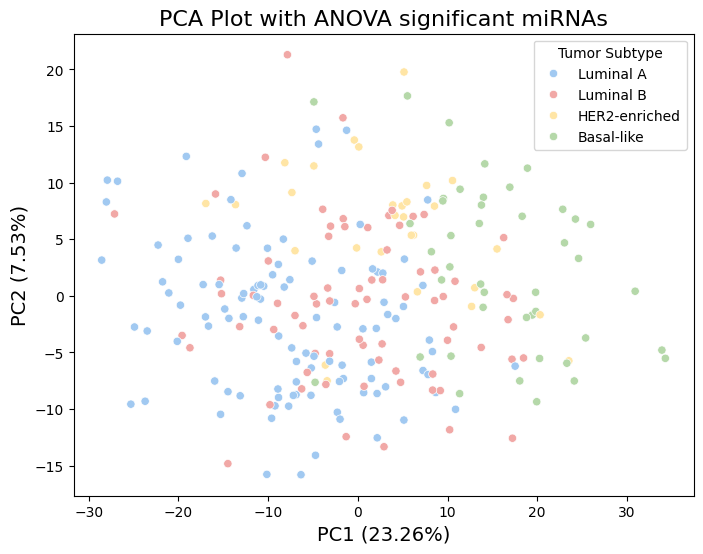

In [153]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Plot with ANOVA significant miRNAs', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2_anova:.2f}%)', fontsize=14)
plt.show()

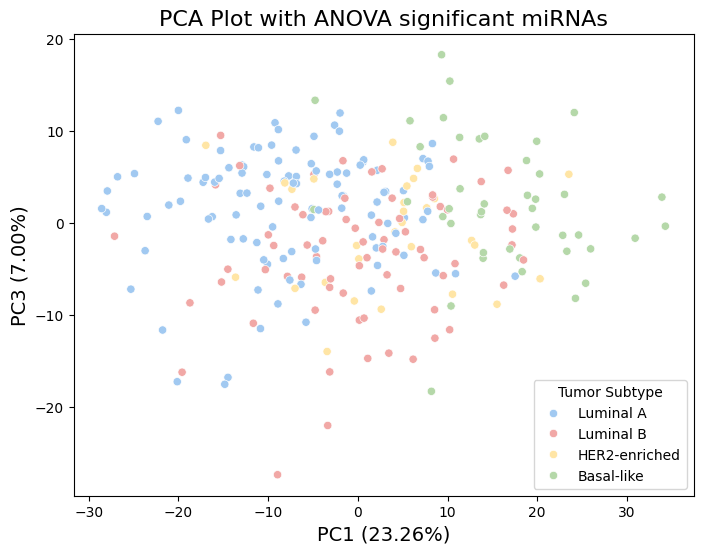

In [154]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Plot with ANOVA significant miRNAs', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_anova:.2f}%)', fontsize=14)
plt.show()

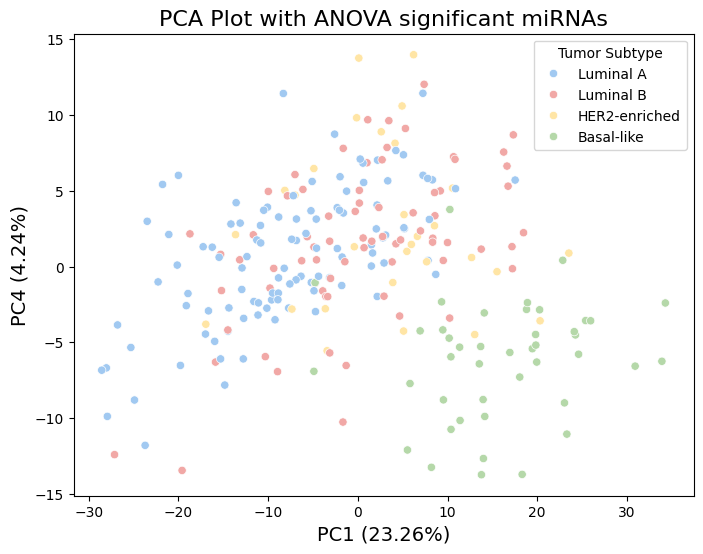

In [155]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Plot with ANOVA significant miRNAs', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova:.2f}%)', fontsize=14)
plt.show()

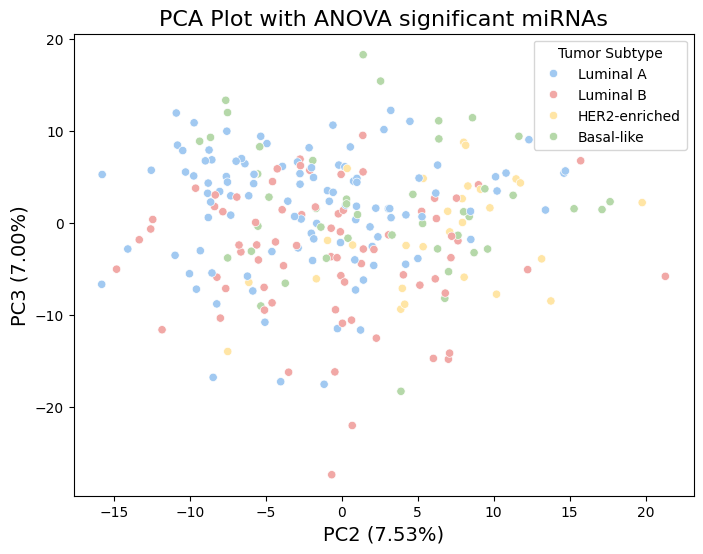

In [156]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Plot with ANOVA significant miRNAs', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_anova:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_anova:.2f}%)', fontsize=14)
plt.show()

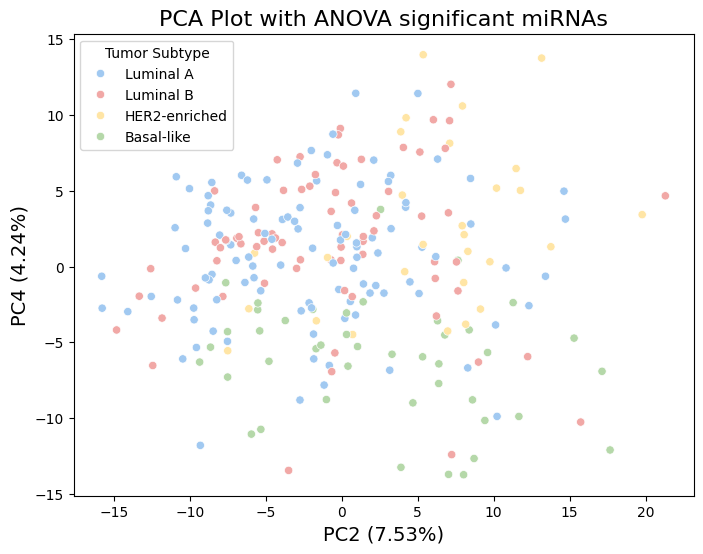

In [157]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Plot with ANOVA significant miRNAs', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_anova:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova:.2f}%)', fontsize=14)
plt.show()

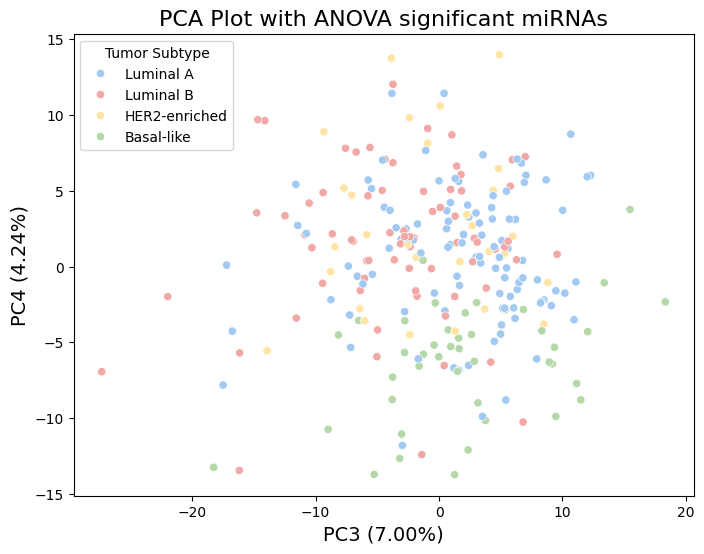

In [158]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Plot with ANOVA significant miRNAs', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3_anova:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova:.2f}%)', fontsize=14)
plt.show()

**Venn Diagram**

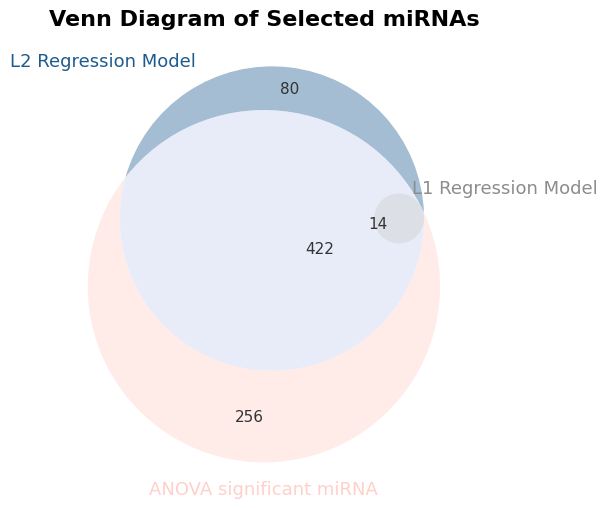

In [159]:
# Set the lists
selected_miRNAs_norm_l2_c3 = set(selected_miRNAs_l2_c3_tcga_ovr) 
selected_miRNAs_norm_l1_c4 = set(selected_miRNAs_l1_c2_tcga)
significant_genes_set = set(significant_genes_list)

#Venn diagram
venn_colors = ['#1D5B8F', '#8C8C8C', '#ffd0ca'] 
plt.figure(figsize=(8, 6))
venn = venn3(
    [selected_miRNAs_norm_l2_c3, selected_miRNAs_norm_l1_c4, significant_genes_set],
    ('L2 Regression Model', 'L1 Regression Model', 'ANOVA significant miRNA'),
    set_colors=venn_colors)

for subset in venn.subset_labels:
    if subset:
        subset.set_fontsize(11)
        subset.set_color('#333333')

for i, set_label in enumerate(venn.set_labels):
    if set_label:
        set_label.set_fontsize(13)
        set_label.set_color(venn_colors[i])

plt.title("Venn Diagram of Selected miRNAs", fontsize=16, fontweight='bold')
plt.show()

Venn Diagram with only L2 and ANOVA

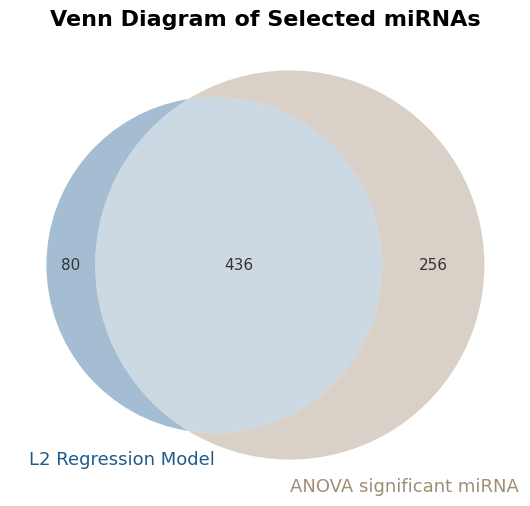

In [160]:
#Venn diagram
venn_colors = ['#1D5B8F', '#A08D76']
plt.figure(figsize=(8, 6))
venn_2 = venn2(
    [selected_miRNAs_norm_l2_c3, significant_genes_set],
    ('L2 Regression Model', 'ANOVA significant miRNA'),
    set_colors=venn_colors)

for subset in venn_2.subset_labels:
    if subset:
        subset.set_fontsize(11)
        subset.set_color('#333333')

for i, set_label in enumerate(venn_2.set_labels):
    if set_label:
        set_label.set_fontsize(13)
        set_label.set_color(venn_colors[i])

plt.title("Venn Diagram of Selected miRNAs", fontsize=16, fontweight='bold')
plt.show()

**PCA with the selected miRNAs from ANOVA and Log regression**

Perform PCAs with 4 components for the 14 miRNA and 436 miRNA obtained from the previous Venn Diagram
ANOVA data - miRNA normalized in z-scores
selected miRNA - normalized TCGA-retrieved miRNA expression data

In [161]:
# Selecting miRNA - ANOVA intersected with L1
miRNA_l1_ANOVA = list(set(selected_miRNAs_norm_l1_c4) & set(significant_genes_set))

# Selecting miRNA - ANOVA intersected with L2
miRNA_l2_ANOVA = list(set(selected_miRNAs_norm_l2_c3) & set(significant_genes_set))

In [162]:
# Data Preparation    
data_anova_l1 = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
data_anova_l1 = data_anova_l1[miRNA_l1_ANOVA]
sample_and_subtype = clinical_subtype_extracted_df[["sampleId", "PAM50_SUBTYPE"]]

# Adding a column of tumor subtypes to the df
anova_df_l1 = pd.merge(sample_and_subtype, data_anova_l1, left_on='sampleId', right_index=True, how='inner') # merge ensures the sampleId matches the subtype

# Retieving list of tumor subtypes
subtype_list_pca_l1_anova = anova_df_l1['PAM50_SUBTYPE'].tolist()

# Df with selected miRNA
anova_df_l1 = pd.merge(sample_and_subtype[['sampleId', 'PAM50_SUBTYPE']], data_anova_l1[miRNA_l1_ANOVA], left_on='sampleId', right_index=True, how='inner')
anova_df_l1 = anova_df_l1.drop('PAM50_SUBTYPE', axis=1)

In [163]:
# Perform PCA
anova_df_l1 = anova_df_l1.set_index('sampleId')
pca_anova_l1 = PCA(n_components=4)
pca_result_anova_l1 = pca_anova_l1.fit_transform(anova_df_l1)
pca_df_anova_l1_ = pd.DataFrame(data=pca_result_anova_l1, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_anova_l1_['Tumor Subtype'] = subtype_list_pca_l1_anova

explained_variance_anova_l1 = pca_anova_l1.explained_variance_ratio_
explained_variance_pc1_anova_l1 = explained_variance_anova_l1[0] * 100
explained_variance_pc2_anova_l1 = explained_variance_anova_l1[1] * 100
explained_variance_pc3_anova_l1 = explained_variance_anova_l1[2] * 100
explained_variance_pc4_anova_l1 = explained_variance_anova_l1[3] * 100

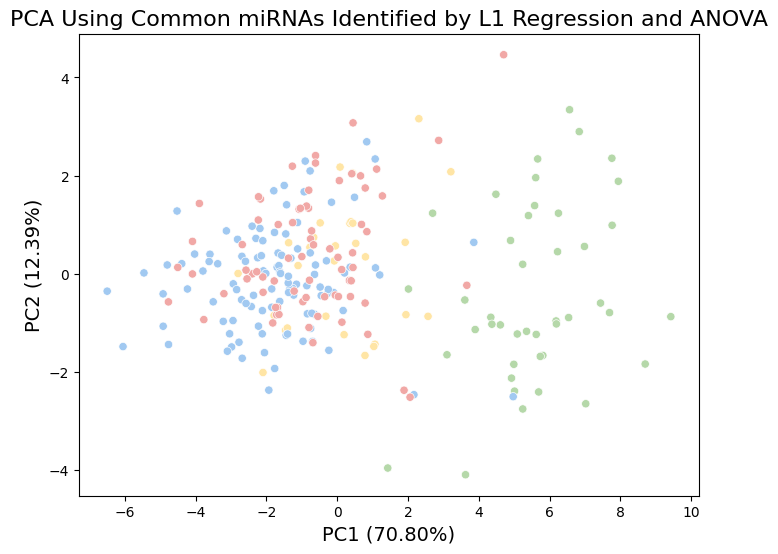

In [164]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l1_, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)
plt.title('PCA Using Common miRNAs Identified by L1 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2_anova_l1:.2f}%)', fontsize=14)
plt.show()

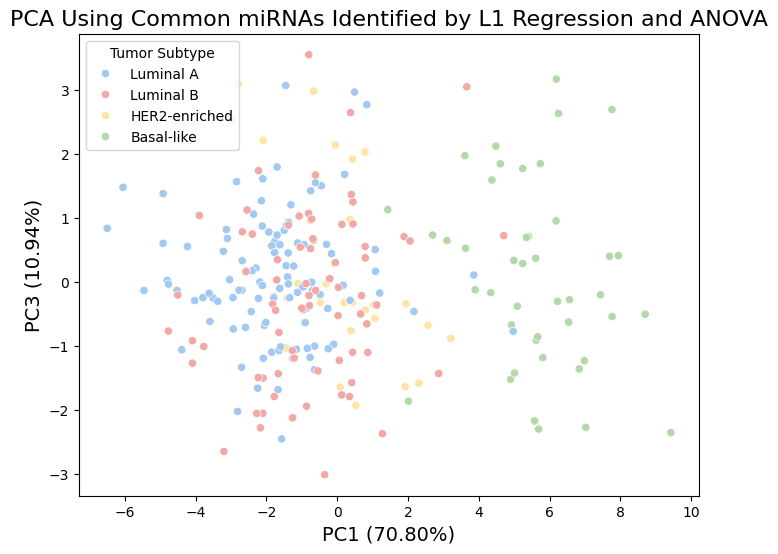

In [165]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l1_, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L1 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_anova_l1:.2f}%)', fontsize=14)
plt.show()

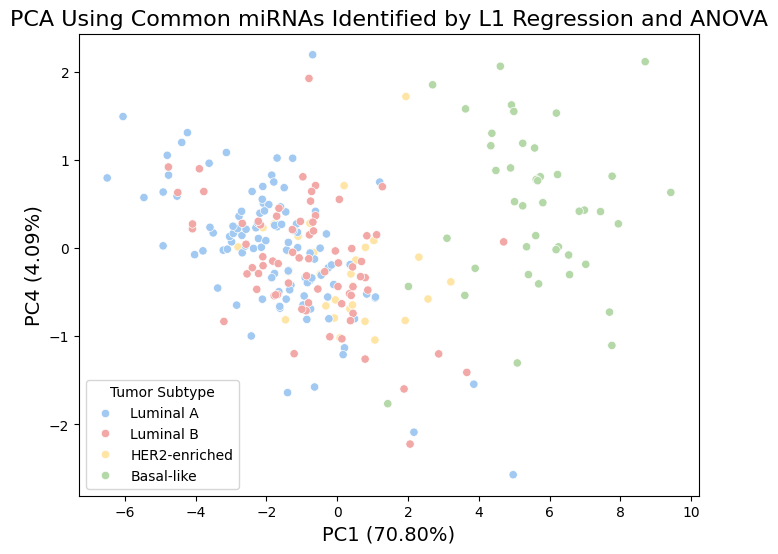

In [166]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l1_, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L1 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova_l1:.2f}%)', fontsize=14)
plt.show()

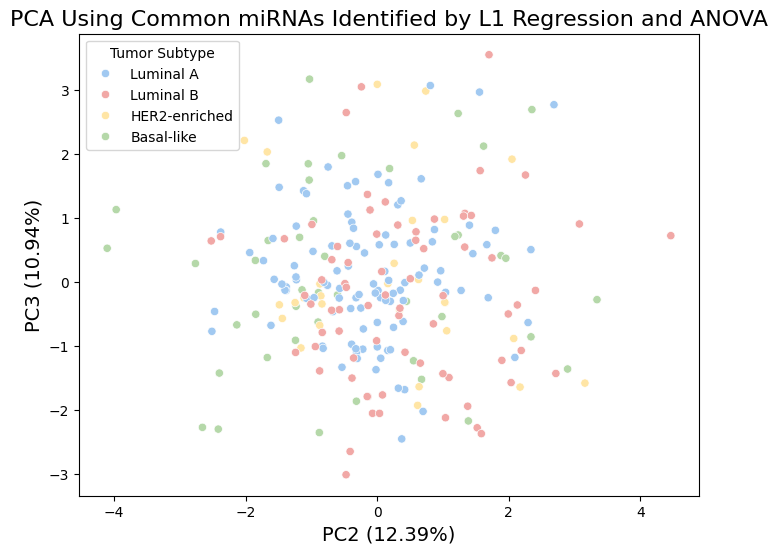

In [167]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l1_, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L1 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_anova_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_anova_l1:.2f}%)', fontsize=14)
plt.show()

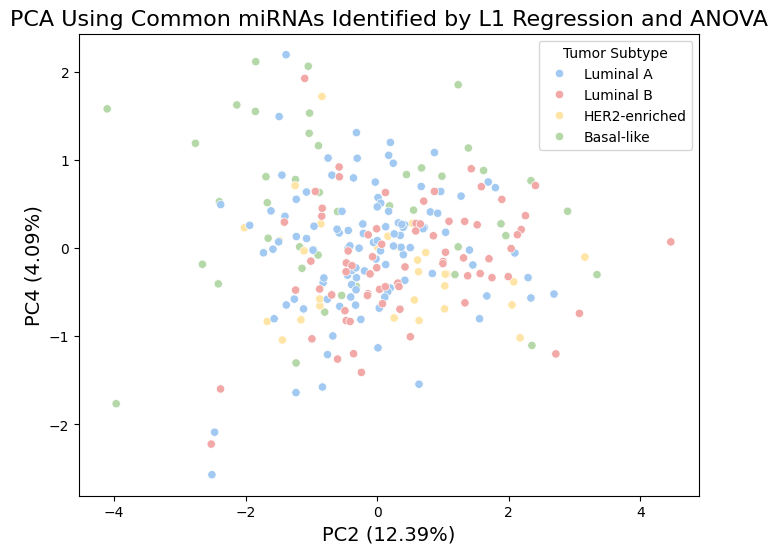

In [168]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l1_, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L1 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_anova_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova_l1:.2f}%)', fontsize=14)
plt.show()

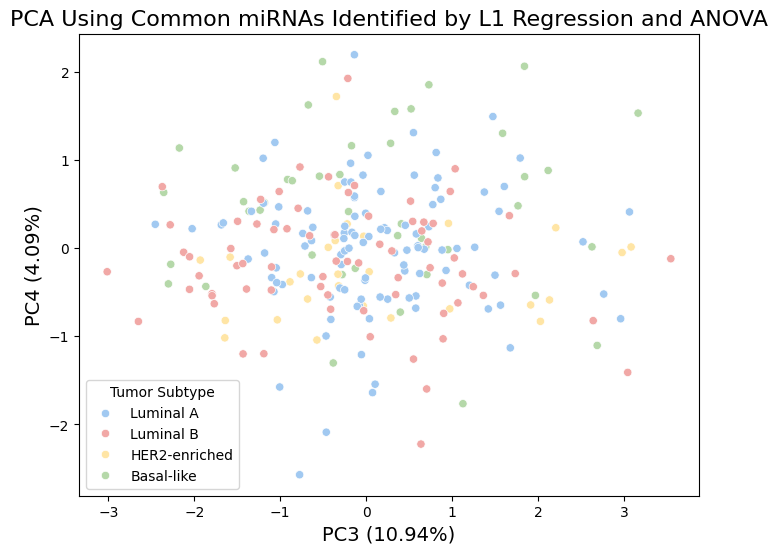

In [169]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l1_, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L1 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3_anova_l1:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova_l1:.2f}%)', fontsize=14)
plt.show()

Perform PCAs with 4 components for the 436 miRNA and 436 miRNA obtained from the previous Venn Diagram

In [170]:
# Data Preparation    
data_anova_l2 = miRNA_expression.drop(['entrezGeneId', 'type'], axis=0)
data_anova_l2 = data_anova_l2[miRNA_l2_ANOVA]
sample_and_subtype = clinical_subtype_extracted_df[["sampleId", "PAM50_SUBTYPE"]]

# Adding a column of tumor subtypes to the df
anova_df_l2 = pd.merge(sample_and_subtype, data_anova_l2, left_on='sampleId', right_index=True, how='inner') # merge ensures the sampleId matches the subtype

# Retieving list of tumor subtypes
subtype_list_pca_l2_anova = anova_df_l2['PAM50_SUBTYPE'].tolist()

# Df with selected miRNA
anova_df_l2 = pd.merge(sample_and_subtype[['sampleId', 'PAM50_SUBTYPE']], data_anova_l2[miRNA_l2_ANOVA], left_on='sampleId', right_index=True, how='inner')
anova_df_l2 = anova_df_l2.drop('PAM50_SUBTYPE', axis=1)

In [171]:
# Perform PCA
anova_df_l2 = anova_df_l2.set_index('sampleId')
pca_anova_l2 = PCA(n_components=4)
pca_result_anova_l2 = pca_anova_l2.fit_transform(anova_df_l2)
pca_df_anova_l2_ = pd.DataFrame(data=pca_result_anova_l2, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df_anova_l2_['Tumor Subtype'] = subtype_list_pca_l2_anova

explained_variance_anova_l2 = pca_anova_l2.explained_variance_ratio_
explained_variance_pc1_anova_l2 = explained_variance_anova_l2[0] * 100
explained_variance_pc2_anova_l2 = explained_variance_anova_l2[1] * 100
explained_variance_pc3_anova_l2 = explained_variance_anova_l2[2] * 100
explained_variance_pc4_anova_l2 = explained_variance_anova_l2[3] * 100

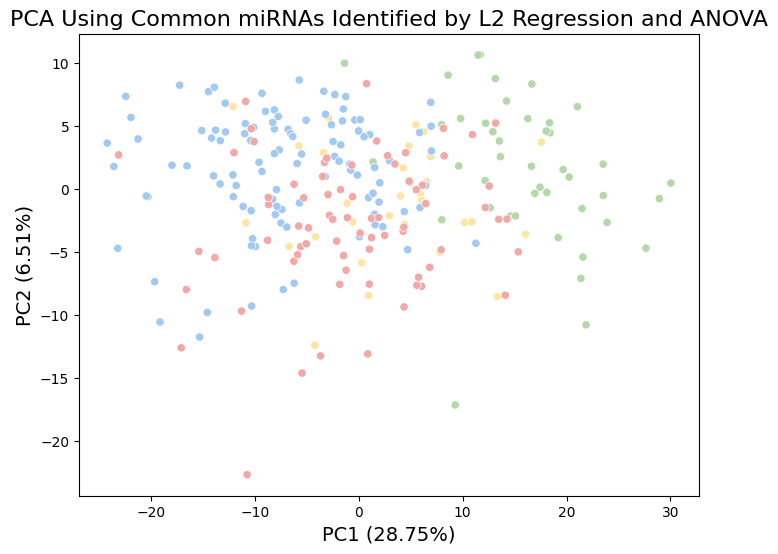

In [172]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l2_, x='PC1', y='PC2', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order, legend = False)
plt.title('PCA Using Common miRNAs Identified by L2 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance_pc2_anova_l2:.2f}%)', fontsize=14)
plt.show()

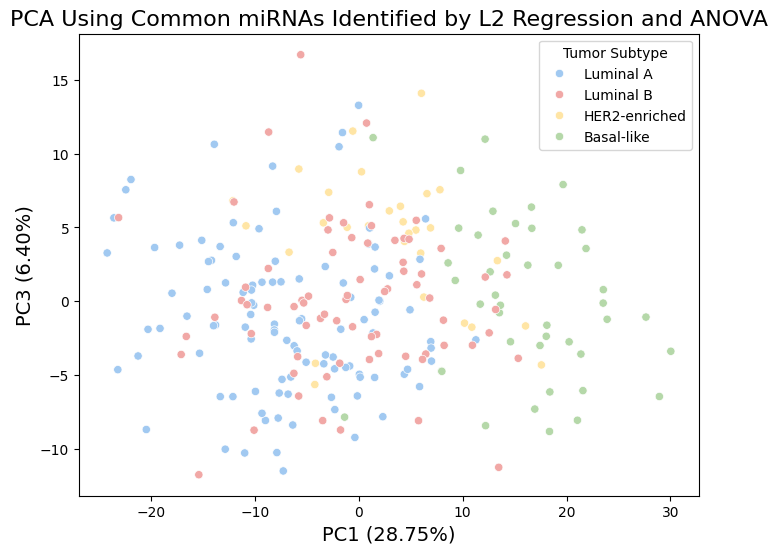

In [173]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l2_, x='PC1', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L2 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_anova_l2:.2f}%)', fontsize=14)
plt.show()

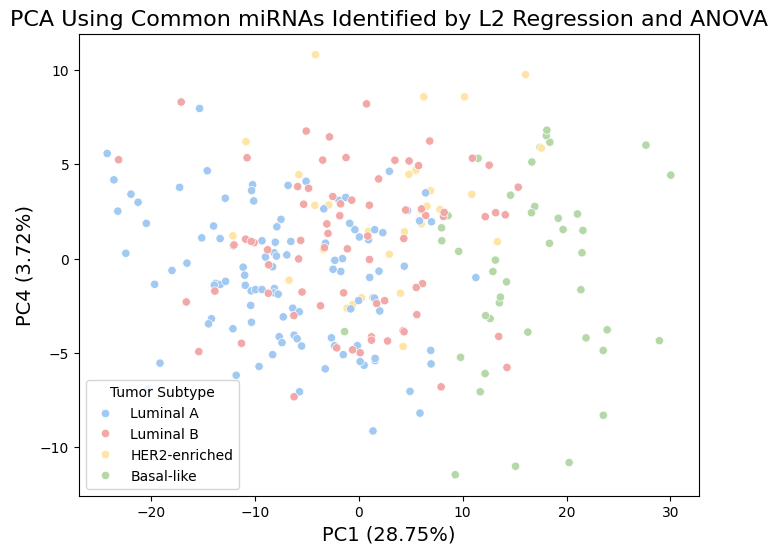

In [174]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l2_, x='PC1', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L2 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance_pc1_anova_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova_l2:.2f}%)', fontsize=14)
plt.show()

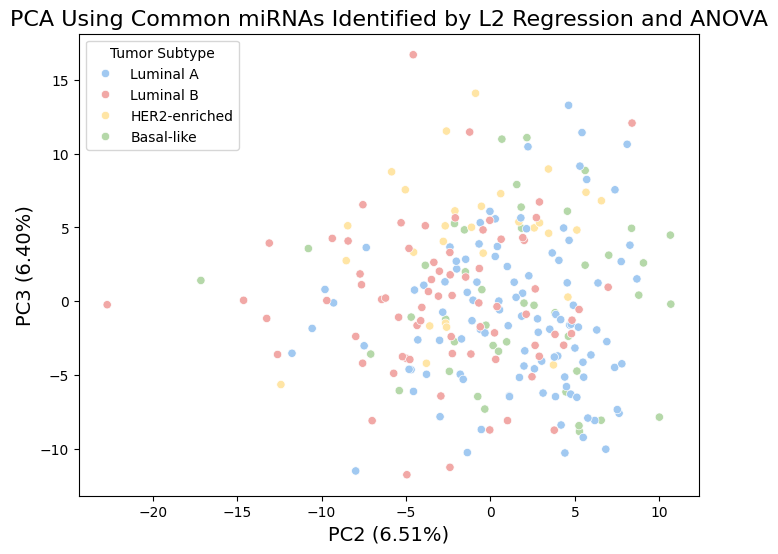

In [175]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l2_, x='PC2', y='PC3', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L2 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_anova_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC3 ({explained_variance_pc3_anova_l2:.2f}%)', fontsize=14)
plt.show()

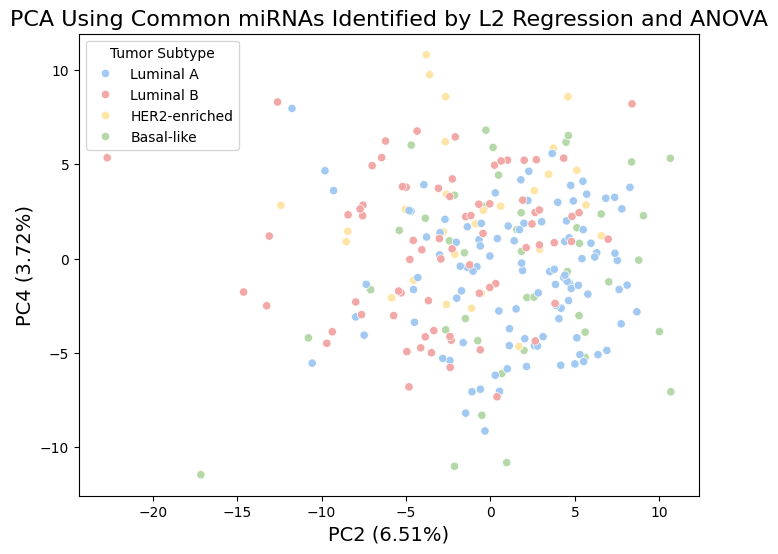

In [176]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l2_, x='PC2', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L2 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC2 ({explained_variance_pc2_anova_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova_l2:.2f}%)', fontsize=14)
plt.show()

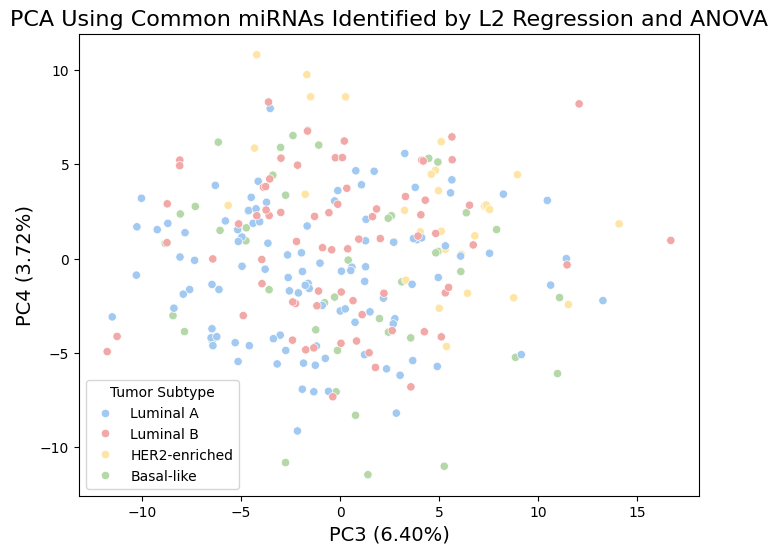

In [177]:
## PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_anova_l2_, x='PC3', y='PC4', hue='Tumor Subtype', palette=tumor_colors, hue_order=subtype_order)
plt.title('PCA Using Common miRNAs Identified by L2 Regression and ANOVA', fontsize=16)
plt.xlabel(f'PC3 ({explained_variance_pc3_anova_l2:.2f}%)', fontsize=14)
plt.ylabel(f'PC4 ({explained_variance_pc4_anova_l2:.2f}%)', fontsize=14)
plt.show()

Where do we stand with the literature?

In [178]:
# Checking for matches and non-matches with the literature miRNA
matches_l1_ANOVA = check_mirna_matches(miRNA_l1_ANOVA, literature_mirna)
matches_l2_ANOVA = check_mirna_matches(miRNA_l2_ANOVA, literature_mirna)
non_matches_l1_ANOVA = set(miRNA_l1_ANOVA) - set(matches_l1_ANOVA)
non_matches_l2_ANOVA = set(miRNA_l2_ANOVA) - set(matches_l2_ANOVA)
print("the 14 miRNAs L1 with ANOVA:", miRNA_l1_ANOVA)
print("Matching miRNAs L1:", matches_l1_ANOVA)
print("Matching miRNAs L2:", matches_l2_ANOVA)
print("Non-matching miRNAs L1:", non_matches_l1_ANOVA)
print("Non-matching miRNAs L2:", non_matches_l2_ANOVA)
print(len(matches_l1_ANOVA), 'matching miRNA out of 14')           # So, we are getting 5 more than the literature(book): ['MIR-9-2/9','MIR-577/577','MIR-9-1/9','MIR-934/934','MIR-9-3/9']
print(len(matches_l2_ANOVA), 'matching miRNA out of 436')

the 14 miRNAs L1 with ANOVA: ['MIR-577/577', 'MIR-18A/5P', 'MIR-18A/3P', 'MIR-934/934', 'MIR-9-1/9', 'MIR-18A/18A*', 'MIR-135B/5P', 'MIR-135B/135B', 'MIR-18A/18;18A', 'MIR-9-3/9', 'MIR-9-2/9', 'MIR-135B/3P', 'MIR-135B/135B*', 'MIR-18A/18A']
Matching miRNAs L1: ['MIR-18A/5P', 'MIR-18A/3P', 'MIR-18A/18A*', 'MIR-135B/5P', 'MIR-135B/135B', 'MIR-18A/18;18A', 'MIR-135B/3P', 'MIR-135B/135B*', 'MIR-18A/18A']
Matching miRNAs L2: ['MIR-18A/18A*', 'MIR-93/5P', 'MIR-183/5P', 'MIR-29A/29A*', 'MIR-135B/3P', 'MIR-183/183*', 'MIR-135B/5P', 'MIR-210/3P', 'MIR-223/223', 'MIR-155/3P', 'MIR-93-1/93', 'MIR-150/150', 'MIR-146A/5P', 'MIR-93/93', 'MIR-223/5P', 'MIR-223/223*', 'MIR-99A/3P', 'MIR-18A/5P', 'MIR-155/5P', 'MIR-150/5P', 'MIR-17/17', 'MIR-93/3P', 'MIR-18A/3P', 'MIR-150/150*', 'MIR-99A/5P', 'MIR-93-7.1/93', 'MIR-183/3P', 'MIR-210/210', 'MIR-155/155', 'MIR-146A/146A', 'MIR-18A/18;18A', 'MIR-99A/99A*', 'MIR-183/183', 'MIR-146A/146A*', 'MIR-181A-2/2*', 'MIR-17/17*', 'MIR-135B/135B', 'MIR-146A/3P', 'MIR-

In [179]:
# check miRNA in the list that ANOVA selected
def find_matching_mirnas(mirna_list, target_mirna):
    """ Find all miRNAs in the list that contain the target miRNA as a substring."""

    pattern = rf"\b{re.escape(target_mirna)}\b|\b{re.escape(target_mirna)}[a-zA-Z*]"
    return [mir for mir in mirna_list if re.search(pattern, mir)]

print(find_matching_mirnas(significant_genes_list, "MIR-9")) #oncomir
print(find_matching_mirnas(significant_genes_list, "LET-7")) #associated with luminal A
print(find_matching_mirnas(significant_genes_list, "MIR-21")) #mir associated to tamoxifen resistance
print(find_matching_mirnas(significant_genes_list, "MIR-132"))

['MIR-9-1/9*', 'MIR-9-1/9', 'MIR-9-2/9*', 'MIR-9-2/9', 'MIR-9-3/9*', 'MIR-9-3/9']
['LET-7C/7C', 'LET-7A-1/7A', 'LET-7A-2/7A', 'LET-7A-2/2*', 'LET-7A-2L/7A', 'LET-7A-3/7A', 'LET-7A-3L/7A', 'LET-7B/7B*', 'LET-7B/7B', 'LET-7B/3P', 'LET-7B/5P', 'LET-7BL/7B', 'LET-7D/7D*', 'LET-7D/7D', 'LET-7D/3P', 'LET-7D/5P', 'LET-7DL/7D', 'LET-7E/7E*', 'LET-7E/7E', 'LET-7E/3P', 'LET-7E/5P', 'LET-7EL/7E', 'LET-7F-1/1*', 'LET-7F-1/7F', 'LET-7F-1L/7F', 'LET-7F-2/7F', 'LET-7F-2/2*', 'LET-7F-2L/7F', 'LET-7G/7G*', 'LET-7G/7G', 'LET-7G/3P', 'LET-7G/5P', 'LET-7I/7I*', 'LET-7I/7I', 'LET-7I/3P', 'LET-7I/5P']
['MIR-21/21*']
['MIR-132/132', 'MIR-132/132*']
